# AFM DASHBOARD

## Load libraries


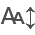

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

import ipywidgets as widgets
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sp
import matplotlib.pyplot as plt
import multiprocessing as mp

import seaborn as sns
import os
import datetime
import time
import itables
from itables import init_notebook_mode
from sklearn.cluster import KMeans
from IPython.display import display, HTML, Image, clear_output
from tkinter import filedialog
from scipy.signal import find_peaks
from numba import njit

from wsxm_read import *
from wsxm_analyze import *
from plot_funcs import *
import transform_funcs as tsf

init_notebook_mode(all_interactive=True)

In [ ]:
set_theme('light') #'dark','light'

## FILE BROWSER

In [ ]:
# folderpath = filedialog.askdirectory(initialdir='/home/pranav/Work/Data/Murcia/AFM2/') #use folder picker dialogbox
# folderpath = '/home/pranav/Work/Data/Murcia/AFM/20240412 thiol interdigielec Sitip old'
# folderpath = 'data/newdata'
# print(f'Data folder: {folderpath}')

#create folder to save dashboard output files in
# outputpath = f'{folderpath}/dashboard output'
# os.makedirs(outputpath, exist_ok=True) #creates folder only if it doesn't already exist
# os.makedirs(outputpath + '/Force volume', exist_ok=True)
# os.makedirs(outputpath + '/Specroscopy', exist_ok=True)
# os.makedirs(outputpath + '/Imaging', exist_ok=True)
refresh=False
flatten_chan = ['Topography']
make_plot=True
sort_asc = True #in case of missing columns or to see image of different direction, change this. 

dash0_filedict = {'full': '', 'summary': ''}
#creates data file list contained within the folder as "datalist.pkl" & "datalist.xlsx"
#Set refresh=True to recreate file list again, else set to False to use previously created file list/create one if it doesn't exist
#Set flatten_chan='all' to flatten all images. To flatten only specific channels, set it as a list e.g. ['Topography', 'Amplitude']. 
#flatten_chan=[] will not flatten anything. flatten_chan only works if refresh=True.
# file_df = wsxm_collect_files(folderpath, refresh=True, flatten_chan = ['Topography'], make_plot=False)

# chans_list = list(file_df['channel'].unique()) #list of unique channels in all files

# # List of regex patterns to ignore in header names
# # bad_patterns = [re.compile(r'Image \d{3}'), re.compile(r'scale,'), re.compile(r'Line \d{1}'), re.compile(r'-- None --'),
# #                 re.compile(r'color'), re.compile(r'Header sections'), re.compile(r'style')] 
# bad_patterns = [re.compile(r'Image \d{3}'), re.compile(r'Curve Settings'), 
#                 re.compile(r'User digital signals out'), re.compile(r'Header sections')] 
# #generate unique header list
# header_unique_names = np.unique(np.concatenate(file_df['header names'].to_list()))
# mask = np.vectorize(lambda s: not any(pattern.search(s) for pattern in bad_patterns))(header_unique_names) # Use numpy's vectorize with a lambda function to create a boolean mask
# header_unique_names = header_unique_names[mask].tolist() # Filter the original array with the boolean mask
# # header_unique_names = [name if name not in chans_list else name + "1" for name in header_unique_names]
# file_df.drop(columns= ['header names'], inplace=True)

#File Viewer Dashboard
dash0_browse_button = widgets.Button(description='Choose data folder')
dash0_browsepath_text = widgets.Output()
dash0_data_type_button = widgets.ToggleButtons(options=['all','1D', '2D', '3D'],
                                               value='all', style={"button_width": "50px"})
dash0_channel_view_select = widgets.SelectMultiple(options=[])#chans_list, #description='channels',
                                             # value=['Topography' if 'Topography' in chans_list else chans_list[0]])
dash0_header_select = widgets.TagsInput(allowed_tags=[],#header_unique_names, 
                                        value=[], allow_duplicates=False, placeholder='add column from header info', 
                                        layout=widgets.Layout(width='450px'))
dash0_table_type_button = widgets.ToggleButtons(options=['full', 'summary'], value='summary',
                                         disabled=False)
dash0_save_button = widgets.Button(description='Save')
dash0_save_text = widgets.Text(value='', placeholder='Enter file name and save displayed table')

# dash0_data_type_button.value = ''
# Inject custom CSS to style the header dropdown list width
dash0_header_css = widgets.HTML("""
<style>
    input[type="text"] { width: 200px;}  /* Adjust the datalist width */   
</style>
""")
dash0_tab1_output = widgets.Output()
dash0_tab2_output = widgets.Output()
dash0_output = widgets.Output()
dash0_table_tab = widgets.Tab()
dash0_table_tab.children = [dash0_tab1_output, dash0_tab2_output, dash0_output]
dash0_table_tab.titles = ['summary', 'full', 'debug']

dash0_box1 = widgets.VBox([dash0_data_type_button, widgets.VBox([dash0_header_select, dash0_header_css])])
dash0_box2 = widgets.HBox([dash0_channel_view_select, dash0_box1, 
                           widgets.VBox([dash0_browsepath_text, dash0_browse_button, dash0_save_text, dash0_save_button])])

# dash0_tab2init = False #recreate full table on clicking the tab initially. Due to an unknown bug, it doesn't show the table otherwise

@dash0_output.capture()
def dash0_load_filedata(change):    
    global folderpath
    global outputpath
       
    # global dash0_tab2init
    # dash0_tab2init = False
    # dash0_table_tab.unobserve_all(dash0_tabchange)
    folderpath = filedialog.askdirectory(initialdir='/home/pranav/Work/Data/Murcia/AFM2/') #use folder picker dialogbox
    dash0_browsepath_text.clear_output(wait=True)
    with dash0_browsepath_text:
        display(f'{folderpath}')
    dash0_tab1_output.clear_output()
    dash0_tab2_output.clear_output()
    dash0_output.clear_output()
    
    #create folder to save dashboard output files in
    outputpath = f'{folderpath}/dashboard output'
    os.makedirs(outputpath, exist_ok=True) #creates folder only if it doesn't already exist
    os.makedirs(outputpath + '/Force volume', exist_ok=True)
    os.makedirs(outputpath + '/Specroscopy', exist_ok=True)
    os.makedirs(outputpath + '/Imaging', exist_ok=True)
    
    dash0_filedict['full'] = wsxm_collect_files(folderpath, refresh=refresh, 
                                                flatten_chan=flatten_chan, make_plot=make_plot)
    dash0_filedict['full'].sort_values(by=['time'], inplace=True)
    chans_list = list(dash0_filedict['full']['channel'].unique()) #list of unique channels in all files

    # List of regex patterns to ignore in header names
    bad_patterns = [re.compile(r'Image \d{3}'), re.compile(r'Curve Settings'), 
                    re.compile(r'User digital signals out'), re.compile(r'Header sections')] 
    #generate unique header list
    header_unique_names = np.unique(np.concatenate(dash0_filedict['full']['header names'].to_list()))
    mask = np.vectorize(lambda s: not any(pattern.search(s) for pattern in bad_patterns))(header_unique_names) # Use numpy's vectorize with a lambda function to create a boolean mask
    header_unique_names = header_unique_names[mask].tolist() # Filter the original array with the boolean mask
    # header_unique_names = [name if name not in chans_list else name + "1" for name in header_unique_names]
    dash0_filedict['full'].drop(columns= ['header names'], inplace=True)

    dash0_channel_view_select.options = chans_list
    dash0_channel_view_select.value = chans_list[0] #['Topography' if 'Topography' in chans_list else chans_list[0]]
    dash0_header_select.allowed_tags = header_unique_names
    # dash0_tab2init = False
    dash0_update_header(None)
    dash0_table_tab.observe(dash0_tabchange, 'selected_index')
    # dash0_update_summarytable(None)
    # dash0_tab2_output.clear_output(wait=True)
    # with dash0_tab2_output:
    #     itables.show(dash0_filedict['full'], column_filters = "footer", layout={"topEnd": None})
    # dash0_table_tab.observe(dash0_tabchange, 'selected_index')
    # dash0_table_tab.selected_index = 0
    

@dash0_output.capture()
def dash0_update_summarytable(change):
    # table_type = dash0_table_type_button.value
    # if table_type == 'summary':
    # global file_df_summary
    file_df =  dash0_filedict['full']
    view_channels = list(dash0_channel_view_select.value) #['Topography', 'Normal force', 'Excitation frequency', 'Adhesion']
    chans_list = dash0_channel_view_select.options
    data_type = dash0_data_type_button.value
    df_list = []
    for key in file_df['file'].unique():
        for chan in view_channels:
            if data_type == 'all':
                file_df_filter = file_df.loc[(file_df.file==key) & (file_df.channel==chan)]
            else:
                file_df_filter = file_df.loc[(file_df.type==data_type) & (file_df.file==key) & (file_df.channel==chan)]
            if file_df_filter.size!=0:                    
                df_list.append(file_df_filter.sort_values(by=['name'], ascending=sort_asc).iloc[0]) #first file (forward dir)
    if len(df_list) == 0:
        dash0_tab1_output.clear_output()
    else:
        file_df2 = pd.concat(df_list, axis=1).transpose()
        #remame column name if it is same as a channel name (eg Amplitude)
        header_names_edit = [name if name not in chans_list else f'{name}1' for name in list(dash0_header_select.value)]
        file_info_cols = ['size','resolution'] + header_names_edit #list(header_select.value)
        column_group = ['file', 'type'] + file_info_cols
        file_df_pivot = file_df2.pivot_table(columns='channel', values='plot', 
                                              index=column_group,
                                             aggfunc='first').reset_index()
        file_df_mintime = file_df2.groupby(column_group)['time'].min().reset_index()
        file_df_summary = pd.merge(file_df_pivot, file_df_mintime, on=column_group)
        file_df_summary = file_df_summary.reindex(view_channels + ['file'] + file_info_cols + ['time'], axis=1)
        file_df_summary.sort_values(by=['time'], inplace=True)
        file_df_summary.dropna(inplace=True) #only show rows which contain images of all selected channels
        dash0_filedict['summary'] =  file_df_summary
        dash0_tab1_output.clear_output(wait=True)
        with dash0_tab1_output:
            itables.show(file_df_summary, classes="display")
                         #columnDefs=[{"width": "10px", "targets": [0]}])
                        #style="text-wrap:wrap")#classes="display") width:100%;margin:auto;

# @dash0_output.capture()
# def dash0_update_tabletype(change):
#     table_type = dash0_table_type_button.value
#     if table_type == 'full':
#         dash0_tab2_output.clear_output()
#         with dash0_output:
#             itables.show(file_df, column_filters = "footer", layout={"topEnd": None})
#         dash0_box2.layout.display='none'
#     if table_type == 'summary':
#         dash0_update_summarytable(None)
#         dash0_box2.layout.display=None

@dash0_output.capture()
def dash0_update_header(change):
    header_selection = dash0_header_select.value
    chans_list = dash0_channel_view_select.options
    file_df =  dash0_filedict['full']
    for header_i in header_selection:
        if header_i not in file_df.columns:
            #remame column name if it is same as a channel name (eg Amplitude)
            col_name = header_i if header_i not in chans_list else f'{header_i}1'
            file_df.insert(len(file_df.columns)-1, col_name, None)
            for i in file_df.index:
                if header_i in file_df.loc[i,'header'].keys():
                    file_df.loc[i, col_name] = file_df.loc[i, 'header'][header_i]
                else:
                    file_df.loc[i, col_name] = ''
    # itables.show(file_df)
    # dash0_update_tabletype(None)
    dash0_update_summarytable(None)
    dash0_tab2_output.clear_output(wait=True)
    with dash0_tab2_output:
        itables.show(file_df, column_filters = "footer", layout={"topEnd": None})

@dash0_output.capture()
def dash0_tabchange(change):
    # global dash0_tab2init
    # print(change)
    if change.new == 1: # and dash0_tab2init == False:
        dash0_tab2_output.clear_output(wait=True)
        with dash0_tab2_output:
            itables.show(dash0_filedict['full'], column_filters = "footer", layout={"topEnd": None})
        # dash0_tab2init = True
        dash0_table_tab.unobserve_all()

@dash0_output.capture()
def dash0_save_click(change):
    if dash0_save_text.value == '':
        name_prefix = 'file_list'
    else:
        name_prefix = f'{dash0_save_text.value}'
    timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    name_suffix = f'{timestamp}'
    selected_tab = dash0_table_tab.titles[dash0_table_tab.selected_index]
    if selected_tab == 'full':
        file_df =  dash0_filedict['full']
        dash0_outfilepath = f'{outputpath}/{name_prefix}_full_{name_suffix}.xlsx'        
        file_df['header data'] = file_df['header'].map(str) #convert dictionary column data to string for excel saving
        file_df.sort_values(by=['time'], inplace=True, ignore_index=True)
        imagedf_to_excel(file_df.drop(columns=['header']),
                         dash0_outfilepath, img_size=(100, 100))
        file_df.drop(columns=['header data'], inplace=True) #remove "stringed" header data
    elif selected_tab == 'summary':
        file_df_summary =  dash0_filedict['summary']
        dash0_outfilepath = f'{outputpath}/{name_prefix}_summary_{name_suffix}.xlsx'
        imagedf_to_excel(file_df_summary, dash0_outfilepath, img_size=(100, 100))

dash0_browse_button.on_click(dash0_load_filedata)
dash0_data_type_button.observe(dash0_update_summarytable, 'value')
dash0_channel_view_select.observe(dash0_update_summarytable, 'value')
dash0_header_select.observe(dash0_update_header, 'value')
# dash0_table_tab.observe(dash0_tabchange, 'selected_index')
dash0_save_button.on_click(dash0_save_click)
# dash0_table_type_button.observe(dash0_update_tabletype, 'value')

# display(dash0_box1)
display(dash0_box2)
display(dash0_table_tab)
# display(dash0_output)

# dash0_update_summarytable(None)
# dash0_tab2_output.clear_output(wait=True)

# with dash0_tab2_output:
#     itables.show(dash0_filedict['full'], column_filters = "footer", layout={"topEnd": None})

# dash0_tab2_output.clear_output(wait=True)
# with dash0_tab2_output:
#     itables.show(file_df, column_filters = "footer", layout={"topEnd": None})
# dash0_update_header(None)
# table_type_button.value = 'summary'
# dash0_update_summarytable(None)
# with dash0_output:
#     itables.show(file_df, column_filters = "header", layout={"topEnd": None})
# box1.layout.display='none'


In [ ]:
filename = '/home/pranav/Work/Data/Murcia/AFM2/20240412 thiol interdigielec Sitip old/interdigThiols_tipSi3nN_a_0003_Normal force.f.stp'
data_dict_chan_i = wsxm_readspectra(filename, all_files=False, mute=True)
spectrodf_i = convert_spectro2df(data_dict_chan_i['data'])
spectrodf_i.groupby(['segment']).mean()['y'].to_dict()
str(spectrodf_i.groupby(['segment']).min()['y'].to_dict())
# spectrodf_i.groupby(['segment']).max()['y'].to_string()

In [ ]:
files = ['calibrate_thermalnoise_gain100_laseron_0052', 'calibrate_thermalnoise_laseron_0000']
file_df =  dash0_filedict['full']
filepath_i = folderpath + '/' + file_df.loc[(file_df.file==files[1])].iloc[0].loc['name']
test = wsxm_readchan(filepath_i, all_files=True, mute=True)
amp_data = test['Amplitude']#['Backward']['data']
phase_data = test['Phase']

amp = amp_data['Forward']['data']['Z']
phase = phase_data['Forward']['data']['Z']
amp_flat = amp.flatten()
plt.plot(amp_flat)
plt.plot(np.square(amp_flat))
plt.plot([np.mean(np.square(amp_flat))]*len(amp_flat))
plt.plot([np.sqrt(np.mean(np.square(amp_flat)))]*len(amp_flat))
plt.show()
# print(amp_f.min(), amp_f.max())
# print(chan_data['Forward']['data']['Z'].min(), chan_data['Forward']['data']['Z'].max())
# amp_offset = np.atleast_2d(np.mean(amp_chan['Z'], axis=1)).T
# p, res, rank, sing, rcond = np.polyfit(amp_chan['X'], amp_chan['Z'].T, 1, full=True)
# amp_offset = np.array([np.poly1d(p[:,i])(amp_chan['X']) for i in range(p.shape[1])])
# amp_shifted = amp_chan['Z']-amp_offset
# plt.pcolormesh(chan_data['Backward']['data']['Z'], cmap='afmhot')
# # plt.clim(vmin=np.percentile(chan_data['Z'],1),vmax=np.percentile(chan_data['Z'],99))
# plt.show()
# zz_amp_list = []
# zz_phase_list = []
# for img_dir in amp_data.keys():
#     head_data = amp_data[img_dir]['header']
#     zz_amp = amp_data[img_dir]['data']['Z']
#     zz_phase = phase_data[img_dir]['data']['Z']
#     # xx, yy, zz_amp = get_imgdata(amp_data[img_dir])

#     # xx, yy, zz_phase= get_imgdata(phase_data[img_dir])

#     #true amplitude calculated from amp and phase channels
#     # zz_i = np.sqrt(np.square(zz_amp) + np.square(zz_phase))
#     zz_amp_list.append(zz_amp)
#     zz_phase_list.append(zz_amp)
        
# zz_amp_full = np.concatenate(zz_amp_list, axis=1)
# zz_phase_full = np.concatenate(zz_phase_list, axis=1)

# sample_rate = 15000 #float(head_data['Sampling frequency [Miscellaneous]'].split(' ')[0])
# freq_array, z_pow_amp = signal.periodogram(zz_amp_full, sample_rate, scaling='density') #power spectral density
# freq_array, z_pow_phase = signal.periodogram(zz_phase_full, sample_rate, scaling='density') #power spectral density
# z_pow_true = z_pow_amp + z_pow_phase
# z_pow_avg = np.average(z_pow_true, axis=0) #averaged
# plt.pcolormesh(z_pow_amp, cmap='afmhot')
# plt.show() 
# plt.pcolormesh(z_pow_phase, cmap='afmhot')
# plt.show() 
# plt.pcolormesh(z_pow_true, cmap='afmhot')
# plt.show() 
# freq_array2, z_pow2 = signal.periodogram(z_pow_true, sample_rate, scaling='density') #power spectral density
# plt.pcolormesh(z_pow2, cmap='afmhot')
# plt.show() 
# z_pow_avg_amp = np.average(z_pow_amp, axis=0) #averaged
# z_pow_avg_phase = np.average(z_pow_phase, axis=0) #averaged
# z_pow_avg_true = np.average(z_pow_true, axis=0) #averaged
# plt.plot(freq_array, z_pow_avg_amp, 'r')
# plt.plot(freq_array, z_pow_avg_phase, 'g')
# plt.plot(freq_array, z_pow_avg_true, 'b')
# plt.show()
# n_clusters = 3
# chan_labels = tsf.segment_kmeans(chan_data, n_clusters)

# plt.pcolormesh(chan_labels, cmap='afmhot')
# plt.show()

# data_clustered = {}
# for i in range(n_clusters):
#     data_clustered[i] = chan_data['Z'][chan_labels==i].flatten()  
# sns.histplot(data=data_clustered)#, x="flipper_length_mm", hue="species")
# plt.show()


In [ ]:
#PLANE FILTER TO DO
import itertools
#generate Matrix to use with lstsq for levelling
def poly_matrix(x, y, order=2):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i, j) in enumerate(ij):
        G[:, k] = x**i * y**j
    return G


def level_data(points, order=1):
    X,Y = np.meshgrid(self.df_matrix.columns,
                      self.df_matrix.index)

    if order == 1:
        # best-fit linear plane
        A = np.c_[points[:,0], points[:,1], np.ones(points.shape[0])]
        C,_,_,_ = np.linalg.lstsq(A, points[:,2], rcond=None)    # coefficients
        #print(C)
        # evaluate it on grid
        Z = C[0]*X + C[1]*Y + C[2]
##            print(Z)
        # self.df['Zero fit'] = C[0]*self.df[self.plot_x] + \
        #                       C[1]*self.df[self.plot_y] + C[2]
        #print(self.df)
    elif order == 2:
        x, y, z = points.T
        #x, y = x - x[0], y - y[0]  # this improves accuracy

        # make Matrix:
        G = self.poly_matrix(x, y, order)
        # Solve for np.dot(G, m) = z:
        m = np.linalg.lstsq(G, z, rcond=None)[0]
        #print('m', m)
        # Evaluate it on a grid...
##            GG = self.poly_matrix(X.ravel(), Y.ravel(), order)
##            Z = np.reshape(np.dot(GG, m), X.shape)
##            print(Z)
        self.df['Zero fit'] = np.polynomial.polynomial.polyval2d(self.df[self.plot_x],
                                                                 self.df[self.plot_y],
                                                                 np.reshape(m, (-1, 3)))

    self.df[self.plot_z+' corrected'] = self.df[self.plot_z]-self.df['Zero fit']

    #organize data into matrix for heatmap plot
    self.df_matrix = self.df.pivot_table(values=self.plot_z+' corrected',
                                         index=self.plot_y,
                                         columns=self.plot_x,
                                         aggfunc='first')


## AFM CALIBRATION

### Thermal noise method

In [ ]:
#Calibrate Amplitude in nm/V from thermal noise images (laser on/off)
gain_value = 100 #SET GAIN
k_cantilver = 1.63 #2.66637 #cantilever spring constant in N/m
Temp = 300 #themperature in K
correction_factor = 4/3 # correction factor for deflection calibration; Butt-Jaschke: 4/3, no correction: 1

# files = ['thermalcalib_laseroff_0000', 'thermalcalib_laseroff_0001', 'thermalcalib_laseroff_0002','thermalcalib_laseroff_0003', 'thermalcalib_laseroff_0004',
#         'thermalcalib_laseron_0000', 'thermalcalib_laseron_0001', 'thermalcalib_laseron_0002', 'thermalcalib_laseron_0003', 'thermalcalib_laseron_0004']

file_paths = list(filedialog.askopenfilenames(title='Choose thermal noise image files', 
                                              initialdir=folderpath, filetypes=(('amplitude channel', '*.ch15'),)))

file_df =  dash0_filedict['full']
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))

psd_fitrange = (0, 1) #proportion of data to use for lorentzian fit of psd. useful when psd has peaks on data edges
# chan = 'Amplitude'
# chan_dir = 'Forward'
#AMPLITUDE BACKWARD CHANNEL IS UNUSUALLY BAD! CHECK DATA! 
chan_dirs = ['Forward', 'Backward']
calib_data_dict = {'plot': [], 'file':[], 'frequency':[], 
                   'psd':[], 'psd max':[], 'zrms':[], 'gain in':[], 'Laser':[]}
files_skipped = []
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    data_i = wsxm_readchan(filepath_i, all_files=True, mute=True)
    # wsxm_calc_trueampphase(data_i, data_type='2D')
    # for chan_dir in chan_dirs: #data_i[chan].keys():
    amp_data_i = data_i['Amplitude']
    phase_data_i = data_i['Phase']
    # print(amp_data_i['Forward']['data']['Z'].min(),amp_data_i['Forward']['data']['Z'].max(),
    #      amp_data_i['Backward']['data']['Z'].min(),amp_data_i['Backward']['data']['Z'].max(),
    #      phase_data_i['Forward']['data']['Z'].min(),phase_data_i['Forward']['data']['Z'].max(),
    #      phase_data_i['Backward']['data']['Z'].min(),phase_data_i['Backward']['data']['Z'].max())
    # phase_data_i = data_i['Phase']
    imgdir_i = list(amp_data_i.keys())[0]
    # ampunit_i = amp_data_i['header']['Z Amplitude [General Info]'].split(' ')[1]
    # phaseunit_i = phase_data_i['header']['Z Amplitude [General Info]'].split(' ')[1]
    # if ampunit_i != 'V' or phaseunit_i != 'V':
    #     files_skipped.append(f'{file_i}:{chan_dir}')
    #     # print('RAW DATA NOT IN VOLTS! Skipping:', file_i, chan, chan_dir)
    #     continue
    freq_i, psd_i, psdmax_i, zrms_i, fig_i = get_psd_calib(amp_data_i, phase_data_i)
    # print(zrms_i)
    calib_data_dict['file'].append(file_i)
    # calib_data_dict['direction'].append(chan_dir)
    calib_data_dict['frequency'].append(freq_i)
    calib_data_dict['psd'].append(psd_i)
    calib_data_dict['psd max'].append(psdmax_i)
    calib_data_dict['zrms'].append(zrms_i)
    calib_data_dict['plot'].append(fig_i)
    calib_data_dict['gain in'].append(int(amp_data_i[imgdir_i]['header']['Gain in [Dynamic settings]']))
    calib_data_dict['Laser'].append(amp_data_i[imgdir_i]['header']['Laser On [Miscellaneous]'])
        
calib_df = pd.DataFrame(calib_data_dict)

#assort files into "laser on" and "laser off" groups using kmeans clustering algo on max of psd value
# rms_values = calib_df['psd max'].values.reshape(-1,1)
# kmeans = KMeans(n_clusters=2) # Create a KMeans instance with 2 clusters: kmeans
# kmeans.fit(rms_values) # Fit model to your data
# centroids = kmeans.cluster_centers_# Get the cluster centroids
# low_cluster, high_cluster = (0, 1) if centroids[0] < centroids[1] else (1, 0) # Determine which cluster corresponds to 'low' or 'high'
# calib_df['Laser'] = ['OFF' if label == low_cluster else 'ON' for label in kmeans.labels_]
calib_df_off = calib_df[calib_df['Laser'] == 'No'].sort_values(by=['gain in']).reset_index(drop=True)
calib_df_on = calib_df[calib_df['Laser'] == 'Yes'].sort_values(by=['gain in']).reset_index(drop=True)
row_min = min([calib_df_on.shape[0],calib_df_off.shape[0]]) #for one-to-one map of ON and OFF files

calib_result_dict = {'plot': [], 'Amplitude calib':[], 'Resonance frequency': [], 'Q factor':[], 'Spring constant':[], 'Amp rms': [], 'PSD rms':[],
                     'gain in':[], 'file_on': [], 'file_off': []}
for i in range(row_min):
    if calib_df_on['gain in'].iloc[i] != calib_df_off['gain in'].iloc[i]:
        continue
    ampcali_i, kcant_i, fitdict_i,  plot_i = get_calib(calib_df_on,calib_df_off,i, datarange=psd_fitrange, #qfac_i, amprms_i,
                                                            k_lever=k_cantilver, T=Temp, corr_fac=correction_factor)
    # print(calib_df_on['zrms'].iloc[i], calib_df_off['zrms'].iloc[i], amprms_i)
    zrms_i = (calib_df_on['zrms'].iloc[i]**2+calib_df_off['zrms'].iloc[i]**2)**0.5
    calib_result_dict['Amplitude calib'].append(ampcali_i)
    calib_result_dict['Spring constant'].append(kcant_i)
    calib_result_dict['Resonance frequency'].append(fitdict_i['resonance freq'])
    calib_result_dict['Q factor'].append(fitdict_i['Q factor'])
    calib_result_dict['Amp rms'].append(zrms_i)
    calib_result_dict['PSD rms'].append(fitdict_i['V rms'])
    calib_result_dict['plot'].append(plot_i)
    calib_result_dict['gain in'].append(calib_df_on['gain in'].iloc[i])
    calib_result_dict['file_on'].append(calib_df_on['file'].iloc[i])
    calib_result_dict['file_off'].append(calib_df_off['file'].iloc[i])
calib_result_df = pd.DataFrame(calib_result_dict)


# calib_summary = pd.DataFrame({'Mean': calib_result_df.drop(columns=['plot', 'gain in','file_on','file_off']).mean(),
#                               'Standard Deviation': calib_result_df.drop(columns=['plot', 'gain in', 'file_on', 'file_off']).std()
#                               })
calibdf_long = pd.melt(calib_result_df,  id_vars= ['gain in'], value_vars=['Amplitude calib', 'Resonance frequency', 'Q factor',
                                                                           'Spring constant', 'Amp rms', 'PSD rms'], var_name = 'parameters')
calib_summary = calibdf_long.groupby(['parameters', 'gain in'], as_index=True, sort=False).agg(mean=('value', 'mean'), std=('value', 'std'))

#set calibration dictionary

set_calibdict_values(channel = 'Amplitude', 
                     unit_kw = {'nm': {'factor': calib_summary.at[('Amplitude calib', gain_value), 'mean'], 'offset':0}})
set_calibdict_values(channel = 'True Amplitude',
                     unit_kw = {'nm': {'factor': calib_summary.at[('Amplitude calib', gain_value), 'mean'], 'offset':0}})
set_calibdict_values(channel = 'Amplitude-sample distance',
                     unit_kw = {'nm': {'factor': calib_summary.at[('Amplitude calib', gain_value), 'mean'], 'offset':0}
                               })
set_calibdict_values(channel = 'Amplitude dissipated',
                     unit_kw = {'nm': {'factor': calib_summary.at[('Amplitude calib', gain_value), 'mean'], 'offset':0}
                               })
set_calibdict_values(channel = 'Energy dissipated',
                     unit_kw = {'aJ': {'factor': calib_summary.at[('Amplitude calib', gain_value), 'mean']**2, 'offset':0}
                               })

set_calibdict_values(channel = 'Spring constant',
                     unit_kw = {'N/m': {'factor': calib_summary.at[('Spring constant', gain_value), 'mean'], 'offset':0}})
set_calibdict_values(channel = 'Resonance frequency',
                     unit_kw = {'Hz': {'factor': calib_summary.at[('Resonance frequency', gain_value), 'mean'], 'offset':0}})
set_calibdict_values(channel = 'Quality factor',
                     unit_kw = {'': {'factor': calib_summary.at[('Q factor', gain_value), 'mean'], 'offset':0}})

# CALIB_DICT['Amplitude']['nm']['factor'] = calib_summary['Mean'].loc['Amplitude calib']
# CALIB_DICT['True Amplitude']['nm']['factor'] = calib_summary['Mean'].loc['Amplitude calib']

#update pizeo calibration
set_calibdict_values(channel = 'X', unit_kw = {'nm': {'factor': 1, 'offset':0}})
set_calibdict_values(channel = 'Y', unit_kw = {'nm': {'factor': 1, 'offset':0}})
set_calibdict_values(channel = 'Z', unit_kw = {'nm': {'factor': 1, 'offset':0}})
set_calibdict_values(channel = 'Topography', unit_kw = {'nm': {'factor': 1, 'offset':0}})

set_calibdict_values(channel = 'Excitation frequency', unit_kw = {'Hz': {'factor': 1, 'offset':0}})
# CALIB_DICT['X']['nm']['factor'] = 1
# CALIB_DICT['Y']['nm']['factor'] = 1
# CALIB_DICT['Z']['nm']['factor'] = 2
# CALIB_DICT['Topography']['nm']['factor'] = 2

# if len(files_skipped) != 0:
#     print('SOME RAW DATA NOT IN VOLTS! Skipped:', '; '.join(files_skipped))
itables.show(calib_summary)
itables.show(calib_result_df)
# itables.show(calib_df.drop(columns=['frequency', 'psd']))

In [ ]:
#Obtain spring constant from Sader GCI method (requires internet) See https://sadermethod.org/
from Sader_GCI_demo import SaderGCI_GetLeverList, SaderGCI_CalculateK
# SaderGCI_GetLeverList('p.sudersan', 'K76DyGCw')

SaderGCI_CalculateK('p.sudersan', 'K76DyGCw', 5, 
                    calib_summary.at[('Resonance frequency', gain_value), 'mean']/1000, #in kHz
                    calib_summary.at[('Q factor', gain_value), 'mean'])


### Force-distance method

#### Normal force calibration

In [ ]:
#Calibrate normal force and amplitude from spectroscopy curves

k_cantilver = 1.63 #2.66637 #cantilever spring constant in N/m

# file_paths = list(filedialog.askopenfilenames(title='Choose spectroscopy file', 
#                                               initialdir=folderpath, filetypes=(('spectroscopy curves',['*.curves']),
#                                                                                 ('spectroscopy image',['*.stp']),
#                                                                                 ('spectroscopy solo curve',['*.cur','*.curve']),
#                                                                                )))
file_paths = list(filedialog.askopenfilenames(title='Choose spectroscopy file', 
                                              initialdir=folderpath, filetypes=(('force curves',['*Normal force*']),
                                                                               )))
file_df =  dash0_filedict['full']
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))
# files = ['interdigThiols_tipSi3nN_a_0003', 'interdigThiols_tipSi3nN_a_0005']

unit_dict_cali = {'Normal force': 'V',
                  'Normal deflection': 'V',
                  'Amplitude': 'V',
                  'True Amplitude': 'V',
                  'Z': 'nm' #CHECK THIS, MAKE CONSISTENT WITH RAW DATA UNITS
                 }
# chan = 'Normal force'
spec_dir = 'approach'
set_funcdict_kwargs(channel='Normal force',param='Stiffness',kwargs={'method':'best gradient', 'fit_order':1, 
                                                                     'percentile_range':(0, 50), 'filter_size': 30})
set_funcdict_kwargs(channel='True Amplitude',param='True Slope-amp',kwargs={'method':'minmax'})
set_funcdict_kwargs(channel='Amplitude',param='Slope-amp',kwargs={'method':'minmax'})
properties = ['Snap-in distance', 'Adhesion', 'Stiffness', 'Slope-amp', 'True Slope-amp']

calib_spectro_dict = {'plot normf': [], 'plot amp': [], 'normal defl calib [nm/V]':[], 
                      'amplitude calib [nm/V]':[], 'file':[], 'curve num':[]}
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    # filename_i = os.path.basename(filepath_i)
    data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
    # for chan_dir in data_i[chan].keys():
    curve_numlist = data_i['Normal force']['curves'].keys()
    for curv_ind in curve_numlist:
        if curv_ind == 'Average':
            continue
        #normal defl calibration
        defl_data_i = data_i['Normal deflection']['curves'][curv_ind]['data']        
        _, _ = wsxm_calcspectroparam(defl_data_i, 'Normal deflection', #calculate snapin first to get stiffness correctly
                                     unit_dict=unit_dict_cali, properties=properties)
        spectro_data_i = data_i['Normal force']['curves'][curv_ind]['data']
        spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Normal force', 
                                                            unit_dict=unit_dict_cali, properties=properties)
        if spectroparam_i['Stiffness']['value'] != 0:
            defl_calib = 1/spectroparam_i['Stiffness']['value'] #cantilever deflection calibration in nm/V
        else:
            defl_calib = 0
            print('Normal force slope is zero. Check: ', file_i)
        # fig, ax = plt.subplots()
        # sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, labels=labels) #remove legend title        
        # ax.hlines(spectroparam_i['Adhesion']['zero'], spectrodf_i['x'].min(), 
        #            spectrodf_i['x'].max(), linestyles='dashed', colors='r')
        # ax.plot(spectroparam_i['Stiffness']['x'], spectroparam_i['Stiffness']['y'],
        #          'r', linestyle='dashed',linewidth=2)
        fig = plotly_lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", color="segment")
        plotly_dashedlines(plot_type='hline',fig=fig, y=spectroparam_i['Adhesion']['zero'], line_width=2)
        plotly_dashedlines(plot_type='line',fig=fig, x=spectroparam_i['Stiffness']['x'], 
                           y=spectroparam_i['Stiffness']['y'], line_width=2)
        fig.update_layout(showlegend=False)
        fig_i = fig2html(fig, plot_type='plotly')
        # plt.close()
        calib_spectro_dict['normal defl calib [nm/V]'].append(defl_calib)
        calib_spectro_dict['plot normf'].append(fig_i)
        
        #amplitude calibration
        if 'True Amplitude' in data_i.keys(): #FIX THIS!
            # print('True Amplitude calibrated')
            spectro_data_i = data_i['True Amplitude']['curves'][curv_ind]['data']
            spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'True Amplitude', 
                                                                unit_dict=unit_dict_cali, properties=properties)
            if spectroparam_i['True Slope-amp']['value'] != 0:
                amp_calib = 1/spectroparam_i['True Slope-amp']['value'] #amplitude calibration in nm/V
            else:
                amp_calib = 0
                print('Amp slope is zero. Check: ', file_i)
            fig = plotly_lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", color="segment")
            plotly_dashedlines(plot_type='line',fig=fig, x=spectroparam_i['True Slope-amp']['x'], 
                               y=spectroparam_i['True Slope-amp']['y'], line_width=2)
        else:
            # print('Amplitude calibrated')
            spectro_data_i = data_i['Amplitude']['curves'][curv_ind]['data']
            spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Amplitude', 
                                                                unit_dict=unit_dict_cali, properties=properties)
            if spectroparam_i['Slope-amp']['value'] != 0:
                amp_calib = 1/spectroparam_i['Slope-amp']['value'] #amplitude calibration in nm/V
            else:
                amp_calib = 0
                print('Amp slope is zero. Check: ', file_i)
        # fig, ax = plt.subplots()
        # sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, labels=labels) #remove legend title        
        # ax.plot(spectroparam_i['Slope-amp']['x'], spectroparam_i['Slope-amp']['y'],
        #          'r', linestyle='dashed',linewidth=2)
            fig = plotly_lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", color="segment")
            plotly_dashedlines(plot_type='line',fig=fig, x=spectroparam_i['Slope-amp']['x'], 
                               y=spectroparam_i['Slope-amp']['y'], line_width=2)
        fig.update_layout(showlegend=False)
        fig_i = fig2html(fig, plot_type='plotly')
        
        # plt.close()
        calib_spectro_dict['amplitude calib [nm/V]'].append(amp_calib)
        calib_spectro_dict['plot amp'].append(fig_i)
        
        calib_spectro_dict['file'].append(file_i)
        calib_spectro_dict['curve num'].append(curv_ind)
        

calib_spectro_df = pd.DataFrame(calib_spectro_dict)

calib_spectro_summary = pd.DataFrame({'Mean': calib_spectro_df[['normal defl calib [nm/V]', 
                                                                'amplitude calib [nm/V]']].mean(),
                                      'Standard Deviation': calib_spectro_df[['normal defl calib [nm/V]', 
                                                                              'amplitude calib [nm/V]']].std()
                                      })
#set calibration dictionary

#UNCOMMENT TO MANUALLY SET SPRING CONSTANT VALUE (input in 'factor' and ignore 'offset')
set_calibdict_values(channel = 'Spring constant',
                     unit_kw = {'N/m': {'factor': k_cantilver, 'offset': 0}})

#COMMENT IF YOU DONT WANT TO USE AMPLITUDE CALIBRATION FROM SPECTROSCOPY FIT
# set_calibdict_values(channel = 'Amplitude', 
#                      unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
#                                })
# set_calibdict_values(channel = 'True Amplitude',
#                      unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
#                                })
# set_calibdict_values(channel = 'Amplitude-sample distance',
#                      unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
#                                })

set_calibdict_values(channel = 'Normal force', 
                     unit_kw = {'nN': {'factor': calib_spectro_summary['Mean'].loc['normal defl calib [nm/V]'] * \
                                       get_calibdict_value('Spring constant','N/m')['factor'], 
                                       'offset':0}
                               })
set_calibdict_values(channel = 'Normal deflection', 
                     unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['normal defl calib [nm/V]'], 'offset':0},
                               })

#update pizeo calibration
set_calibdict_values(channel = 'X', unit_kw = {'nm': {'factor': 1, 'offset':0}})
set_calibdict_values(channel = 'Y', unit_kw = {'nm': {'factor': 1, 'offset':0}})
set_calibdict_values(channel = 'Z', unit_kw = {'nm': {'factor': 1, 'offset':0}})
set_calibdict_values(channel = 'Topography', unit_kw = {'nm': {'factor': 1, 'offset':0}})

set_calibdict_values(channel = 'Excitation frequency', unit_kw = {'Hz': {'factor': 1, 'offset':0}})
# CALIB_DICT['X']['nm']['factor'] = 1
# CALIB_DICT['Y']['nm']['factor'] = 1
# CALIB_DICT['Z']['nm']['factor'] = 1
# CALIB_DICT['Topography']['nm']['factor'] = 1

# print(CALIB_DICT)
calib_spectro_summary.loc['Spring constant [N/m]'] = [get_calibdict_value('Spring constant','N/m')['factor'], 0]
itables.show(calib_spectro_summary)
itables.show(calib_spectro_df)

#### Amplitude calibration

In [ ]:
#Calibrate normal force and amplitude from spectroscopy curves

k_cantilver = 1.63 #2.66637 #cantilever spring constant in N/m

# file_paths = list(filedialog.askopenfilenames(title='Choose spectroscopy file', 
#                                               initialdir=folderpath, filetypes=(('spectroscopy curves',['*.curves']),
#                                                                                 ('spectroscopy image',['*.stp']),
#                                                                                 ('spectroscopy solo curve',['*.cur','*.curve']),
#                                                                                )))
file_paths = list(filedialog.askopenfilenames(title='Choose spectroscopy file', 
                                              initialdir=folderpath, filetypes=(('amplitude curves',['*Amplitude*']),
                                                                               )))
file_df =  dash0_filedict['full']
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))
# files = ['interdigThiols_tipSi3nN_a_0003', 'interdigThiols_tipSi3nN_a_0005']

unit_dict_cali = {'Normal force': 'V',
                  'Normal deflection': 'V',
                  'Amplitude': 'V',
                  'True Amplitude': 'V',
                  'Z': 'nm' #CHECK THIS, MAKE CONSISTENT WITH RAW DATA UNITS
                 }
# chan = 'Normal force'
spec_dir = 'approach'
set_funcdict_kwargs(channel='Normal force',param='Stiffness',kwargs={'method':'best gradient', 'fit_order':1, 
                                                                     'percentile_range':(0, 50), 'filter_size': 30})
set_funcdict_kwargs(channel='True Amplitude',param='True Slope-amp',kwargs={'method':'minmax'})
set_funcdict_kwargs(channel='Amplitude',param='Slope-amp',kwargs={'method':'minmax'})
properties = ['Snap-in distance', 'Adhesion', 'Stiffness', 'Slope-amp', 'True Slope-amp']


calib_spectro_dict = {'plot normf': [], 'plot amp': [], 'normal defl calib [nm/V]':[], 
                      'amplitude calib [nm/V]':[], 'file':[], 'curve num':[]}
for file_i in files:
    filepath_i = folderpath + '/' + file_df.loc[(file_df.file==file_i)].iloc[0].loc['name']
    # filename_i = os.path.basename(filepath_i)
    data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
    # for chan_dir in data_i[chan].keys():
    curve_numlist = data_i['Normal force']['curves'].keys()
    for curv_ind in curve_numlist:
        if curv_ind == 'Average':
            continue
        #normal defl calibration
        defl_data_i = data_i['Normal deflection']['curves'][curv_ind]['data']        
        _, _ = wsxm_calcspectroparam(defl_data_i, 'Normal deflection', #calculate snapin first to get stiffness correctly
                                     unit_dict=unit_dict_cali, properties=properties)
        spectro_data_i = data_i['Normal force']['curves'][curv_ind]['data']
        spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Normal force', 
                                                            unit_dict=unit_dict_cali, properties=properties)
        if spectroparam_i['Stiffness']['value'] != 0:
            defl_calib = 1/spectroparam_i['Stiffness']['value'] #cantilever deflection calibration in nm/V
        else:
            defl_calib = 0
            print('Normal force slope is zero. Check: ', file_i)
        # fig, ax = plt.subplots()
        # sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, labels=labels) #remove legend title        
        # ax.hlines(spectroparam_i['Adhesion']['zero'], spectrodf_i['x'].min(), 
        #            spectrodf_i['x'].max(), linestyles='dashed', colors='r')
        # ax.plot(spectroparam_i['Stiffness']['x'], spectroparam_i['Stiffness']['y'],
        #          'r', linestyle='dashed',linewidth=2)
        fig = plotly_lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", color="segment")
        plotly_dashedlines(plot_type='hline',fig=fig, y=spectroparam_i['Adhesion']['zero'], line_width=2)
        plotly_dashedlines(plot_type='line',fig=fig, x=spectroparam_i['Stiffness']['x'], 
                           y=spectroparam_i['Stiffness']['y'], line_width=2)
        fig.update_layout(showlegend=False)
        fig_i = fig2html(fig, plot_type='plotly')
        # plt.close()
        calib_spectro_dict['normal defl calib [nm/V]'].append(defl_calib)
        calib_spectro_dict['plot normf'].append(fig_i)
        
        #amplitude calibration
        if 'True Amplitude' in data_i.keys(): #FIX THIS!
            # print('True Amplitude calibrated')
            spectro_data_i = data_i['True Amplitude']['curves'][curv_ind]['data']
            spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'True Amplitude', 
                                                                unit_dict=unit_dict_cali, properties=properties)
            if spectroparam_i['True Slope-amp']['value'] != 0:
                amp_calib = 1/spectroparam_i['True Slope-amp']['value'] #amplitude calibration in nm/V
            else:
                amp_calib = 0
                print('Amp slope is zero. Check: ', file_i)
            fig = plotly_lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", color="segment")
            plotly_dashedlines(plot_type='line',fig=fig, x=spectroparam_i['True Slope-amp']['x'], 
                               y=spectroparam_i['True Slope-amp']['y'], line_width=2)
        else:
            # print('Amplitude calibrated')
            spectro_data_i = data_i['Amplitude']['curves'][curv_ind]['data']
            spectrodf_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_i, 'Amplitude', 
                                                                unit_dict=unit_dict_cali, properties=properties)
            if spectroparam_i['Slope-amp']['value'] != 0:
                amp_calib = 1/spectroparam_i['Slope-amp']['value'] #amplitude calibration in nm/V
            else:
                amp_calib = 0
                print('Amp slope is zero. Check: ', file_i)
        # fig, ax = plt.subplots()
        # sns.lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", hue="segment", ax=ax)
        # handles, labels = ax.get_legend_handles_labels()
        # ax.legend(handles=handles, labels=labels) #remove legend title        
        # ax.plot(spectroparam_i['Slope-amp']['x'], spectroparam_i['Slope-amp']['y'],
        #          'r', linestyle='dashed',linewidth=2)
            fig = plotly_lineplot(data=spectrodf_i[spectrodf_i['segment'] == spec_dir], x="x", y="y", color="segment")
            plotly_dashedlines(plot_type='line',fig=fig, x=spectroparam_i['Slope-amp']['x'], 
                               y=spectroparam_i['Slope-amp']['y'], line_width=2)
        fig.update_layout(showlegend=False)
        fig_i = fig2html(fig, plot_type='plotly')
        
        # plt.close()
        calib_spectro_dict['amplitude calib [nm/V]'].append(amp_calib)
        calib_spectro_dict['plot amp'].append(fig_i)
        
        calib_spectro_dict['file'].append(file_i)
        calib_spectro_dict['curve num'].append(curv_ind)
        

calib_spectro_df = pd.DataFrame(calib_spectro_dict)

calib_spectro_summary = pd.DataFrame({'Mean': calib_spectro_df[['normal defl calib [nm/V]', 
                                                                'amplitude calib [nm/V]']].mean(),
                                      'Standard Deviation': calib_spectro_df[['normal defl calib [nm/V]', 
                                                                              'amplitude calib [nm/V]']].std()
                                      })
#set calibration dictionary

#UNCOMMENT TO MANUALLY SET SPRING CONSTANT VALUE (input in 'factor' and ignore 'offset')
# set_calibdict_values(channel = 'Spring constant',
#                      unit_kw = {'N/m': {'factor': k_cantilver, 'offset': 0}})

#COMMENT IF YOU DONT WANT TO USE AMPLITUDE CALIBRATION FROM SPECTROSCOPY FIT
set_calibdict_values(channel = 'Amplitude', 
                     unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
                               })
set_calibdict_values(channel = 'True Amplitude',
                     unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
                               })
set_calibdict_values(channel = 'Amplitude-sample distance',
                     unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
                               })
set_calibdict_values(channel = 'Amplitude dissipated',
                     unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['amplitude calib [nm/V]'], 'offset':0}
                               })

# set_calibdict_values(channel = 'Normal force', 
#                      unit_kw = {'nN': {'factor': calib_spectro_summary['Mean'].loc['normal defl calib [nm/V]'] * \
#                                        get_calibdict_value('Spring constant','N/m')['factor'], 
#                                        'offset':0}
#                                })
# set_calibdict_values(channel = 'Normal deflection', 
#                      unit_kw = {'nm': {'factor': calib_spectro_summary['Mean'].loc['normal defl calib [nm/V]'], 'offset':0},
#                                })

#update pizeo calibration
# set_calibdict_values(channel = 'X', unit_kw = {'nm': {'factor': 1, 'offset':0}})
# set_calibdict_values(channel = 'Y', unit_kw = {'nm': {'factor': 1, 'offset':0}})
# set_calibdict_values(channel = 'Z', unit_kw = {'nm': {'factor': 1, 'offset':0}})
# set_calibdict_values(channel = 'Topography', unit_kw = {'nm': {'factor': 1, 'offset':0}})

# set_calibdict_values(channel = 'Excitation frequency', unit_kw = {'Hz': {'factor': 1, 'offset':0}})
# CALIB_DICT['X']['nm']['factor'] = 1
# CALIB_DICT['Y']['nm']['factor'] = 1
# CALIB_DICT['Z']['nm']['factor'] = 1
# CALIB_DICT['Topography']['nm']['factor'] = 1

# print(CALIB_DICT)
# calib_spectro_summary.loc['Spring constant [N/m]'] = [get_calibdict_value('Spring constant','N/m')['factor'], 0]
itables.show(calib_spectro_summary)
itables.show(calib_spectro_df)

### Cantilever frequency response analysis

#### Circle and lorentzian fitting
Find centre of the circle of the X-Y plot (lock-in output) as cordinates xc, yc. xc later used to offset the circle from spectroscopy data by setting it in EXTRA_CHANNEL_DICT parameter "xc" using set_extrachan_dict().
Obtains Q factor, resonance frequency from Lorentzian fit of True Amplitude curve

In [ ]:

filepath_ini3 = filedialog.askopenfilename(title='Choose frequency scan xy file', 
                                                initialdir=folderpath, filetypes=(('curves',['*.cur']),
                                                                                  ))
# file_df =  dash0_filedict['full']
# # file_keys = []
# # for file_path_i in file_paths: #find the list of unique file keyword names
# file_name_i = os.path.basename(file_path_i)
# file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
# files = list(dict.fromkeys(file_keys))


# files_ini3 = 'tune_xy2'
# filepath_ini3 = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==files_ini3)].iloc[0].loc['name']
# filepath_ini3 = '/home/pranav/Work/Data/Murcia/AFM2/20240527 thiol interdigielec old_ctd/tune_XY1.cur'
spectro_data_ini3 = wsxm_readspectra(filepath_ini3, all_files=True, mute=True)
color_list = px.colors.qualitative.Light24

curv_ind = 1
fit_range_circ = (0.45,0.7)
fit_range_lorenz = (0.25,0.75)

data_x3 = spectro_data_ini3['X-Y components']['curves'][curv_ind]['data']['X-Y components_1']['x']
data_amp3 = spectro_data_ini3['X-Y components']['curves'][curv_ind]['data']['X-Y components_1']['y']
data_phase3 = spectro_data_ini3['X-Y components']['curves'][curv_ind]['data']['X-Y components_2']['y']
data_amptrue3 = np.sqrt(np.square(data_amp3) + np.square(data_phase3))
data_phasetrue3 = np.arctan2(data_amp3, data_phase3)*180/np.pi
ind_min = np.argmin(data_amp3)

def circle(center, radius, theta_range):   
    theta = np.linspace(theta_range[0], theta_range[1], 1000)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return x, y, theta


# Define the function for the circle equation
def circle_equation(xy, xc, yc, r):
    x, y = xy
    return (x - xc)**2 + (y - yc)**2 - r**2

# Function to fit a circle to the data using curve_fit
def fit_circle(x, y):
    # Prepare the data for curve_fit
    xy = np.vstack((x, y))

    # Initial guess for the parameters [xc, yc, r]
    x_m = np.mean(x)
    y_m = np.mean(y)
    r_initial = np.sqrt((x - x_m)**2 + (y - y_m)**2).mean()
    initial_guess = [x_m, y_m, r_initial]

    # Perform the curve fitting
    params, _ = curve_fit(lambda xy, xc, yc, r: circle_equation(xy, xc, yc, r), xy, np.zeros_like(x), p0=initial_guess)
    
    # Extract the fitted parameters
    xc, yc, r = params
    return xc, yc, r
    
num_pts = len(data_amp3)
fit_ind = [int(fit_range_circ[0]*num_pts), int(fit_range_circ[1]*num_pts)]
x_points = data_phase3[fit_ind[0]:fit_ind[1]] #np.array([8, 10, 6, 7, 9])
y_points = data_amp3[fit_ind[0]:fit_ind[1]] #np.array([4, 12, 9, 11, 7])
# Fit the circle to the data
xc, yc, rc = fit_circle(x_points, y_points)
print(f'xc={xc}, yc={yc}, rc={rc}, r={r}')
print(f'Amp res={data_amp3[ind_min]}, Phase res={data_phase3[ind_min]}, Freq res={data_x3[ind_min]}')
print(f'Amptrue res={data_amptrue3[ind_min]}, Phasetrue res={data_phasetrue3[ind_min]}')
set_extrachan_dict('Frequency shift', 'xc', xc) #update xc in EXTRA_CHAN_DICT



fig4, ax4 = plt.subplots(1, 2, figsize=(12,5))
ax4[0].axhline(y=0, color='w', linewidth='1', alpha=0.7)
ax4[0].plot(data_x3, data_amp3, 'r')
ax4[0].plot(data_x3, data_phase3, 'y')
# ax4[0].plot(data_x3[ind_min], data_amp3[ind_min], 'ro')
# ax4[0].plot(data_x3[ind_min], data_phase3[ind_min], 'yo')
ax4[0].axhline(y=data_amp3[ind_min], color='w', linestyle='--', linewidth='1')
ax4[0].axhline(y=data_phase3[ind_min], color='w', linestyle='--', linewidth='1')
ax4[0].axvline(x=data_x3[ind_min], color='w', linestyle='--', linewidth='1')
ax4[0].minorticks_on()
ax4[0].grid(True, alpha=0.3, which='both')
# plt.show()

# files_ini4 = 'tune_amp2'
# filepath_ini4 = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==files_ini4)].iloc[0].loc['name']
# # filepath_ini4 = '/home/pranav/Work/Data/Murcia/AFM2/20240527 thiol interdigielec old_ctd/tune_ampfreq1.cur'
# spectro_data_ini4 = wsxm_readspectra(filepath_ini4, all_files=True, mute=True)
# data_x4 = spectro_data_ini4['Amplitude']['curves'][curv_ind]['data']['Amplitude_1']['x']
# data_amp4 = spectro_data_ini4['Amplitude']['curves'][curv_ind]['data']['Amplitude_1']['y']

ax5 = ax4[1].twinx()
# ax4[1].plot(data_x4, data_amp4, 'r.')
ax4[1].plot(data_x3, data_amptrue3, 'r-')
ax5.plot(data_x3, data_phasetrue3, 'y')
ax5.axhline(y=data_phasetrue3[ind_min], color='w', linestyle='--', linewidth='1')
ax5.axvline(x=data_x3[ind_min], color='w', linestyle='--', linewidth='1')
ax4[1].minorticks_on()
ax5.minorticks_on()
ax4[1].grid(True, alpha=0.3, which='both')
# plt.plot(data_x3[ind_min], data_amptrue3[ind_min], 'ro')

# y_guess = 0 #psd_final.min()
# f_guess = data_x3[ind_min]
# w_guess = 2*np.abs(data_x3[(np.abs(data_amptrue3 - data_amptrue3.max()/2)).argmin()]-f_guess)
# A_guess = np.pi*w_guess*data_amptrue3.max()/2
# guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
# # fit_range = [0.3, 0.7]
num_pts = len(data_amp3)
fit_ind = [int(fit_range_lorenz[0]*num_pts), int(fit_range_lorenz[1]*num_pts)]
# # print(guess)
# #fit square of amplitude to the Lorenztian curve
# popt, pcov = curve_fit(ftf.lorentzian, data_x3[fit_ind[0]:fit_ind[1]], data_amptrue3[fit_ind[0]:fit_ind[1]]**2,
#                        p0=guess, bounds=(0,np.inf))
# #print(np.linalg.cond(pcov))
# params = ['offset','resonance freq', 'fwhm', 'area']
# fit_dict = dict(zip(params, popt))
# fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']
f_guess = data_x3[ind_min]
F0_guess = 1 #psd_final.min()
m_guess = 2/(2*np.pi*f_guess**2)
# print(F0_guess/m_guess, m_guess)
gamma_guess = np.abs(data_x3[(np.abs(data_amptrue3 - data_amptrue3.max()/2)).argmin()]-f_guess)
# A_guess = np.pi*w_guess*data_amptrue3.max()/2
guess = [f_guess, gamma_guess, F0_guess, m_guess]
# print(guess)
popt, pcov = curve_fit(ftf.harmonic_amplitude, data_x3[fit_ind[0]:fit_ind[1]], data_amptrue3[fit_ind[0]:fit_ind[1]],
                       p0=guess, bounds=(0,np.inf))
params = ['resonance freq', 'gamma', 'drive osci', 'mass osci']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/(2*fit_dict['gamma'])
print(fit_dict)
#plot fit harmonic function
f_min, f_max = data_x3.min(), data_x3.max()
f_ext = 0.1*(f_max-f_min)
fit_n = 8000
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, fit_n)
ax4[1].plot(data_x3[fit_ind[0]:fit_ind[1]], data_amptrue3[fit_ind[0]:fit_ind[1]], 'r.')
ax4[1].plot(freq_fit_range, ftf.harmonic_amplitude(freq_fit_range, *popt), 'w:')
plt.show()

plt.axhline(y=0, color='w', linewidth='1', alpha=0.7)
plt.axvline(x=0, color='w', linewidth='1', alpha=0.7)
plt.plot(data_phase3, data_amp3, '-', color=color_list[0])
plt.plot(data_phase3[ind_min], data_amp3[ind_min], 'o', color=color_list[0])

r =  abs(min(data_amp3))/2 #np.mean(np.sqrt(data_amp[:pts_free]**2 + data_ph[:pts_free]**2))/2
r0 = -r
center = (0,r0)
circ_x3, circ_y3, circ_theta3 = circle(center=center, radius=r, theta_range=(0, 2*np.pi))
# plt.plot(circ_x3, circ_y3, ':', color=color_list[2])
# plt.plot(*center, 'o', color=color_list[2])
circ_x4, circ_y4, circ_theta4 = circle(center=(xc,yc), radius=rc, theta_range=(0, 2*np.pi))
plt.plot(x_points, y_points, '.', color=color_list[0])
plt.plot(circ_x4, circ_y4, ':', color=color_list[6])
plt.plot(xc, yc, 'o', color=color_list[6])

f0, gamma,  F0, m = popt
omega0 = 2*np.pi*f0
omega = 2*np.pi*freq_fit_range
Re_fit = (F0 * (omega0**2 - omega**2)) / (m * ((omega0**2 - omega**2)**2 + (2 * gamma * omega)**2))
Im_fit = -F0 * 2 * gamma * omega / (m * ((omega0**2 - omega**2)**2 + (2 * gamma * omega)**2))
plt.plot(Re_fit+xc, Im_fit, ':w')
# plt.gca().set_aspect('equal')
plt.minorticks_on()
plt.grid(True, alpha=0.3, which='both')
plt.show()

plt.close()



In [ ]:
# f0, w, A = fit_dict['resonance freq'], fit_dict['fwhm'], fit_dict['area']
# f = freq_fit_range
# print(f, f0, w, A)
# Re_fit = (2 * A * (f0**2 - f**2)) / ((f0**2 - f**2)**2 + (w * f)**2)
# Im_fit = -(2 * A * w * f) / ((f0**2 - f**2)**2 + (w * f)**2)
# plt.plot(Re_fit, Im_fit)
# plt.show()
# Amp_fit = np.sqrt(Re_fit**2 + Im_fit**2)
# plt.plot(f, Amp_fit)
# plt.show() f0, gamma, F0, m
f_guess = data_x3[ind_min]
F0_guess = 1 #psd_final.min()
m_guess = 2/(2*np.pi*f_guess**2)
print(F0_guess/m_guess, m_guess)
gamma_guess = np.abs(data_x3[(np.abs(data_amptrue3 - data_amptrue3.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*data_amptrue3.max()/2
guess = [f_guess, gamma_guess, F0_guess, m_guess]
print(guess)
popt, pcov = curve_fit(ftf.harmonic_amplitude, data_x3[fit_ind[0]:fit_ind[1]], data_amptrue3[fit_ind[0]:fit_ind[1]],
                       p0=guess, bounds=(0,np.inf))
params = ['resonance freq', 'gamma', 'drive osci', 'mass osci']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/(2*fit_dict['gamma'])
plt.plot(data_x3[fit_ind[0]:fit_ind[1]], data_amptrue3[fit_ind[0]:fit_ind[1]], 'r.')
plt.plot(freq_fit_range, ftf.harmonic_amplitude(freq_fit_range, *popt), 'w:')
plt.show()
print(fit_dict)

f0, gamma,  F0, m = popt
omega0 = 2*np.pi*f0
omega = 2*np.pi*freq_fit_range
Re_fit = (F0 * (omega0**2 - omega**2)) / (m * ((omega0**2 - omega**2)**2 + (2 * gamma * omega)**2))
# Calculate imaginary part of X(omega)
Im_fit = -F0 * 2 * gamma * omega / (m * ((omega0**2 - omega**2)**2 + (2 * gamma * omega)**2))
plt.plot(data_phase3, data_amp3, '.r')
plt.plot(Re_fit+xc, Im_fit, ':w')
plt.show()

#### Compare multiple frequency scan curves

In [ ]:
# files = ['tune_xy1', 'tune_xy2', 'tune_xy3', 'tune_xy4']
file_paths = list(filedialog.askopenfilenames(title='Choose frequency scan xy file', 
                                              initialdir=folderpath, filetypes=(('curves',['*.cur']),
                                                                               )))
file_df =  dash0_filedict['full']
file_keys = []
for file_path_i in file_paths: #find the list of unique file keyword names
    file_name_i = os.path.basename(file_path_i)
    file_keys.append(file_df[file_df['name']==file_name_i]['file'].iloc[0])
files = list(dict.fromkeys(file_keys))

color_list = px.colors.qualitative.Light24
curv_ind = 1
fit_range = (0.48,0.7)

# Define the function for the circle equation
def circle_equation(xy, xc, yc, r):
    x, y = xy
    return (x - xc)**2 + (y - yc)**2 - r**2

def circle(center, radius, theta_range):   
    theta = np.linspace(theta_range[0], theta_range[1], 1000)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return x, y, theta

# Function to fit a circle to the data using curve_fit
def fit_circle(x, y):
    # Prepare the data for curve_fit
    xy = np.vstack((x, y))

    # Initial guess for the parameters [xc, yc, r]
    x_m = np.mean(x)
    y_m = np.mean(y)
    r_initial = np.sqrt((x - x_m)**2 + (y - y_m)**2).mean()
    initial_guess = [x_m, y_m, r_initial]

    # Perform the curve fitting
    params, _ = curve_fit(lambda xy, xc, yc, r: circle_equation(xy, xc, yc, r), xy, np.zeros_like(x), p0=initial_guess)
    
    # Extract the fitted parameters
    xc, yc, r = params
    return xc, yc, r

plt.axhline(y=0, color='w', linewidth='1', alpha=0.7)
plt.axvline(x=0, color='w', linewidth='1', alpha=0.7)
for i, files_ini_i in enumerate(files):
    # filepath_ini_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==files_ini_i)].iloc[0].loc['name']
    filepath_ini_i = folderpath + '/' + file_df.loc[(file_df.file==files_ini_i)].iloc[0].loc['name']
    # filepath_ini3 = '/home/pranav/Work/Data/Murcia/AFM2/20240527 thiol interdigielec old_ctd/tune_XY1.cur'
    spectro_data_ini_i = wsxm_readspectra(filepath_ini_i, all_files=True, mute=True)
    # data_x_i = spectro_data_ini3['X-Y components']['curves'][curv_ind]['data']['X-Y components_1']['x']
    data_amp_i = spectro_data_ini_i['X-Y components']['curves'][curv_ind]['data']['X-Y components_1']['y']
    data_phase_i = spectro_data_ini_i['X-Y components']['curves'][curv_ind]['data']['X-Y components_2']['y']
    drive_amp_i = spectro_data_ini_i['X-Y components']['curves'][curv_ind]['header']['Amplitude [Dynamic settings]']
    drive_freq_i = spectro_data_ini_i['X-Y components']['curves'][curv_ind]['header']['Resonance frequency [Dynamic settings]']
    plt.plot(data_phase_i, data_amp_i, label=files_ini_i, color=color_list[i])
    indres_i = np.argmin(data_amp_i)
    plt.plot(data_phase_i[indres_i], data_amp_i[indres_i]/2, '*', color=color_list[i])
    num_pts = len(data_amp_i)
    fit_ind = [int(fit_range[0]*num_pts), int(fit_range[1]*num_pts)]
    x_points = data_phase_i[fit_ind[0]:fit_ind[1]] #np.array([8, 10, 6, 7, 9])
    y_points = data_amp_i[fit_ind[0]:fit_ind[1]] #np.array([4, 12, 9, 11, 7])
    # Fit the circle to the data
    xc, yc, rc = fit_circle(x_points, y_points)
    # print(xc, yc, rc, data_amp_i[indres_i]/2, yc+rc, drive_amp_i, data_amp_i[indres_i], drive_freq_i)
    circ_x_i, circ_y_i, circ_theta_i = circle(center=(xc,yc), radius=rc, theta_range=(0, 2*np.pi))
    plt.plot(circ_x_i, circ_y_i, ':', color=color_list[i])
    plt.plot(x_points, y_points, '.', color=color_list[i])
    plt.plot(xc, yc, 'o', color=color_list[i])

# plt.gca().set_aspect('equal')
plt.minorticks_on()
plt.grid(True, alpha=0.3, which='both')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
plt.close()

### Set channel units
Run this when you want to update units of a particular channel. Don't forget to initialize dashoard variables after this.

In [ ]:
unit_dict = {'X': 'nm', # 'Å', 'nm', 'µm' 
             'Y': 'nm', # 'Å', 'nm', 'µm' 
             'Z': 'nm', # 'Å', 'nm', 'µm' 
             'Topography': 'nm', # 'Å', 'nm', 'µm' 
             'Normal force': 'nN', # 'V', 'nN'
             'Normal deflection': 'nm', # 'V', 'nm'
             'Amplitude': 'V', # 'V', 'nm'
             'True Amplitude': 'nm', # 'V', 'nm'
             'Amplitude dissipated': 'nm',
             'Amplitude-sample distance': 'nm',
             'Excitation frequency': 'Hz', # 'V', 'Hz', 'kHz'
             'Frequency shift': 'Hz',
             'Phase': 'V', # 'V'
             'True Phase': '°', # 'V', '°',             
             'Sample deformation': 'nm',
             'Energy dissipated': 'aJ', #'V2', 'aJ'
             'Spring constant': 'N/m',
             'Resonance frequency': 'Hz',
             'Quality factor': '',
             'X-Y components': 'V',             
            }

if unit_dict['Z'] != unit_dict['Normal deflection']:
    print("WARNING! Tip-sample distance won't be calculated correctly because Z and Normal deflection units don't match! Please check unit_dict")

print('CALIBRATION VALUES:')
for key, val in unit_dict.items():
    print(key, get_calibdict_value(key, val)['factor'], val)

In [ ]:
# import scipy.ndimage as ndimage
files = ['calibrate_fd_osci0.01V_gain10_0053']
file_df =  dash0_filedict['full']
filepath_i = folderpath + '/' + file_df.loc[(file_df.file==files[0])].iloc[0].loc['name']
    # filename_i = os.path.basename(filepath_i)
data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
force_data = data_i['Normal force']['curves'][1]['data']
# amp_data, _ = wsxm_calcspectroparam(spectro_data_i, 'True Amplitude', 
#                                     unit_dict=unit_dict_cali, properties=properties)
segment = 'approach'
fit_order=1
filter_size = 30
percentile_range = (0, 50)

idx_min = np.argmin(force_data[segment]['y'])    
data_x, data_y = force_data[segment]['x'][idx_min:], force_data[segment]['y'][idx_min:]

data_y_grad = np.gradient(data_y, data_x)
data_y_gradfilt = ndimage.median_filter(data_y_grad, size=filter_size)#, mode='nearest')
median_slope = np.median(data_y_gradfilt)
data_y_good = (data_y_gradfilt<=np.percentile(data_y_gradfilt, percentile_range[1])) & (data_y_gradfilt>=np.percentile(data_y_gradfilt, percentile_range[0]))
#find largest chunk of consecutive data following above condition
ind_good = np.argwhere(data_y_good==True).flatten()
ind_chunk = np.argwhere((np.diff(ind_good)-1).astype(bool)==True).flatten()
ind_chunk_all = np.insert(ind_chunk+1, 0, 0)
ind_chunk_all = np.append(ind_chunk_all, len(ind_good))
argmax = np.argmax(np.diff(ind_chunk_all))
arg_range = ind_chunk_all[argmax], ind_chunk_all[argmax+1]-1
ind_fitrange = slice(ind_good[arg_range[0]], ind_good[arg_range[-1]]+1)

# p, res, rank, sing, rcond = np.polyfit(data_x, data_y, fit_order, full=True) #2nd order fit 
# print(p)
if fit_order == 1:
    p, res, rank, sing, rcond = np.polyfit(data_x[ind_fitrange], data_y[ind_fitrange], 1, full=True) #linear fit 
    poly2 = np.poly1d(p)
elif fit_order == 2: #fit parabola with positive curvature
    poly2d = lambda x, a, b, c: (a*x**2) + (b*x) + c
    p, _ = curve_fit(poly2d, data_x[ind_fitrange], data_y[ind_fitrange], bounds=([0, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))    
    poly1 = np.poly1d(p)
    x0, y0 = data_x[-1], poly1(data_x[-1])
    p_tan = [2*p[0]*x0+p[1], y0-(p[1]*x0)-(2*p[0]*x0**2)] #tangent slope equation
    poly2 = np.poly1d(p_tan)

n_data = len(data_x)
fit_x_all = np.linspace(data_x[0], data_x[-1], 100) #CHECK!!
fit_y_all = poly2(fit_x_all)
fitind_min = np.argmin(abs(fit_y_all-data_y.min()))
fitind_max = np.argmin(abs(fit_y_all-data_y.max()))
fit_x = fit_x_all[fitind_min:fitind_max]
fit_y = fit_y_all[fitind_min:fitind_max]


# p2 = [median_slope, data_y[-1]-(median_slope*data_x[-1])]
# poly2 = np.poly1d(p2)

plt.close()
# plt.plot(force_data[segment]['x'], force_data[segment]['y'], 'r')
plt.plot(data_x, data_y, 'r')
# # plt.plot(data_x, data_y_filt, 'y')
plt.plot(data_x[ind_fitrange], data_y[ind_fitrange], 'r.')
plt.plot(fit_x, fit_y, 'w:')
plt.plot(fit_x_all, poly1(fit_x_all), 'y:')
# plt.plot(fit_x_all, poly2(fit_x_all), 'w:')
# plt.plot(data_x, data_y_grad)
# plt.plot(data_x, data_y_gradfilt)
# plt.plot(data_x[ind_fitrange], data_y_gradfilt[ind_fitrange], 'r.')
# plt.axhline(y=median_slope)
# plt.plot(data_y)
plt.show()

plt.plot(data_x, data_y_grad)
plt.plot(data_x, data_y_gradfilt)
plt.plot(data_x[ind_fitrange], data_y_gradfilt[ind_fitrange], 'r.')
plt.axhline(y=median_slope)
plt.show()

In [ ]:
data_y_good = (data_y_gradfilt<=np.percentile(data_y_gradfilt, 10)) & (data_y_gradfilt>=np.percentile(data_y_gradfilt, 0))
ind_good = np.argwhere(data_y_good==True).flatten()
ind_chunk = np.argwhere((np.diff(ind_good)-1).astype(bool)==True).flatten()
ind_chunk_all = np.insert(ind_chunk+1, 0, 0)
ind_chunk_all = np.append(ind_chunk_all, len(ind_good))
argmax = np.argmax(np.diff(ind_chunk_all))
arg_range = ind_chunk_all[argmax], ind_chunk_all[argmax+1]-1
ind_range = slice(ind_good[arg_range[0]], ind_good[arg_range[-1]]+1)
# data_y_good, data_y_good[ind_range], arg_range, ind_range, ind_good
# np.percentile(data_y_gradfilt, 1)
# print(t3)
# data_y_gradfilt[t]
# -p_tan[0]
# data_y_good


## FORCE-VOLUME ANALYSIS

### Load data

In [ ]:
#Load WSxM force-volume data file
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
# filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

# filekey = 'interdigThiols_tipSi3nN_b_0026' #common part of file name
# filekey = 'dynamicFVmode_pllon_thiolsonly_spot1_thiolinterdigielec_0029'
# filekey = 'jumpingFVmode_pllon_glassonly_spot2_thiolinterdigielec_0036' #common part of file name
filekey = 'jumpingFVmode_pllon_thiolonly_spot2_thiolinterdigielec_0043'
file_df =  dash0_filedict['full']
filepath = folderpath + '/' + file_df.loc[(file_df.file==filekey)].iloc[0].loc['name']

data_dict = wsxm_readforcevol(filepath, all_files=True, topo_only=False) #complete force volume data with all channels


In [ ]:
import scipy.ndimage as ndimage
tx, ty = 40,120
change_factor = 3
num_pts = 10
filter_size = 15
amp_data_y = data_dict['Amplitude']['Image Forward with Forward Ramps']['data']['ZZ'][:,ty,tx]
amp_data_x = data_dict['Amplitude']['Image Forward with Forward Ramps']['data']['Z']
n_data = len(amp_data_x)
amp_data_y_filt = ndimage.median_filter(amp_data_y, size=filter_size) #filter
amp_extrema = [np.mean(amp_data_y_filt[:num_pts]), np.mean(amp_data_y_filt[-num_pts:])]
amp_min, amp_max = min(amp_extrema), max(amp_extrema)
if amp_min == amp_extrema[0]:
    ind_min = 0
    ind_max = n_data
else:
    ind_min = n_data
    ind_max = 0
amp_dev = np.std(amp_data_y[:num_pts])
amp_change = amp_max-amp_min
ind_mid = np.argmin(abs(amp_data_y_filt-((amp_max+amp_min)/2)))
amp_min_target = amp_min+(amp_dev*change_factor)
amp_max_target = amp_max-(amp_dev*change_factor)
if ind_mid > ind_min:
    ind1 = ind_mid - np.argwhere(amp_data_y[ind_mid::-1]<amp_min_target)[0][0] 
    ind2 = ind_mid + np.argwhere(amp_data_y[ind_mid:]>amp_max_target)[0][0] 
else:
    ind1 = ind_mid - np.argwhere(amp_data_y[ind_mid::-1]>amp_max_target)[0][0] 
    ind2 = ind_mid + np.argwhere(amp_data_y[ind_mid:]<amp_min_target)[0][0]
ind_list = [ind1, ind2]
ind_list.sort()
print(ind_list, amp_extrema, amp_dev, ind_mid)
# p, res, rank, sing, rcond = np.polyfit(amp_data_x[ind_list[0]:ind_list[1]], amp_data_y[ind_list[0]:ind_list[1]], 1, full=True)
# slope = p[0]
# poly = np.poly1d(p)

# test_r = np.flip(data_dict['Amplitude']['Image Forward with Backward Ramps']['data']['ZZ'][:,ty,tx])
# test_xr = np.flip(data_dict['Amplitude']['Image Forward with Backward Ramps']['data']['Z'])
# t = np.array([3,2,3,1,5,1,6,4,2,6,1,2,3,7,7])
# t_ind = np.argwhere(t<2)[0][0]
# t[-1:t_ind:-1], t[:t_ind]
plt.plot(amp_data_x, amp_data_y, 'r')
plt.plot(amp_data_x, amp_data_y_filt, 'y:')
plt.plot(amp_data_x[ind_mid], amp_data_y[ind_mid], 'yo')
plt.plot(amp_data_x[ind_list[0]], amp_data_y[ind_list[0]], 'bo')
plt.plot(amp_data_x[ind_list[1]], amp_data_y[ind_list[1]], 'go')
plt.plot(amp_data_x[ind_list[0]:ind_list[1]+1], amp_data_y[ind_list[0]:ind_list[1]+1], 'b')
# plt.plot(test_a, 'r')
# plt.plot(test_r, 'b')
plt.show()
amp_data_x[ind_list[0]:ind_list[1]]

### Calculate properties

In [ ]:
properties = ['Adhesion', 'Stiffness', 'Snap-in distance', 'Slope-amp'] #'Growth rate'
# set_funcdict_kwargs(channel='Amplitude',param='Slope-amp',kwargs={'method':'fit'})
set_funcdict_kwargs(channel='Amplitude',param='Slope-amp',kwargs={'method':'minmax', 'num_pts':10, 
                                                                  'change_factor':20, 'filter_size':15})
set_funcdict_kwargs(channel='Normal deflection',param='Snap-in distance',kwargs={'method':'gradient', 'findmax': False, 
                                                                                 'zero': 'median', 'back_pts': 50})
param_data_dict = calc_spectro_prop(data_dict, properties=properties)
# param_list = list(param_data_dict.keys()) #all calculated parameter images eg. adhesion
# param_list.insert(0,'Topography')
param_list = ['Topography'] + properties

### Initialize dashboard variables
Run this everytime channel unit calibration was changed in AFM CALIBRATION section. 
Here, maximum and minimum values of each channel are precalculated for use later.

In [ ]:
#prepare and initialize data for dashboards

# spectro_x = 'd' #'x', 'd' Piezo position or tip sample distance for spectroscopy x axis plots

chan_list = list(data_dict.keys())
img_dir_list = ['Forward', 'Backward']
chan_list.remove('Topography') #only include 3d data in channel list
chan_list.sort()
channel = chan_list[0] #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
img_dir = img_dir_list[0] #'Forward' # 'Forward', 'Backward'

header_dict = data_dict[channel][f'Image {img_dir} with Forward Ramps']['header']
x_num = int(header_dict['Number of rows [General Info]'])
y_num = int(header_dict['Number of columns [General Info]'])
z_num = int(header_dict['Number of points per ramp [General Info]'])


img_data_ini = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], channel, #x=x_ind, y=y_ind, z=z_ind, unit_chan=unit_dict[channel], 
                           unit_dict=unit_dict)
x_data = img_data_ini['X'] #data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['X']
y_data = img_data_ini['Y'] #data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['Y']
z_data = img_data_ini['Z'] #data_dict[channel][f'Image {img_dir} with Forward Ramps']['data']['Z']

#mins and maxs of x,y,z arrays
xmin, xmax = x_data.min(), x_data.max()
ymin, ymax = y_data.min(), y_data.max()
zmin, zmax = z_data.min(), z_data.max()
# #spectroscopy
# spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
# df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)

#calculate global channel mins and maxs
chan_mins, chan_maxs = {}, {}
for chan_i in data_dict.keys():
    min_temp, max_temp = [], []
    for dir_i in data_dict[chan_i].keys():
        z_lab_i = 'Z' if chan_i == 'Topography' else 'ZZ'
        # min_temp.append(data_dict[chan_i][dir_i]['data'][z_lab_i].min())
        # max_temp.append(data_dict[chan_i][dir_i]['data'][z_lab_i].max())
        img_data_i = get_imgdata(data_dict[chan_i][dir_i], chan_i, #x=x_ind, y=y_ind, z=z_ind, 
                                 unit_dict=unit_dict)#, unit_xyz='nm')
        min_temp.append(img_data_i[z_lab_i].min())
        max_temp.append(img_data_i[z_lab_i].max())
    chan_mins[chan_i] = min(min_temp)
    chan_maxs[chan_i] = max(max_temp)

for param_i in param_data_dict.keys():
    min_temp, max_temp = [], []
    for dir_i in param_data_dict[param_i].keys():
        # z_lab_i = 'Z' if chan_i == 'Topography' else 'ZZ'
        img_data_i = get_imgdata(param_data_dict[param_i][dir_i], param_i, #x=x_ind, y=y_ind, z=z_ind, 
                                 unit_dict=unit_dict)#, unit_xyz='nm')
        min_temp.append(img_data_i['Z'].min())
        max_temp.append(img_data_i['Z'].max())
    chan_mins[param_i] = min(min_temp)
    chan_maxs[param_i] = max(max_temp)

#create folder to save all related force volume data
outputpath_forcevol = outputpath + '/Force volume/' + filekey
os.makedirs(outputpath_forcevol, exist_ok=True)

### Data viewer

In [ ]:
flatten_chan = ['Topography'] #list of channels to apply flatten

# dash1_fig = go.FigureWidget()
specs = [[{} for _ in range(3)] for _ in range(3)]
specs[1][0] = {"secondary_y": True}
specs[2][0] = {"secondary_y": True}
font_dict=dict(family='Arial',size=16)#,color='white')
color_list = px.colors.qualitative.Plotly
dash1_fig = plotly_subplots_init(rows=3, cols=3, specs=specs,font_dict=font_dict,
                     #shared_xaxes=True, shared_yaxes=True,
                     vertical_spacing=0.09, horizontal_spacing=0.07,width=1150, height=1000,
                                margin=dict(t=50, b=0, l=0, r=0), column_titles=['','approach', 'retract'])  

# dash1_fig.update_layout(#legend=dict(orientation="h",yanchor="top",y=-0.1,xanchor="center",x=0.5, font_size=18),
              # font=font_dict,  # font formatting
              # plot_bgcolor='black',  # background color
    # template='plotly_dark',
              # barmode='overlay', #showlegend=False, 
              # width=1150, height=1000,
              # title='', #template='plotly_white',  #"plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"
              # margin=dict(t=50, b=0, l=0, r=0))
#share x,y axis between relevant 2D plots
dash1_fig.update_layout({"xaxis3": {"matches": 'x2'},
                         "xaxis5": {"matches": 'x2'},
                         "xaxis6": {"matches": 'x2'},
                         "xaxis8": {"matches": 'x'},
                         "xaxis9": {"matches": 'x'},
                         "yaxis3": {"matches": 'y2'},
                         "yaxis6": {"matches": 'y2'},
                         "yaxis7": {"matches": 'y2'},
                        })
for i in range(3):
    for j in range(3):
        # x and y-axis formatting
        dash1_fig.update_yaxes(#showline=True if i==0 and j==1 else False,  # add line at x=0
                               #showgrid=False,
                               zeroline=True if i==1 and j==0 else False,
                               # linecolor='white',  # line color
                               #linewidth=2.4, # line size
                               tickformat="~s" if j>0  or (i==0 and j==0) else None, #ticklabel number format
                               # tickcolor='white',
                               showticklabels=False if j==1 else True,
                               ticksuffix = "    " if j==2 else "",
                               #ticks='outside',  # ticks outside axis
                               mirror='ticks' if j>0  or (i==0 and j==0) else True,
                               row=i+1, col=j+1)
        dash1_fig.update_xaxes(#showline=True if i==0 and j==1 else False,#showline=True,
                               #showgrid=False,
                               zeroline=True if i==1 and j==0 else False,
                               #linecolor='white',
                               #linewidth=2.4,
                               tickformat="~s", #ticklabel number format
                               #tickcolor='white',
                               #ticks='outside',
                               mirror='ticks' if j>0  or (i==0 and j==0) else True,
                               row=i+1, col=j+1)
dash1_fig.update_layout(yaxis4_tickfont_color=color_list[0])
dash1_fig.update_layout(yaxis5_tickfont_color=color_list[1])
dash1_fig.update_layout(yaxis8_tickfont_color=color_list[0])
dash1_fig.update_layout(yaxis9_tickfont_color=color_list[1])
#update border colors corresponding to x/y lines to help identify plot
dash1_fig.update_xaxes(linecolor='blue', tickcolor='blue', row=1, col=2)
dash1_fig.update_yaxes(linecolor='blue', tickcolor='blue', row=1, col=2)
dash1_fig.update_xaxes(linecolor='blue', tickcolor='blue', row=1, col=3)
dash1_fig.update_yaxes(linecolor='blue', tickcolor='blue', row=1, col=3)
dash1_fig.update_xaxes(linecolor='red', tickcolor='red', row=2, col=2)
dash1_fig.update_yaxes(linecolor='red', tickcolor='red', row=2, col=2)
dash1_fig.update_xaxes(linecolor='red', tickcolor='red', row=2, col=3)
dash1_fig.update_yaxes(linecolor='red', tickcolor='red', row=2, col=3)
dash1_fig.update_xaxes(linecolor='green', tickcolor='green', row=3, col=2)
dash1_fig.update_yaxes(linecolor='green', tickcolor='green', row=3, col=2)
dash1_fig.update_xaxes(linecolor='green', tickcolor='green', row=3, col=3)
dash1_fig.update_yaxes(linecolor='green', tickcolor='green', row=3, col=3)

x_ind = np.argmin(abs(x_data-(xmin+xmax)/2))
y_ind = np.argmin(abs(y_data-(ymin+ymax)/2))
z_ind = 0
x_pt_ini = x_data[x_ind]
y_pt_ini = y_data[y_ind]
# x_ind, y_ind, z_ind = 0, 0, 0
img_data = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                       unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
        img_data['Z'] = tsf.flatten_line(img_data, order=1)
# img_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
dash1_heatmap_top = plotly_heatmap(x=img_data['X'],
                             y=img_data['Y'],
                             z_mat=img_data['Z'], style='full', font_dict=font_dict)
dash1_heatmap_top.data[0].coloraxis = 'coloraxis2'

# img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
img_data_a = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], channel, 
                         x=x_ind, y=y_ind, z=z_ind, unit_dict=unit_dict)
# img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
img_data_r = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], channel, 
                         x=x_ind, y=y_ind, z=z_ind, unit_dict=unit_dict)

#XZ section images
dash1_heatmap_xz_a = plotly_heatmap(x=img_data_a['X'],
                             y=img_data_a['Z'],
                             z_mat=img_data_a['XZ'], style='full', font_dict=font_dict) #approach
dash1_heatmap_xz_a.data[0].coloraxis = 'coloraxis1'
dash1_heatmap_xz_r = plotly_heatmap(x=img_data_r['X'],
                             y=img_data_r['Z'],
                             z_mat=img_data_r['XZ'], style='full', font_dict=font_dict) #retract
dash1_heatmap_xz_r.data[0].coloraxis = 'coloraxis1'
#YZ section images
dash1_heatmap_yz_a = plotly_heatmap(x=img_data_a['Y'],
                             y=img_data_a['Z'],
                             z_mat=img_data_a['YZ'], style='full', font_dict=font_dict) #approach
dash1_heatmap_yz_a.data[0].coloraxis = 'coloraxis1'
dash1_heatmap_yz_r = plotly_heatmap(x=img_data_r['Y'],
                             y=img_data_r['Z'],
                             z_mat=img_data_r['YZ'], style='full', font_dict=font_dict) #retract
dash1_heatmap_yz_r.data[0].coloraxis = 'coloraxis1'
#XY section images
dash1_heatmap_xy_a = plotly_heatmap(x=img_data_a['X'],
                             y=img_data_a['Y'],
                             z_mat=img_data_a['XY'], style='full', font_dict=font_dict) #approach
dash1_heatmap_xy_a.data[0].coloraxis = 'coloraxis1'
dash1_heatmap_xy_r = plotly_heatmap(x=img_data_r['X'],
                             y=img_data_r['Y'],
                             z_mat=img_data_r['XY'], style='full', font_dict=font_dict) #retract
dash1_heatmap_xy_r.data[0].coloraxis = 'coloraxis1'


#spectroscopy
# defl_data = wsxm_getspectro(data_dict, 'Normal deflection', img_dir, x=x_pt_ini, y=y_pt_ini, unit_dict=unit_dict)
spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt_ini, y=y_pt_ini, 
                               unit_dict=unit_dict, calc_d=True)
df_spectro, _ = wsxm_calcspectroparam(spectro_data, channel, unit_dict=None, calc_params=False)
line_spec = plotly_lineplot(data=df_spectro,  x="x", y="y", color="segment", font_dict=font_dict)

xx_v, yy_v = get_imgline(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'],
                         'Topography', x=x_pt_ini, unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
        yy_v = tsf.flatten_line({'X':xx_v, 'Z':yy_v}, order=1)
# line_top_x = ax[2][0].plot(xx,yy,color=color_list[0]) #vertical
# ax_top_y = ax[2][0].twinx()
xx_h, yy_h = get_imgline(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'],
                         'Topography', y=y_pt_ini, unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
        yy_h = tsf.flatten_line({'X':xx_h, 'Z':yy_h}, order=1)

df_topoline = pd.DataFrame({'x':np.append(xx_v, xx_h), 'y':np.append(yy_v, yy_h), 
                          'line': ['v']*len(xx_v)+['h']*len(xx_h)})
line_topo = plotly_lineplot(data=df_topoline,  x="x", y="y", color="line", font_dict=font_dict)

#add data to subplots        
dash1_fig.add_trace(dash1_heatmap_top.data[0], row=1, col=1) #data[0]
dash1_fig.add_trace(dash1_heatmap_yz_a.data[0], row=1, col=2) #data[1]
dash1_fig.add_trace(dash1_heatmap_yz_r.data[0], row=1, col=3) #data[2]
dash1_fig.add_trace(dash1_heatmap_xz_a.data[0], row=2, col=2) #data[3]
dash1_fig.add_trace(dash1_heatmap_xz_r.data[0], row=2, col=3) #data[4]
dash1_fig.add_trace(dash1_heatmap_xy_a.data[0], row=3, col=2) #data[5]
dash1_fig.add_trace(dash1_heatmap_xy_r.data[0], row=3, col=3) #data[6]
dash1_fig.add_trace(line_spec.data[0], row=2, col=1) #data[7]
dash1_fig.add_trace(line_spec.data[1], row=2, col=1, secondary_y=True) #data[8]
dash1_fig.add_trace(line_topo.data[0], row=3, col=1) #data[9]
dash1_fig.add_trace(line_topo.data[1], row=3, col=1, secondary_y=True) #data[10]

dash1_fig.add_hline(y=y_pt_ini, line_color="red", line_width=2,
                    visible=True, row=1,col=1)
dash1_fig.add_vline(x=x_pt_ini, line_color="blue", line_width=2,
                    visible=True, row=1,col=1)

#further plot formatting/labelling
dash1_fig.update_layout(yaxis4_title=f"{channel} [{unit_dict[channel]}]", 
                        yaxis4_title_font=font_dict,
                        xaxis4_title = f"{SPECT_DICT['x']} [{unit_dict['Z']}]",
                        xaxis4_title_font=font_dict,  
                        xaxis4_title_standoff=2 #adjust gap between axis label axis line
                       )
dash1_fig.update_layout(yaxis8_title=f"Topography [{unit_dict['Topography']}]", 
                        yaxis8_title_font=font_dict)

dash1_fig.update_layout({'legend1': dict(y=dash1_fig.layout.yaxis4.domain[1], x=dash1_fig.layout.xaxis4.domain[0],
                                         bgcolor='rgba(0,0,0,0)', tracegroupgap=0,
                                         xanchor="left", yanchor="bottom", orientation='h')}, showlegend=True)
dash1_fig.update_traces(row=2, col=1, legend='legend1')
dash1_fig.update_layout({'legend2': dict(y=dash1_fig.layout.yaxis8.domain[1], x=dash1_fig.layout.xaxis7.domain[0],
                                         bgcolor='rgba(0,0,0,0)', tracegroupgap=0,
                                     xanchor="left", yanchor="bottom", orientation='h')}, showlegend=True)
dash1_fig.update_traces(row=3, col=1, legend='legend2')


dash1_fig.update_layout(coloraxis1=dict(colorscale=cm_afmhot,#cmin=68500, cmax=69600,
                                 colorbar=dict(len=0.6, x=1, y=0.5, thickness=15,
                                               orientation='v', xanchor='center', 
                                               yanchor='middle')),
                       coloraxis2=dict(colorscale=cm_afmhot,#cmin=-50, cmax=200,
                                 colorbar=dict(len=0.26, x=0.14, y=1, thickness=10,
                                              orientation='h',yanchor='bottom',
                                               xanchor='center',thicknessmode="pixels"#,tickformat="~s" 
                                              )))

# dash1_fig.layout.coloraxis2.cmin = 50
# dash1_fig.layout.coloraxis2.cmax = 100

#widgets
dash1_slide_x = widgets.FloatSlider(value=x_pt_ini, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                                    description='x', style={'handle_color':'blue'})
dash1_slide_y = widgets.FloatSlider(value=y_pt_ini, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                                    description='y', style={'handle_color':'red'})
dash1_slide_z = widgets.FloatSlider(value=zmin, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                                    description='z', style={'handle_color':'green'})
dash1_slide_zrange = widgets.FloatSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
dash1_slide_cb = widgets.FloatRangeSlider(value=[chan_mins[channel], chan_maxs[channel]], 
                                    min=chan_mins[channel], max=chan_maxs[channel], 
                                    step=(chan_maxs[channel]-chan_mins[channel])/100,
                                    description='color',readout=True)
dash1_chan_button = widgets.ToggleButtons(options=chan_list,
                                          layout=widgets.Layout(width='200px'))
dash1_imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'], style={"button_width": "75px"})
                                            # layout=widgets.Layout(width='200px'))
dash1_param_dropdown = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False,
                                       layout=widgets.Layout(width='200px'))
dash1_spectrox_button = widgets.ToggleButtons(options=['x', 'd'], style={"button_width": "20px"})

dash1_output = widgets.Output()
dash1_figout = widgets.Output()
dash1_box2 = widgets.VBox([dash1_slide_x, dash1_slide_y, dash1_slide_z])
dash1_box1 = widgets.VBox([dash1_param_dropdown, dash1_imgdir_button, dash1_spectrox_button])
dash1_box3 = widgets.VBox([dash1_slide_zrange, dash1_slide_cb])
dash1_box4 = widgets.HBox([dash1_box1, dash1_chan_button, dash1_box2, dash1_box3])

#update functions

@dash1_output.capture()
def dash1_update_x(change):
    
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    img_dir = dash1_imgdir_button.value
    channel = dash1_chan_button.value
    channel_top = dash1_param_dropdown.value
    spectro_x = dash1_spectrox_button.value
    # vmin, vmax = dash1_slide_cb.value
    
    #update position lines
    dash1_fig.layout.shapes = [{
                         'line': {'color': 'red', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': 0,
                         'x1': 1,
                         'xref': 'x domain',
                         'y0': y_pt,
                         'y1': y_pt,
                         'yref': 'y'
                     },
                     {
                         'line': {'color': 'blue', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': x_pt,
                         'x1': x_pt,
                         'xref': 'x',
                         'y0': 0,
                         'y1': 1,
                         'yref': 'y domain'
                     }]
    
    img_data_a = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], channel, 
                             x=x_pt, unit_dict=unit_dict)
    img_data_r = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], channel, 
                             x=x_pt, unit_dict=unit_dict)

    # img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    # img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    
    # x_ind_a = np.argmin(abs(img_data_a['data']['X']-x_pt))
    # x_ind_r = np.argmin(abs(img_data_r['data']['X']-x_pt))
    
    dash1_fig.data[1].z = img_data_a['YZ']#[:,:,x_ind_a]
    dash1_fig.data[2].z = img_data_r['YZ']#[:,:,x_ind_r]
    # defl_data = wsxm_getspectro(data_dict, 'Normal deflection', img_dir=img_dir, x= x_pt, y=y_pt, unit_dict=unit_dict)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= x_pt, y=y_pt, 
                                   unit_dict=unit_dict, calc_d=True)
    # df_spectro, _ = wsxm_calcspectroparam(spectro_data, channel, unit_dict=unit_dict, calc_params=False)
    for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
        fig_data.x = spectro_data[fig_data.name][spectro_x] 
        fig_data.y = spectro_data[fig_data.name]['y']
        # fig_data.x = df_spectro[df_spectro['segment']==fig_data.name]['x']
        # fig_data.y = df_spectro[df_spectro['segment']==fig_data.name]['y']

    if channel_top == 'Topography':
        xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], 
                                 'Topography', x=y_pt, unit_dict=unit_dict)
    else:
        # for key, val in FUNC_DICT.items():
        #     if channel_top in val.keys():
        #         channel_unit = key
        #         break
        xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], channel_top, 
                                 x=x_pt, unit_dict=unit_dict)
    
    if channel_top in flatten_chan: #flatten channel
        yy_v = tsf.flatten_line({'X':xx_v, 'Z':yy_v}, order=1)
    
    for fig_data in [dash1_fig.data[9], dash1_fig.data[10]]:
        if fig_data.name == 'v':
            fig_data.x = xx_v
            fig_data.y = yy_v
            # break


@dash1_output.capture()
def dash1_update_y(change):
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    img_dir = dash1_imgdir_button.value
    channel = dash1_chan_button.value
    channel_top = dash1_param_dropdown.value
    spectro_x = dash1_spectrox_button.value
    # vmin, vmax = dash1_slide_cb.value
    
    #update position lines
    dash1_fig.layout.shapes = [{
                         'line': {'color': 'red', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': 0,
                         'x1': 1,
                         'xref': 'x domain',
                         'y0': y_pt,
                         'y1': y_pt,
                         'yref': 'y'
                     },
                     {
                         'line': {'color': 'blue', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': x_pt,
                         'x1': x_pt,
                         'xref': 'x',
                         'y0': 0,
                         'y1': 1,
                         'yref': 'y domain'
                     }]
    
    # img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    # img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    img_data_a = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], channel, 
                             y=y_pt, unit_dict=unit_dict)
    img_data_r = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], channel, 
                             y=y_pt, unit_dict=unit_dict)
    
    # y_ind_a = np.argmin(abs(img_data_a['data']['Y']-y_pt))
    # y_ind_r = np.argmin(abs(img_data_r['data']['Y']-y_pt))
    
    dash1_fig.data[3].z = img_data_a['XZ']#[:,y_ind_a,:]
    dash1_fig.data[4].z = img_data_r['XZ']#[:,y_ind_r,:]

    # defl_data = wsxm_getspectro(data_dict, 'Normal deflection', img_dir=img_dir, x= x_pt, y=y_pt, unit_dict=unit_dict)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= x_pt, y=y_pt, 
                                   unit_dict=unit_dict, calc_d=True)
    # df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    # for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
    #     fig_data.x = spectro_data[fig_data.name]['x'] 
    #     fig_data.y = spectro_data[fig_data.name]['y']
    # df_spectro, _ = wsxm_calcspectroparam(spectro_data, channel, unit_dict=unit_dict, calc_params=False)
    for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
        fig_data.x = spectro_data[fig_data.name][spectro_x] 
        fig_data.y = spectro_data[fig_data.name]['y']
        # fig_data.x = df_spectro[df_spectro['segment']==fig_data.name]['x']
        # fig_data.y = df_spectro[df_spectro['segment']==fig_data.name]['y']
        
    if channel_top == 'Topography':
        xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], 
                                 'Topography', y=y_pt, unit_dict=unit_dict)
    else:
        # for key, val in FUNC_DICT.items():
        #     if channel_top in val.keys():
        #         channel_unit = key
        #         break
        xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], channel_top, 
                                 y=y_pt, unit_dict=unit_dict)
        # xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
    
    if channel_top in flatten_chan: #flatten channel
        yy_h = tsf.flatten_line({'X':xx_h, 'Z':yy_h}, order=1)
        
    for fig_data in [dash1_fig.data[9], dash1_fig.data[10]]:
        if fig_data.name == 'h':
            fig_data.x = xx_h
            fig_data.y = yy_h


@dash1_output.capture()
def dash1_update_z(change):
    img_dir = dash1_imgdir_button.value
    channel = dash1_chan_button.value
    z_pt = dash1_slide_z.value
    # vmin, vmax = dash1_slide_cb.value
    
    # img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    # img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    img_data_a = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], channel, 
                             z=z_pt, unit_dict=unit_dict)
    img_data_r = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], channel, 
                             z=z_pt, unit_dict=unit_dict)
    
    # z_ind_a = np.argmin(abs(img_data_a['data']['Z']-z_pt))
    # z_ind_r = np.argmin(abs(img_data_r['data']['Z']-z_pt))
    
    dash1_fig.data[5].z = img_data_a['XY']#[z_ind_a,:,:]
    dash1_fig.data[6].z = img_data_r['XY']#[z_ind_r,:,:]
    
@dash1_output.capture()
def dash1_update_zrange(change):
    z_new = change.new
    dash1_fig.update_layout(yaxis2_range=[zmin, z_new])
    dash1_fig.update_layout(yaxis3_range=[zmin, z_new])
    dash1_fig.update_layout(yaxis6_range=[zmin, z_new])
    dash1_fig.update_layout(yaxis7_range=[zmin, z_new])
    dash1_fig.update_layout(xaxis4_range=[zmin, z_new])

@dash1_output.capture()
def dash1_update_param(change):
    img_dir = dash1_imgdir_button.value
    channel_top = dash1_param_dropdown.value
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    if channel_top == 'Topography':
        img_data = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                               unit_dict=unit_dict)
        # img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
        xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], 
                                 'Topography', x=x_pt, unit_dict=unit_dict)
        xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], 
                                 'Topography', y=y_pt, unit_dict=unit_dict)
        unit_text = unit_dict[channel_top] #unit name
    else:
        # img_data = param_data_dict[channel_top][img_dir]
        # for key, val in FUNC_DICT.items():
        #     if channel_top in val.keys():
        #         channel_unit = key
        #         break
        img_data = get_imgdata(param_data_dict[channel_top][img_dir], channel_top,
                               unit_dict=unit_dict)
        xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], 
                                 channel_top, x=x_pt, unit_dict=unit_dict)
        xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], 
                                 channel_top, y=y_pt, unit_dict=unit_dict)
        # xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
        # xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)
        unit_text = parse_paramunit(channel_top, unit_dict, evaluate=False) #unit name
    
    if channel_top in flatten_chan: #flatten channel
        img_data['Z'] = tsf.flatten_line(img_data, order=1)
        yy_v = tsf.flatten_line({'X':xx_v, 'Z':yy_v}, order=1)
        yy_h = tsf.flatten_line({'X':xx_h, 'Z':yy_h}, order=1)
        
    dash1_fig.data[0].z = img_data['Z']
    
    vmin = np.percentile(img_data['Z'], 1, method='midpoint')
    vmax = np.percentile(img_data['Z'], 99, method='midpoint')
    dash1_fig.layout.coloraxis2.cmin=vmin
    dash1_fig.layout.coloraxis2.cmax=vmax
    
    for fig_data in [dash1_fig.data[9], dash1_fig.data[10]]:
        if fig_data.name == 'h':
            fig_data.x = xx_h
            fig_data.y = yy_h
        elif fig_data.name == 'v':
            fig_data.x = xx_v
            fig_data.y = yy_v
    
    dash1_fig.update_layout(yaxis8_title_text=f"{channel_top} [{unit_text}]")

@dash1_output.capture()
def dash1_update_imgdir(change):
    dash1_update_param(None)
    dash1_update_chan(None)

@dash1_output.capture()
def dash1_update_chan(change):
    channel = dash1_chan_button.value
    img_dir = dash1_imgdir_button.value
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    z_pt = dash1_slide_z.value
    vmin, vmax = chan_mins[channel], chan_maxs[channel]
    spectro_x = dash1_spectrox_button.value
    
    dash1_fig.layout.coloraxis1.cmin=vmin
    dash1_fig.layout.coloraxis1.cmax=vmax
    
    #update position lines
    dash1_fig.layout.shapes = [{
                         'line': {'color': 'red', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': 0,
                         'x1': 1,
                         'xref': 'x domain',
                         'y0': y_pt,
                         'y1': y_pt,
                         'yref': 'y'
                     },
                     {
                         'line': {'color': 'blue', 'width': 2},
                         'type': 'line',
                         'visible': True,
                         'x0': x_pt,
                         'x1': x_pt,
                         'xref': 'x',
                         'y0': 0,
                         'y1': 1,
                         'yref': 'y domain'
                     }]
    
    # img_data_a = data_dict[channel][f'Image {img_dir} with Forward Ramps']
    # img_data_r = data_dict[channel][f'Image {img_dir} with Backward Ramps']
    img_data_a = get_imgdata(data_dict[channel][f'Image {img_dir} with Forward Ramps'], channel, 
                             x=x_pt, y=y_pt, z=z_pt, unit_dict=unit_dict)
    img_data_r = get_imgdata(data_dict[channel][f'Image {img_dir} with Backward Ramps'], channel, 
                             x=x_pt, y=y_pt, z=z_pt, unit_dict=unit_dict)
    
    # x_ind_a = np.argmin(abs(img_data_a['data']['X']-x_pt))
    # x_ind_r = np.argmin(abs(img_data_r['data']['X']-x_pt))
    
    dash1_fig.data[1].z = img_data_a['YZ']#[:,:,x_ind_a]
    dash1_fig.data[2].z = img_data_r['YZ']#[:,:,x_ind_r]
    
    # y_ind_a = np.argmin(abs(img_data_a['data']['Y']-y_pt))
    # y_ind_r = np.argmin(abs(img_data_r['data']['Y']-y_pt))
    
    dash1_fig.data[3].z = img_data_a['XZ']#[:,y_ind_a,:]
    dash1_fig.data[4].z = img_data_r['XZ']#[:,y_ind_r,:]
    
    # z_ind_a = np.argmin(abs(img_data_a['data']['Z']-z_pt))
    # z_ind_r = np.argmin(abs(img_data_r['data']['Z']-z_pt))
    
    dash1_fig.data[5].z = img_data_a['XY']#[z_ind_a,:,:]
    dash1_fig.data[6].z = img_data_r['XY']#[z_ind_r,:,:]
    
    # defl_data = wsxm_getspectro(data_dict, 'Normal deflection', img_dir=img_dir, x= x_pt, y=y_pt, unit_dict=unit_dict)
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x= x_pt, y=y_pt, 
                                   unit_dict=unit_dict, calc_d=True)
    # for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
    #     fig_data.x = spectro_data[fig_data.name]['x'] 
    #     fig_data.y = spectro_data[fig_data.name]['y']
    # df_spectro, _ = wsxm_calcspectroparam(spectro_data, channel, unit_dict=unit_dict, calc_params=False)
    for fig_data in [dash1_fig.data[7], dash1_fig.data[8]]:
        fig_data.x = spectro_data[fig_data.name][spectro_x] 
        fig_data.y = spectro_data[fig_data.name]['y']
        # fig_data.x = df_spectro[df_spectro['segment']==fig_data.name]['x']
        # fig_data.y = df_spectro[df_spectro['segment']==fig_data.name]['y']
    
    dash1_fig.update_layout(yaxis4_title_text=f"{channel} [{unit_dict[channel]}]")
    dash1_fig.update_layout(xaxis4_title_text=f"{SPECT_DICT[spectro_x]} [{unit_dict['Z']}]")

    #reinitialize colorbar to new values of channel(works somehow)
    dash1_slide_cb.unobserve(dash1_update_colorbar, 'value')
    dash1_slide_cb.index = (0,0)
    dash1_slide_cb.min, dash1_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    dash1_slide_cb.step = (chan_maxs[channel]-chan_mins[channel])/100
    dash1_slide_cb.value = (chan_mins[channel], chan_maxs[channel])
    # dash1_slide_cb.min, dash1_slide_cb.max = chan_mins[channel], chan_maxs[channel]
    dash1_slide_cb.observe(dash1_update_colorbar, 'value')

@dash1_output.capture()
def dash1_update_colorbar(change):
    channel = dash1_chan_button.value
    img_dir = dash1_imgdir_button.value
    x_pt = dash1_slide_x.value
    y_pt = dash1_slide_y.value
    z_pt = dash1_slide_z.value
    vmin, vmax = change.new    
       
    if dash1_slide_cb.min != chan_mins[channel] or  dash1_slide_cb.max != chan_maxs[channel]:
        #slider reset to channel values
        dash1_slide_cb.unobserve(dash1_update_colorbar, 'value')
        dash1_slide_cb.min, dash1_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        dash1_slide_cb.min, dash1_slide_cb.max = chan_mins[channel], chan_maxs[channel]
        dash1_slide_cb.step = (chan_maxs[channel]-chan_mins[channel])/100
        dash1_slide_cb.value = (chan_mins[channel], chan_maxs[channel])
        dash1_slide_cb.observe(dash1_update_colorbar, 'value')
        vmin, vmax = chan_mins[channel], chan_maxs[channel]
    else:
        dash1_fig.layout.coloraxis1.cmin=vmin
        dash1_fig.layout.coloraxis1.cmax=vmax

#update x,y cordinates by clicking inside the plot
@dash1_output.capture()
def dash1_onclick(trace, points, selector):
    if len(points.point_inds) != 0:
        x_pt = points.xs[0]
        y_pt=points.ys[0]
        
        #update position lines
        dash1_fig.layout.shapes = [{
                             'line': {'color': 'red', 'width': 2},
                             'type': 'line',
                             'visible': True,
                             'x0': 0,
                             'x1': 1,
                             'xref': 'x domain',
                             'y0': y_pt,
                             'y1': y_pt,
                             'yref': 'y'
                         },
                         {
                             'line': {'color': 'blue', 'width': 2},
                             'type': 'line',
                             'visible': True,
                             'x0': x_pt,
                             'x1': x_pt,
                             'xref': 'x',
                             'y0': 0,
                             'y1': 1,
                             'yref': 'y domain'
                         }]
        dash1_slide_x.unobserve(dash1_update_x, 'value')
        dash1_slide_y.unobserve(dash1_update_y, 'value')
        dash1_slide_x.value = x_pt
        dash1_slide_y.value = y_pt
        dash1_slide_x.observe(dash1_update_x, 'value')
        dash1_slide_y.observe(dash1_update_y, 'value')
    
dash1_slide_x.observe(dash1_update_x, 'value')
dash1_slide_y.observe(dash1_update_y, 'value')
dash1_slide_z.observe(dash1_update_z, 'value')
dash1_slide_zrange.observe(dash1_update_zrange, 'value')
dash1_param_dropdown.observe(dash1_update_param, 'value')
dash1_imgdir_button.observe(dash1_update_imgdir, 'value')
dash1_chan_button.observe(dash1_update_chan, 'value')
dash1_slide_cb.observe(dash1_update_colorbar, 'value')
dash1_spectrox_button.observe(dash1_update_chan, 'value')
dash1_fig.data[0].on_click(dash1_onclick)

with dash1_figout:
    display(dash1_fig)
display(dash1_box4)
display(widgets.HBox([dash1_figout])) #to make figure horizontally scrollable
display(dash1_output)

### Compare spectroscopy curves

In [ ]:
#close dashboard-2 figure if already open
# for fignum_i in plt.get_fignums():
#     figlab_i = plt.figure(fignum_i).get_label()
#     if figlab_i == 'dash2':
#         plt.close(figlab_i) 
    
# fig2, ax2 = plt.subplots(1,2, figsize=(10.5,4), num='dash2',layout='constrained')
# ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
# ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
# fig2.canvas.header_visible = False
# fig2.canvas.toolbar_position = 'bottom'
dash2_corr_cols = ['Amplitude', 'Phase', 'Normal force', 'Excitation frequency'] #'True Amplitude', 'True Phase',
dash2_color_var = 'curve number' #'curve number', 'segment' select which parameters should be coloured in corr plot
flatten_chan = ['Topography'] #list of channels to apply flatten
# choose the figure font
font_dict=dict(family='Arial', size=18)#, color='white') # font of spectro plot
font_dict_b=dict(family='Arial', size=12) #font of corr plot
color_list = px.colors.qualitative.Plotly
dash2_figdict = {'a': '', 'b': '', 'c': ''} 

#topography
# dash2_figa = go.FigureWidget()
img_data = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                       unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
    img_data['Z'] = tsf.flatten_line(img_data, order=1)
# img_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
dash2_figa = plotly_heatmap(x=img_data['X'],
                            y=img_data['Y'],
                            z_mat=img_data['Z'], style='full', font_dict=font_dict)
dash2_figa.data[0].coloraxis = 'coloraxis1'
# dash2_figdict['a'].add_trace(dash2_figa.data[0])
dash2_figdict['a'] = go.FigureWidget(dash2_figa)


dash2_figdict['a'].update_layout(coloraxis1=dict(colorscale=cm_afmhot,#cmin=68500, cmax=69600,
                                 colorbar=dict(#len=0.6, x=0.65, y=1, 
                                               thickness=15, #orientation='h', xanchor='center',  yanchor='bottom'
                                 )),
                                 xaxis = dict(range=[xmin,xmax]),
                                 yaxis = dict(range=[ymin,ymax]),
                                 # font=font_dict,  # font formatting
                                 # template='plotly_dark',
                                  # plot_bgcolor='black',  # background color
                                  height=500, width=600, title_text="",
                                  margin=dict(t=50, b=0, l=0, r=0),
                                  showlegend=False)
dash2_figdict['a'].update_layout(title={'text': f"{'Topography'} [{unit_dict['Topography']}]",'y':0.95,'x':0.5,
                                        'xanchor': 'center','yanchor': 'top','font':font_dict})
                                 
# dash2_figdict['b'].update_layout(font=font_dict,  # font formatting
#                                  template='plotly_dark',
#                                  plot_bgcolor='black',  # background color
#                                  height=500, width=1000, title_text="",
#                                  margin=dict(t=50, b=0, l=0, r=0),
#                                  showlegend=False)

dash2_figb_axdict = {} #dictionary of y axis
dash2_figb_tracedict = {'calc':[]} #dictionary of index in FigureWidget.data for each plotted lines (other than vline/hline)

dash2_figdict['b'] = plotly_multiyplot_initax(fig=None, yvars=[chan_list[0]], yax_dict=dash2_figb_axdict,
                                              unit_dict=unit_dict, font_dict=font_dict, height=500, width=1000, ypos=0.05)
# dash2_figdict['c'] = plotly_pairplot_initax(fig=None, num=len(chan_list), font_dict=font_dict)


vmin, vmax = img_data['Z'].min(), img_data['Z'].max()
curve_numall = []
for xpt_i in img_data['X']:
    for ypt_i in img_data['Y']:
        curv_ind = f'x={xpt_i:.2f};y={ypt_i:.2f}'
        curve_numall.append(curv_ind)

#position lines on topo
# dash2_figdict['a'].add_hline(y=ymin, line_color="red", line_width=2,
#                      visible=True, row=1,col=1)
# dash2_figdict['a'].add_vline(x=xmin, line_color="blue", line_width=2,
#                      visible=True, row=1,col=1)
xpt_len = 0.05*(xmax-xmin)
ypt_len = 0.05*(ymax-ymin)
x_pt_ini = x_data[np.argmin(abs(x_data-(xmin+xmax)/2))]
y_pt_ini = y_data[np.argmin(abs(y_data-(ymin+ymax)/2))]
dash2_figdict['a'].add_shape(type="line",
    x0=x_pt_ini, y0=y_pt_ini-ypt_len, x1=x_pt_ini, y1=y_pt_ini+ypt_len,
    line=dict(color=color_list[0],width=2))
dash2_figdict['a'].add_shape(type="line",
    x0=x_pt_ini-xpt_len, y0=y_pt_ini, x1=x_pt_ini+xpt_len, y1=y_pt_ini,
    line=dict(color=color_list[0],width=2))
# xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
# vmin, vmax = zz.min(), zz.max()
# pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
#                                 vmax=chan_maxs['Topography'])
# cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
# dash2_figb = go.FigureWidget()
# spec_dir = 'approach'
# color_list = sns.color_palette()
# spec_line2 = {}
# for i, channel in enumerate(chan_list):
#     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
#     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
#     df_spectro['channel'] = channel
#     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
#     spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
#     ax2_spec[i].set_ylabel(channel)
#     ax2_spec[i].yaxis.label.set_color(color_list[i])
#     ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

# ax2_spec[0].set_xlabel('Z')

#position lines on topo
# line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
# line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
dash2_slide_x = widgets.IntSlider(value=x_pt_ini, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x', layout=widgets.Layout(width='300px'))
dash2_slide_y = widgets.IntSlider(value=y_pt_ini, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y', layout=widgets.Layout(width='300px'))
# dash2_slide_zrange = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
#                             description='z limit', layout=widgets.Layout(width='300px'))
dash2_slide_cb = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True,
                                         layout=widgets.Layout(width='300px'))
# specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
#                                     # description='Channel:',
#                                      disabled=False)
dash2_imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'], style={"button_width": "70px"})
                                            # layout=widgets.Layout(width='175px'),
                                    # description='Channel:',
                                     # disabled=False)
dash2_spectrox_button = widgets.ToggleButtons(options=['x', 'd'], style={"button_width": "20px"})
dash2_param_dropdown = widgets.Dropdown(options=param_list,
                                        layout=widgets.Layout(width='175px'),
                                  value='Topography',disabled=False)

dash2_curve_toggle = widgets.ToggleButton(
                                            value=False,
                                            description='Hold points',
                                            disabled=False,
                                            button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                            # tooltip='Description',
                                            #icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=widgets.Layout(width='175px'),
                                        )
#widgets
# dash4_output = widgets.Output()
dash2_chan_select = widgets.SelectMultiple(options=chan_list, value=[chan_list[0]])
dash2_chan_box = widgets.VBox([widgets.Label('channels'), dash2_chan_select])
# dash4_file_select = widgets.SelectMultiple(options=files_spectro, value=[files_spectro[0]])
# dash4_file_box = widgets.VBox([widgets.Label('files'), dash4_file_select])
curv_init = f'x={xmin:.2f};y={ymin:.2f}'
dash2_curvnum_select = widgets.SelectMultiple(options=[curv_init], value=[curv_init])
dash4_curvnum_box = widgets.VBox([widgets.Label('points'), dash2_curvnum_select])
dash2_specdir_select = widgets.SelectMultiple(options=['approach', 'retract'], value=['approach'])
dash2_specdir_box = widgets.VBox([widgets.Label('direction'), dash2_specdir_select])
dash2_grid_toggle = widgets.ToggleButton(value=False, description='Show grid', button_style='')
dash2_param_toggle = widgets.ToggleButton(value=False, description='Show calc', button_style='')
dash2_plotupdate_check = widgets.Checkbox(value=False, description='Update corrplot')
dash2_save_button = widgets.Button(description='Save')
dash2_save_text = widgets.Text(value='', placeholder='File name to save')

# dash2_unit_dropdown = {}
# for chan_i in chan_list:
#     chan_units_i = list(CALIB_DICT[chan_i].keys())
#     dash2_unit_dropdown[chan_i] = widgets.Dropdown(options=chan_units_i,value=chan_units_i[0],
#                                                   layout=widgets.Layout(width='50px'))
# dash2_unit_box = widgets.VBox([widgets.Label('unit')]+list(dash2_unit_dropdown.values()), 
#                               layout=widgets.Layout(width='100px'))

dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([dash2_slide_x, dash2_slide_y, dash2_slide_cb, dash2_plotupdate_check, 
                           widgets.HBox([dash2_save_text, dash2_save_button])],
                         layout=widgets.Layout(width='500px'))
dash2_box2 = widgets.VBox([dash2_param_dropdown, dash2_imgdir_button, dash2_spectrox_button, dash2_curve_toggle, 
                           widgets.HBox([dash2_param_toggle, dash2_grid_toggle])])#, layout=widgets.Layout(width='300px'))
dash2_box3 = widgets.HBox([dash2_box2, dash2_box1, dash2_chan_box, dash2_specdir_box, dash4_curvnum_box])
#output widgets to display table/figures
# dash4_tableout = widgets.Output()
dash2_figaout = widgets.Output()
dash2_figbout = widgets.Output()
dash2_figcout = widgets.Output()
dash2_tableout = widgets.Output()
dash2_box4 = widgets.HBox([dash2_figaout, dash2_figbout])
dash2_fig_tab = widgets.Tab()
dash2_fig_tab.children = [dash2_box4, dash2_tableout, dash2_figcout, dash2_output]
dash2_fig_tab.titles = ['spectroscopy plot', 'statistics', 'correlation plots', 'debug']

# dash2_figb_tracedict = {} #dictionary of traces used in statistics plot
# plotly_multiyplot_initax(fig, yvars, yax_dict)

with dash2_figaout:
    display(dash2_figdict['a'])

# curve_numall = []
# spectro_data_long = {}
# spectrodf_filt_list = []
# spectroparam_dict = {} 

dash2_datadict = {} #UNCOMMENT THIS!


@dash2_output.capture()
def dash2_update_data(change):
    chan_selected = dash2_chan_select.value
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    curv_selected = dash2_curvnum_select.value
    # files_spectro_filt = dash4_file_select.value
    # img_dir = dash2_imgdir_button.value
    # curve_numlist = dash2_curvnum_select.value
    # curve_numall = []
    # spectro_data_long = {}
    spectrodf_filt_list = []
    spectroparam_dict = {} 
    # curve_dict = {}
    paramval_dict = {'channel':[], 'direction':[], 'curve number':[], 'x_pt':[], 'y_pt':[], 'parameter':[], 'value':[]}
    # zmin, zmax = np.inf, -np.inf
    # for i, file_i in enumerate(files_spectro_filt):
    #     filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
    #     spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
    #     spectro_data_long[file_i] = {'file': []}
    #     spectroparam_dict[file_i] = {}
    for img_dir_i in [img_dir]:#img_dir_list:
        for curv_ind in curv_selected:#curve_numall: #curve_numlist:
            for chan_i in FUNC_DICT.keys(): #read channels in the same order as FUNC_DICT
                if chan_i in chan_list:
            # for chan_i in chan_list:#chan_selected:#chan_list:#spectro_data_i.keys():
                # curve_numlist = list(spectro_data_i[chan_i]['curves'].keys()) #number of curves
                # curve_numall += curve_numlist
                # spectro_data_long[file_i]['file'] = []
                # spectro_data_long['curve number'] = []
                # spectro_data_long['segment'] = []
                # spectro_data_long[chan_i] = []
                    if chan_i not in spectroparam_dict.keys():
                        spectroparam_dict[chan_i] = {}
                # for img_dir_i in [img_dir]:#img_dir_list:
                    if img_dir_i not in spectroparam_dict[chan_i].keys():
                        spectroparam_dict[chan_i][img_dir_i] = {}
                    # for curv_ind in curv_selected:#curve_numall: #curve_numlist:
                        #spectroscopy
                    # print(curv_ind)
                    x_pt = float(curv_ind.split(';')[0].split('=')[1])#curve_dict[curv_ind]['x_pt']
                    y_pt = float(curv_ind.split(';')[1].split('=')[1])#curve_dict[curv_ind]['y_pt']

                    spectro_data_chani = wsxm_getspectro(data_dict, channel=chan_i, img_dir=img_dir_i, x=x_pt, y=y_pt, 
                                                         unit_dict=unit_dict, calc_d=True)
                    spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, properties=properties,
                                                                             calc_params=True, unit_dict=None)

                    # spectro_data_chani = wsxm_getspectro(data_dict, channel=chan_i, img_dir=img_dir_i, 
                    #                                      x=x_pt, y=y_pt)
                    # unit_i = dash2_unit_dropdown[chan_i].value
                    #THIS CAN BE OPTIMIZED! PARAMETERS WERE ALREADY CALCULATED IN THE BEGINNING
                    # spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, unit=unit_i, 
                    #                                                          properties=properties)
                    # spectro_data_chani = spectro_data_i[chan_i]['curves'][curv_ind]['data']
                    # unit_i = dash4_unit_dropdown[chan_i].value
                    # spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, unit=unit_i) #CHECK CALIBRATION EVERYWHERE! TODO!
                    spectroparam_dict[chan_i][img_dir_i][curv_ind] = spectroparam_i

                    zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                    spectrodf_filt_i.loc[:,'y'] = spectrodf_filt_i.loc[:,'y']-zero_shift_i
                    spectrodf_filt_i.insert(0,'channel',chan_i)
                    spectrodf_filt_i.insert(0,'direction',img_dir_i)
                    spectrodf_filt_i.insert(0,'curve number',curv_ind)
                    spectrodf_filt_i.insert(0,'x_pt',x_pt)
                    spectrodf_filt_i.insert(0,'y_pt',y_pt)
                    spectrodf_filt_list.append(spectrodf_filt_i)

                    #collect data for pair plot and statistics for all channels
                    # spectro_data_long[file_i]['file'] += [file_i]*len(spectrodf_filt_i['y'])
                    # spectro_data_long['curve number'] += [curv_ind]*len(spectrodf_filt_i['y'])
                    # spectro_data_long['segment'] += spectrodf_filt_i['segment'].to_list()
                    # spectro_data_long[chan_i] += spectrodf_filt_i['y'].to_list()

                    #collected calculated parameters for all channels
                    for param_i, param_dict_i in spectroparam_i.items():
                        # paramval_dict['file'].append(file_i)
                        paramval_dict['channel'].append(chan_i)
                        paramval_dict['direction'].append(img_dir_i)
                        paramval_dict['curve number'].append(curv_ind)
                        paramval_dict['x_pt'].append(x_pt)
                        paramval_dict['y_pt'].append(y_pt)
                        paramval_dict['parameter'].append(param_i)
                        paramval_dict['value'].append(param_dict_i['value'])
                
    # curvnum_old = list(dash2_curvnum_select.value)
    # dash2_curvnum_select.unobserve(dash2_update_allplots, 'value')
    # dash2_curvnum_select.options = list(dict.fromkeys(curve_numlist))
    # dash2_curvnum_select.index = (0,) #used to fix bug, now widget value can be updated after options update
    # if all(ind in curve_numlist for ind in curvnum_old) == False:
    #     dash2_curvnum_select.value = (curve_numlist[0],)
    # else:
    #     dash2_curvnum_select.value = tuple(curvnum_old)
    # dash2_curvnum_select.observe(dash2_update_allplots, 'value')            

    dash2_datadict['full'] = pd.concat(spectrodf_filt_list)
    dash2_datadict['long'] = dash2_datadict['full'].pivot(columns='channel', 
                                                          index=['direction', 'curve number', 'segment', 'x'],
                                                          values='y').reset_index()    
    dash2_datadict['paramdict'] = spectroparam_dict
    
    #statistics of spectroscopy calculated parameters
    paramval_groupcols = ['channel', 'direction', 'parameter']
    paramval_df = pd.DataFrame(paramval_dict)
    paramval_grouped = paramval_df.groupby(paramval_groupcols)
    paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
    
    dash2_datadict['param'] = paramval_df.drop(columns=['curve number'])
    dash2_datadict['summary'] = paramval_summary
    
    #statistics of spectroscopy calculated parameters
#     paramval_groupcols = ['channel', 'parameter']
#     paramval_df = pd.DataFrame(paramval_dict)
#     paramval_grouped = paramval_df.groupby(paramval_groupcols)
#     paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
    
#     dash2_datadict['param'] = paramval_df
#     dash2_datadict['summary'] = paramval_summary
    
    # plotly_pairplot_initax(fig=dash4_figdict['b'], num=len(dash4_datadict['full']['channel'].unique()))
    
    dash2_tableout.clear_output()
    with dash2_tableout:
        itables.show(dash2_datadict['summary'])
        itables.show(dash2_datadict['param'])



#update functions
@dash2_output.capture()
def dash2_update_plot(change):
    # files_selected = dash4_file_select.value
    chan_selected = list(dash2_chan_select.value)
    # chan_selected.sort()
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    curv_ind = dash2_curvnum_select.value
    calc_show = dash2_param_toggle.value
    spectro_x = dash2_spectrox_button.value
    
    spectrodf_full = dash2_datadict['full']
    spectro_longdf = dash2_datadict['long'] #pd.DataFrame(dash4_datadict['long'][list(dash4_file_select.value)[0]])
    spectroparam_dict = dash2_datadict['paramdict']
    spectrodf_filt = spectrodf_full[(spectrodf_full['channel'].isin(chan_selected)) & (spectrodf_full['direction']==img_dir) &
                                   (spectrodf_full['segment'].isin(spec_dir)) & (spectrodf_full['curve number'].isin(curv_ind))]
    spectrolong_filt = spectro_longdf[(spectro_longdf['direction']==img_dir) & (spectro_longdf['segment'].isin(spec_dir)) & 
                                      (spectro_longdf['curve number'].isin(curv_ind))]
    #update spectroscopy plot
    plotly_multiyplot(fig=dash2_figdict['b'], yax_dict= dash2_figb_axdict, data=spectrodf_filt, 
                      multiy_col='channel', yvars=chan_selected, x=spectro_x, y="y", line_group="curve number", 
                      color='curve number' if dash2_curve_toggle.value==True else None,#if dash2_curve_toggle==True
                      #symbol='curve number', hover_name="curve number", 
                      line_dash="segment", font_dict=font_dict)
    dash2_update_grid(None)
    dash2_figdict['b'].update_layout(xaxis_title_text=f"{SPECT_DICT[spectro_x]} [{unit_dict['Z']}]")
    
    dash2_figdict['b'].layout.shapes = []
    dash2_figb_tracedict['calc'] = []
    # for file_i in files_selected:
    for chan_i in chan_selected:
        for curv_i in curv_ind:
            try:
                spectroparam_i = spectroparam_dict[chan_i][img_dir][curv_i]
            except:
                print('ERROR', chan_i, curv_i)
                continue
            zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
            for param_i, param_dict_i in spectroparam_i.items():
                #plot parameter calculation lines, fits. Only plot if parameter calculated for selected segment
                if param_dict_i['segment'] in spec_dir: #CHECK THIS!                            
                    if FUNC_DICT[chan_i][param_i]['plot type'] == 'line': #CHECK THIS!
                        if len(param_dict_i['y']) != 0:
                            plotly_dashedlines(plot_type='line', fig=dash2_figdict['b'], 
                                               x=param_dict_i[spectro_x], y=param_dict_i['y']-zero_shift_i,
                                               yaxis=dash2_figb_axdict[chan_i], visible=calc_show, line_width=3)
                            # dash2_figdict['b'].add_trace(go.Scatter(x=param_dict_i['x'], y=param_dict_i['y']-zero_shift_i,
                            #                                         mode='lines', yaxis=dash2_figb_axdict[chan_i],
                            #                                         line_dash="dash", line_color="white", line_width=3,
                            #                                        visible=calc_show))
                            dash2_figb_tracedict['calc'].append(len(dash2_figdict['b'].data)-1)
                    else:
                        for paramtype_i, ptype_i in FUNC_DICT[chan_i][param_i]['plot type'].items(): #WONT WORK WITH 'd' as X-AXIS!
                            plotly_dashedlines(plot_type=ptype_i, fig=dash2_figdict['b'], 
                                               x=param_dict_i[paramtype_i], y=param_dict_i[paramtype_i]-zero_shift_i,
                                               yaxis=dash2_figb_axdict[chan_i], visible=calc_show, line_width=3)
                            # if ptype_i == 'hline':
                            #     dash2_figdict['b'].add_hline(y=param_dict_i[paramtype_i]-zero_shift_i,
                            #                                  yref=dash2_figb_axdict[chan_i],secondary_y=True,
                            #                                  line_dash="dash", line_color="white", line_width=3,
                            #                                 visible=calc_show)
                            # elif ptype_i == 'vline': #ADD OTHER PLOT TYPES HERE TODO!
                            #     dash2_figdict['b'].add_vline(x=param_dict_i[paramtype_i],
                            #                                  line_dash="dash", line_color="white", line_width=3,
                            #                                 visible=calc_show)
    
    dash2_figbout.clear_output(wait=True)
    with dash2_figbout: 
        display(dash2_figdict['b'])  
     
    #don't update statistics plot if only channel or specro specific widget values changed
    if change in ['all']:
        # long_cols = list(spectrolong_filt.columns)
        # # long_cols.remove('file')
        # long_cols.remove('direction')
        # long_cols.remove('curve number')
        # long_cols.remove('segment')
        # long_cols.remove('x')
        # long_cols.sort()
        # itables.show(spectrolong_filt)
        # dash2_figdict['c'] = plotly_pairplot(fig=dash2_figdict['c'], data=spectrolong_filt, cols = long_cols, 
        #                 hue='curve number', diag_kind = 'hist', font_dict=font_dict)
        long_cols = []
        for long_col_i in dash2_corr_cols: #check if dash2_corr_cols exists in spectrolong_filt, only take those that do exist
            if long_col_i in spectrolong_filt.columns:
                long_cols.append(long_col_i)
        if dash2_plotupdate_check.value == True:
            dash2_figdict['c'] = seaborn_pairplot(spectrolong_filt, cols=long_cols, hue=dash2_color_var,
                                                  diag_kind='kde', plot_kws=dict(s=10, linewidth=0.0), font_dict=font_dict_b)


            dash2_figcout.clear_output(wait=True)
            with dash2_figcout:
                display(dash2_figdict['c'])
            # dash2_figdict['c'] = go.FigureWidget(dash2_figc)
            plt.close('all')

@dash2_output.capture()
def dash2_update_plotchan(change):
    chan_selected = dash2_chan_select.value
    plotly_multiyplot_initax(fig=dash2_figdict['b'], yvars=chan_selected, yax_dict=dash2_figb_axdict,
                             unit_dict=unit_dict, font_dict=font_dict, ypos=0.05)
    if change == 'all':
        # dash2_update_data(None)
        dash2_update_plot('all')
    else:
        # dash2_update_data(None)
        dash2_update_plot('chan')
        
@dash2_output.capture()
def dash2_update_x(change):
    # print('update x', change.new)
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    
    #update position lines
    # dash2_figdict['a'].layout.shapes = [{
    #                      'line': {'color': 'red', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': 0,
    #                      'x1': 1,
    #                      'xref': 'x domain',
    #                      'y0': y_pt,
    #                      'y1': y_pt,
    #                      'yref': 'y'
    #                  },
    #                  {
    #                      'line': {'color': 'blue', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': x_pt,
    #                      'x1': x_pt,
    #                      'xref': 'x',
    #                      'y0': 0,
    #                      'y1': 1,
    #                      'yref': 'y domain'
    #                  }]
    dash2_figdict['a'].layout.shapes = [{'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                            {'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
        
    curv_ind = f'x={x_pt:.2f};y={y_pt:.2f}'
    dash2_curvnum_select.unobserve(dash2_update_curvselect, 'value')
    if curv_ind not in dash2_curvnum_select.options:
        if dash2_curve_toggle.value == True:
            dash2_curvnum_select.options += (curv_ind,)
        else:
            dash2_curvnum_select.options = [curv_ind]
    dash2_curvnum_select.value = [curv_ind]
    dash2_curvnum_select.observe(dash2_update_curvselect, 'value')
    
    dash2_update_data(None)
    dash2_update_plot('all')
    
    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # line_v2.set_xdata([x_pt]) #vertical line on topo
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    # print('update y', change.new)
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    
    #update position lines
    # dash2_figdict['a'].layout.shapes = [{
    #                      'line': {'color': 'red', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': 0,
    #                      'x1': 1,
    #                      'xref': 'x domain',
    #                      'y0': y_pt,
    #                      'y1': y_pt,
    #                      'yref': 'y'
    #                  },
    #                  {
    #                      'line': {'color': 'blue', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': x_pt,
    #                      'x1': x_pt,
    #                      'xref': 'x',
    #                      'y0': 0,
    #                      'y1': 1,
    #                      'yref': 'y domain'
    #                  }]
    dash2_figdict['a'].layout.shapes = [{'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                            {'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                             'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
        
    curv_ind = f'x={x_pt:.2f};y={y_pt:.2f}'
    dash2_curvnum_select.unobserve(dash2_update_curvselect, 'value') 
    if curv_ind not in dash2_curvnum_select.options:
        if dash2_curve_toggle.value == True:
            dash2_curvnum_select.options += (curv_ind,)
        else:
            dash2_curvnum_select.options = [curv_ind]
    dash2_curvnum_select.value = [curv_ind]
    dash2_curvnum_select.observe(dash2_update_curvselect, 'value') 
    
    dash2_update_data(None)
    dash2_update_plot('all')
    
    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # line_h2.set_ydata([y_pt]) #horizontal line on topo
    # fig2.canvas.draw()

# @dash2_output.capture()
# def dash2_update_zrange(change):
#     z_new = change.new
#     dash2_figdict['b'].update_layout(xaxis_range=[zmin, z_new])
    # z_new = change.new
    # for i, channel in enumerate(chan_list):
    #     ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    # img_dir = imgdir_button2.value
    # if change.new == 'Topography':
    #     xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    # else:
    #     xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    # pmesh_top2.set_array(zz)
    # vmin, vmax = zz.min(), zz.max()
    # pmesh_top2.set_clim(vmin, vmax)
    # cb_top2.mappable.set_clim(vmin, vmax)
    # fig2.canvas.draw()
    
    img_dir = dash2_imgdir_button.value
    channel_top = dash2_param_dropdown.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    if channel_top == 'Topography':
        img_data = get_imgdata(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], channel_top,
                               unit_dict=unit_dict)
        unit_text = unit_dict[channel_top]
        # img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = get_imgdata(param_data_dict[channel_top][img_dir], channel_top,
                               unit_dict=unit_dict)
        unit_text = parse_paramunit(channel_top, unit_dict, evaluate=False)
        # img_data = param_data_dict[channel_top][img_dir]
        # xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
        # xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)
    if channel_top in flatten_chan: #flatten channel
        img_data['Z'] = tsf.flatten_line(img_data, order=1)

    dash2_figdict['a'].data[0].z = img_data['Z']
    dash2_figdict['a'].update_layout(title_text = f"{channel_top} [{unit_text}]")
    
    vmin, vmax = img_data['Z'].min(), img_data['Z'].max()
    vmin_good = np.percentile(img_data['Z'], 1, method='midpoint')
    vmax_good = np.percentile(img_data['Z'], 99, method='midpoint')
    dash2_figdict['a'].layout.coloraxis.cmin=vmin_good
    dash2_figdict['a'].layout.coloraxis.cmax=vmax_good

    #reinitialize colorbar to new values of channel(works somehow)
    dash2_slide_cb.unobserve(dash2_update_colorbar, 'value')
    dash2_slide_cb.min, dash2_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    dash2_slide_cb.step = (vmax_good-vmin_good)/100
    dash2_slide_cb.value = (vmin_good, vmax_good)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    dash2_slide_cb.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    # img_dir = change.new
    # x_pt = slide_x2.value
    # y_pt = slide_y2.value
    # spec_dir = specdir_button2.value
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    channel_top = dash2_param_dropdown.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]
    chan_selected = dash2_chan_select.value
    vmin, vmax = dash2_slide_cb.value
    
    # if param_dropdown2.value == 'Topography':
    #     xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    # else:
    #     xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    # pmesh_top2.set_array(zz)
    # pmesh_top2.set_clim(vmin,vmax)
    
    if channel_top == 'Topography':
        img_data = get_imgdata(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], channel_top,
                               unit_dict=unit_dict)
        # img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = get_imgdata(param_data_dict[channel_top][img_dir], channel_top,
                               unit_dict=unit_dict)
        # img_data = param_data_dict[channel_top][img_dir]
        # xx_h, yy_h = get_imgline(param_data_dict[channel_top][img_dir], y=y_pt)
        # xx_v, yy_v = get_imgline(param_data_dict[channel_top][img_dir], x=x_pt)
    if channel_top in flatten_chan: #flatten channel
        img_data['Z'] = tsf.flatten_line(img_data, order=1)
    
    dash2_figdict['a'].data[0].z = img_data['Z']
    
    dash2_update_data(None)
    dash2_update_plot('all')
        
    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    # img_dir = imgdir_button2.value
    # x_pt = slide_x2.value
    # y_pt = slide_y2.value
    # spec_dir = change.new
    img_dir = dash2_imgdir_button.value
    spec_dir = dash2_specdir_select.value
    x_pt = x_data[np.argmin(abs(x_data-dash2_slide_x.value))]
    y_pt = y_data[np.argmin(abs(y_data-dash2_slide_y.value))]

    # df_spectro_list, data_param_dict = [], {}
    # for i, channel in enumerate(chan_list):
    #     spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
    #     df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel, unit='V')
    #     df_spectro['channel'] = channel
    #     df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    #     spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
    #     ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = dash2_imgdir_button.value
    channel_top = dash2_param_dropdown.value
    if channel_top == 'Topography':
        img_data = get_imgdata(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], channel_top,
                               unit_dict=unit_dict)
        # img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
        # xx_v, yy_v = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], x=y_pt)
        # xx_h, yy_h = get_imgline(data_dict[channel_top][f'Image {img_dir} with Forward Ramps'], y=y_pt)
    else:
        img_data = get_imgdata(param_data_dict[channel_top][img_dir], channel_top,
                               unit_dict=unit_dict)
        # img_data = param_data_dict[channel_top][img_dir]
    if channel_top in flatten_chan: #flatten channel
        img_data['Z'] = tsf.flatten_line(img_data, order=1)
    # zz = img_data['data']['Z']
    # print(dash2_slide_cb.min,img_data['data']['Z'].min(),dash2_slide_cb.max,img_data['data']['Z'].max())
    # vmin, vmax = img_data['Z'].min(), img_data['Z'].max()
    if dash2_slide_cb.min != img_data['Z'].min() or  dash2_slide_cb.max != img_data['Z'].max():
        #slider reset to channel values        
        vmin_good = np.percentile(img_data['Z'], 1, method='midpoint')
        vmax_good = np.percentile(img_data['Z'], 99, method='midpoint')
        dash2_slide_cb.unobserve(dash2_update_colorbar, 'value')
        dash2_slide_cb.min, dash2_slide_cb.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        dash2_slide_cb.min, dash2_slide_cb.max = img_data['Z'].min(), img_data['Z'].max()
        dash2_slide_cb.step = (vmax_good - vmin_good)/100
        dash2_slide_cb.value = (vmin_good, vmax_good)
        dash2_slide_cb.observe(dash2_update_colorbar, 'value')
    else:
        dash2_figdict['a'].layout.coloraxis1.cmin=vmin
        dash2_figdict['a'].layout.coloraxis1.cmax=vmax
        # pmesh_top2.set_clim(vmin, vmax)
        # cb_top2.mappable.set_clim(vmin, vmax)
        # fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_allplots(change):
    # dash2_update_data(None)
    dash2_update_plot('all')
    
@dash2_output.capture()
def dash2_update_units(change):
    dash2_update_data(None)
    dash2_update_plot('all')
    
@dash2_output.capture()
def dash2_update_curvselect(change):
    curv_ind_list = dash2_curvnum_select.value
    shape_list = []
    for i, curv_ind in enumerate(curv_ind_list):
        x_pt = float(curv_ind.split(';')[0].split('=')[1])#curve_dict[curv_ind]['x_pt']
        y_pt = float(curv_ind.split(';')[1].split('=')[1])#curve_dict[curv_ind]['y_pt']
        # print(curv_ind, x_pt, y_pt)
        shape_list += [{'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                            'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                           {'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                            'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
    
    #update position lines
    # dash2_figdict['a'].layout.shapes = [{
    #                      'line': {'color': 'red', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': 0,
    #                      'x1': 1,
    #                      'xref': 'x domain',
    #                      'y0': y_pt,
    #                      'y1': y_pt,
    #                      'yref': 'y'
    #                  },
    #                  {
    #                      'line': {'color': 'blue', 'width': 2},
    #                      'type': 'line',
    #                      'visible': True,
    #                      'x0': x_pt,
    #                      'x1': x_pt,
    #                      'xref': 'x',
    #                      'y0': 0,
    #                      'y1': 1,
    #                      'yref': 'y domain'
    #                  }]
    
    # print(shape_list)
    dash2_figdict['a'].layout.shapes = shape_list
    dash2_update_data(None)
    dash2_update_plot('all')
    # dash2_slide_x.unobserve(dash2_update_x, 'value')
    # dash2_slide_y.unobserve(dash2_update_y, 'value')
    # dash2_slide_x.value = x_data[np.argmin(abs(x_data-x_pt))]       
    # dash2_slide_y.value = y_data[np.argmin(abs(y_data-y_pt))]
    # dash2_slide_x.observe(dash2_update_x, 'value')
    # dash2_slide_y.observe(dash2_update_y, 'value')
    # if x_pt == 0.0 or y_pt == 0.0:
    #     dash2_update_plot('all')

    
@dash2_output.capture()
def dash2_update_plotcalc(change):
    calc_show = change.new #dash4_param_toggle.value
    for i, data in enumerate(dash2_figdict['b'].data):
        if i in dash2_figb_tracedict['calc']:
            dash2_figdict['b'].data[i].visible = calc_show
    
    for i, shape in enumerate(dash2_figdict['b'].layout.shapes):
        dash2_figdict['b'].layout.shapes[i].visible = calc_show
        
@dash2_output.capture()
def dash2_update_grid(change):
    if dash2_grid_toggle.value == True:
        dash2_figdict['b'].update_layout(yaxis_showgrid=True, yaxis_zeroline=True,
                                         xaxis_showgrid=True, xaxis_zeroline=True)
                                        
        # dash4_figdict['a'].layout.plot_bgcolor=None
    else:
        dash2_figdict['b'].update_layout(yaxis_showgrid=False, yaxis_zeroline=False,
                                         xaxis_showgrid=False, xaxis_zeroline=False)
        
#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(trace, points, selector):
    # print('test', points, trace, selector)
    if len(points.point_inds) != 0:
        x_pt = points.xs[0]
        y_pt = points.ys[0]
        
        #update position lines
        # dash2_figdict['a'].layout.shapes = [{
        #                      'line': {'color': 'red', 'width': 2},
        #                      'type': 'line',
        #                      'visible': True,
        #                      'x0': 0,
        #                      'x1': 1,
        #                      'xref': 'x domain',
        #                      'y0': y_pt,
        #                      'y1': y_pt,
        #                      'yref': 'y'
        #                  },
        #                  {
        #                      'line': {'color': 'blue', 'width': 2},
        #                      'type': 'line',
        #                      'visible': True,
        #                      'x0': x_pt,
        #                      'x1': x_pt,
        #                      'xref': 'x',
        #                      'y0': 0,
        #                      'y1': 1,
        #                      'yref': 'y domain'
        #                  }]
        
        
        curv_ind = f'x={x_pt:.2f};y={y_pt:.2f}'
        dash2_curvnum_select.unobserve(dash2_update_curvselect, 'value')
        if curv_ind not in dash2_curvnum_select.options:
            if dash2_curve_toggle.value == True:
                dash2_curvnum_select.options += (curv_ind,)
                dash2_curvnum_select.value = dash2_curvnum_select.options #+= (curv_ind,)
                shape_list = []
                for i, curv_ind in enumerate(dash2_curvnum_select.value):
                    x_pt = float(curv_ind.split(';')[0].split('=')[1])#curve_dict[curv_ind]['x_pt']
                    y_pt = float(curv_ind.split(';')[1].split('=')[1])#curve_dict[curv_ind]['y_pt']
                    # print(curv_ind, x_pt, y_pt)
                    shape_list += [{'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                                        'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                       {'line': {'color': color_list[i], 'width': 2}, 'type': 'line', 
                                        'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
                dash2_figdict['a'].layout.shapes = shape_list
                
            else:
                dash2_curvnum_select.options = [curv_ind]
                dash2_curvnum_select.value = [curv_ind]
                dash2_figdict['a'].layout.shapes = [{'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                                     'x0': x_pt, 'x1': x_pt, 'y0': y_pt-ypt_len, 'y1': y_pt+ypt_len},
                                                    {'line': {'color': color_list[0], 'width': 2}, 'type': 'line', 
                                                     'x0': x_pt-xpt_len, 'x1': x_pt+xpt_len, 'y0': y_pt, 'y1': y_pt}]
        dash2_curvnum_select.observe(dash2_update_curvselect, 'value') 
        
        dash2_update_data(None)
        dash2_update_plot('all')
        
        # dash2_slide_x.unobserve(dash2_update_x,'value') #unobserve_all()#(dash2_update_x, 'value')
        # dash2_slide_y.unobserve(dash2_update_y, 'value') #(dash2_update_y, 'value')
        # dash2_slide_x.value = x_data[np.argmin(abs(x_data-x_pt))]       
        # dash2_slide_y.value = y_data[np.argmin(abs(y_data-y_pt))]
        # dash2_slide_x.observe(dash2_update_x, 'value')
        # dash2_slide_y.observe(dash2_update_y, 'value')
        
        
        
    # if event.inaxes == ax2[0]:
    #     slide_x2.value = event.xdata
    #     slide_y2.value = event.ydata
@dash2_output.capture()
def dash2_save_click(change):
    if dash2_save_text.value == '':
        name_prefix = 'results'
    else:
        name_prefix = f'{dash2_save_text.value}'
    timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    dash2_outfilepath = f'{outputpath_forcevol}/{name_prefix}' #COMPLETE THIS! ALSO SAVE PLOTS!
    name_suffix = f'{filekey}_{timestamp}'
    
    with pd.ExcelWriter(f'{dash2_outfilepath}_data_{name_suffix}.xlsx', mode="w", engine="openpyxl") as writer:
        dash2_datadict['long'].to_excel(writer, sheet_name="Data")
    with pd.ExcelWriter(f'{dash2_outfilepath}_data_{name_suffix}.xlsx', mode="a", engine="openpyxl") as writer:
        dash2_datadict['param'].to_excel(writer, sheet_name="Parameter data")
    with pd.ExcelWriter(f'{dash2_outfilepath}_data_{name_suffix}.xlsx', mode="a", engine="openpyxl") as writer:
        dash2_datadict['summary'].to_excel(writer, sheet_name="Statistics")
    
    combined_image = merge_plotly_figures([dash2_figdict['a'], dash2_figdict['b']], [2])
    combined_image.save(f'{dash2_outfilepath}_spectroplot_{name_suffix}.png')
    if dash2_plotupdate_check.value == True:
        dash2_figdict['c'].savefig(f'{dash2_outfilepath}_correlationplot_{name_suffix}.png', dpi=300, bbox_inches='tight')
    # dash2_figdict['a'].write_image(f'{dash2_outfilepath}_spectroplot.png')
    # dash2_figdict['b'].write_image(f'{dash2_outfilepath}_correlationplot.png')
    # dash4_update_data('save')
    
# @dash2_output.capture()
# def response(change):
#     print(change)
     
dash2_slide_x.observe(dash2_update_x, 'value')
dash2_slide_y.observe(dash2_update_y, 'value')
# dash2_slide_zrange.observe(dash2_update_zrange, 'value')
dash2_slide_cb.observe(dash2_update_colorbar,'value')
dash2_param_dropdown.observe(dash2_update_param, 'value')
dash2_imgdir_button.observe(dash2_update_imgdir, 'value')
dash2_specdir_select.observe(dash2_update_allplots, 'value')
dash2_curvnum_select.observe(dash2_update_curvselect, 'value') 
dash2_figdict['a'].data[0].on_click(dash2_onclick)

dash2_chan_select.observe(dash2_update_plotchan, 'value')

dash2_spectrox_button.observe(dash2_update_plotchan, 'value')
dash2_param_toggle.observe(dash2_update_plotcalc, 'value')
dash2_grid_toggle.observe(dash2_update_grid, 'value')
dash2_plotupdate_check.observe(dash2_update_allplots, 'value')
# for dash2_dropi in dash2_unit_dropdown.values():
#     dash2_dropi.observe(dash2_update_units, 'value')
dash2_save_button.on_click(dash2_save_click)


dash2_update_data(None)
dash2_update_plotchan('all')
# display(dash2_box1)
# display(dash2_box2)
display(dash2_box3)
display(dash2_fig_tab)
# display(dash2_box4)
# display(dash2_figcout)
# display(dash2_figdict['a'])
# display(dash2_output)

In [ ]:
import scipy.ndimage as ndimage
test = data_dict['Amplitude'][f'Image {img_dir} with Forward Ramps']['data']
# test2 = data_dict['Normal force'][f'Image {img_dir} with Forward Ramps']['data']
# x_ind, y_ind = 64, 50
x_ind, y_ind = 1,1
# thresh=0.01 #fraction of total points
filter_size=20
# back_pts = 10
# method = 'fit' #average, fit
# max_percentile = 9
change_factor = 20
std_pts = 10
test_x, test_y = test['Z'], test['ZZ'][:,y_ind,x_ind]
# test_y_filt = ndimage.median_filter(test_y, size=filter_size) #filter
amp_min, amp_max = np.mean(test_y[:std_pts]), np.mean(test_y[-std_pts:])
amp_dev = np.std(test_y[:std_pts])
ind1 = np.argmin(abs(test_y-(amp_min+(amp_dev*change_factor))))
ind2 = np.argmin(abs(test_y-(amp_max-(amp_dev*change_factor))))
ind_list = [ind1, ind2]
ind_list.sort()
# test2_x, test2_y = test2['Z'], test2['ZZ'][:,y_ind,x_ind]

test_y_sobel = ndimage.sobel(test_y) #sobel transform
# #this method works well when the jump in points is very fast, no points in between.
n_data = len(test_x)
# tol_ind = int(filter_size/4) #int(thresh*n_data) #tolerance
# ind_max = np.argmax(test_y_sobel)
# ind_min = np.argmin(test_y_sobel[:ind_max])
# ind_min = np.argmin(test_y)
# # # amp_sobel = test_y_filt_sobel
# test_sobel = ndimage.sobel(test_y[ind_min:]) #sobel transform
# # # amp_sobel = ndimage.sobel(test_y) #sobel transform
# # # amp_sobel = ndimage.sobel(test_y_filt) #sobel transform
# # # ind_max = np.argmax(amp_sobel)
# ind_maxs = np.where(test_sobel>=np.percentile(test_sobel,max_percentile))[0]
# print(ind_maxs)
# # ind_maxs = np.arange(ind_maxs.min(), ind_maxs.max()+1,1)
# # # testmin_x, testmin_y = test_x[ind_max], test_y[ind_max]
# # # testmin_x, testmin_y = test_x[ind_maxs].mean(), test_y[ind_maxs].mean()
# # # slope_avg = -amp_sobel[ind_maxs].mean()
# # # # poly = np.poly1d([-amp_sobel[ind_max], testmin_y-(-amp_sobel[ind_max]*testmin_x)])
# # # poly = np.poly1d([slope_avg, testmin_y-(slope_avg*testmin_x)])
# if method == 'average' or len(ind_maxs)==1:
#     slope_avg = -test_sobel[ind_maxs].mean()
#     testmin_y = test_y[-1]#test_y[ind_min+ind_maxs].max()
#     testmin_x = test_x[-1]#test_x[ind_min+np.argmin(abs(test_y[ind_min+ind_maxs]-testmin_y))]
#     print(testmin_x, testmin_y)
#     poly1 = np.poly1d([slope_avg, testmin_y-(slope_avg*testmin_x)])
#     p2, res, rank, sing, rcond = np.polyfit(test_x[ind_min:], test_y[ind_min:], 1, full=True)
#     poly2 = np.poly1d(p2)
# elif method == 'fit':
#     p1, res, rank, sing, rcond = np.polyfit(test_x[ind_min+ind_maxs], test_y[ind_min+ind_maxs], 1, full=True)
#     poly1 = np.poly1d(p1)
#     p2, res, rank, sing, rcond = np.polyfit(test_x[ind_min:], test_y[ind_min:], 2, full=True)    
#     poly2 = np.poly1d(p2)
#     test_x0, test_y0 = test_x[-1], poly2(test_x[-1])
#     p2_tan = [2*p2[0]*test_x0+p2[1], test_y0-(p2[1]*test_x0)-(2*p2[0]*test_x0**2)]
#     poly3 = np.poly1d(p2_tan)
    # print(p2, p2_tan)

# fit_x_all = np.linspace(test_x[0], test_x[-1], n_data*10)
# fit_y_all = poly1(fit_x_all)
# fit_y_all2 = poly2(fit_x_all)
# fit_y_all3 = poly3(fit_x_all)
# fitind_min = np.argmin(abs(fit_y_all-test_y.min()))
# fitind_max = np.argmin(abs(fit_y_all-test_y.max()))
# fit_x = fit_x_all[fitind_min:fitind_max]
# fit_y = fit_y_all[fitind_min:fitind_max]
# fit_y2 = fit_y_all2[fitind_min:fitind_max]
# fit_y3 = fit_y_all3[fitind_min:fitind_max]
plt.plot(test_x, test_y,'r.')
# plt.plot(test_x, test_y_filt,'g:')
plt.plot(test_x, [test_y[ind_list[0]]]*n_data, ':b')
plt.plot(test_x, [test_y[ind_list[1]]]*n_data, ':b')
# plt.plot(test_x, test_y_sobel,'y')
# plt.plot(test_x[ind_min], test_y[ind_min], 'wo')
# plt.plot(test_x[ind_min:ind_min-back_pts:-1].mean(), test_y[ind_min:ind_min-back_pts:-1].mean(),'bo')
# plt.plot(test_x[ind_min+1], test_y[ind_min+1],'go')
# plt.vlines(x=test2_x[ind_min], ymin=-0.1, ymax=0.1, color='y')
# plt.vlines(x=test_x[ind_max], ymin=-0.1, ymax=0.1, color='r')
# plt.plot(test_x[:ind_min+tol_ind], amp_sobel,'b')
# plt.plot(test_x[ind_min:], test_sobel,'b')
# plt.plot(test_x, test_y_filt,'y')
# # plt.plot(test_x[ind_min-3:ind_min+3], poly(test_x[ind_min-3:ind_min+3]),'g')
# plt.plot(fit_x, fit_y,'y')
# plt.plot(fit_x, fit_y2,'g')
# plt.plot(fit_x, fit_y3,'b')
# plt.xlim(0,15)
plt.show()


In [ ]:
# help(px.colors)
# px.colors.qualitative.swatches()

### Compare image segments

In [ ]:
img_dir = 'Forward' #initial image direction
n_clusters = 1 #number of clusters
nbins = 100 #number of bins for histograms
cp_min = 1 #min percentile range of data shown in plots
cp_max = 99 #max percentile range of data showm in plots
spectro_hist_type = 'histogram' #'histogram', 'line' choose histogram type for spectro hist plot
spectro_hist_cols = ['Amplitude', 'Excitation frequency',  'Normal force'] #'Normal deflection', 'Phase', 'True Amplitude', 'True Phase'
flatten_chan = ['Topography'] #list of channels to apply flatten

# choose the figure font
font_dict=dict(family='Arial', size=18)#, color='white')
font_dict_b=dict(family='Arial', size=12) #font for corr plot
color_list = px.colors.qualitative.Plotly
dash3_figdict = {'a': '', 'b': '', 'c': '', 'd': '', 'e': ''} 

#topography
# dash2_figa = go.FigureWidget()
img_data = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                       unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
    img_data['Z'] = tsf.flatten_line(img_data, order=1)
# img_data = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
dash3_figa = plotly_heatmap(x=img_data['X'],
                            y=img_data['Y'],
                            z_mat=img_data['Z'], style='full', font_dict=font_dict)
dash3_figa.data[0].coloraxis = 'coloraxis1'
# dash2_figdict['a'].add_trace(dash2_figa.data[0])
dash3_figdict['a'] = go.FigureWidget(dash3_figa)


dash3_figdict['a'].update_layout(coloraxis1=dict(colorscale=cm_afmhot,#cmin=68500, cmax=69600,
                                 colorbar=dict(#len=0.6, x=0.65, y=1, 
                                               thickness=15, #orientation='h', xanchor='center',  yanchor='bottom'
                                 )),
                                 xaxis = dict(range=[xmin,xmax]),
                                 yaxis = dict(range=[ymin,ymax]),
                                 # font=font_dict,  # font formatting
                                 # template='plotly_dark',
                                  # plot_bgcolor='black',  # background color
                                  height=500, width=600, title_text="",
                                  margin=dict(t=50, b=0, l=0, r=0),
                                  showlegend=False)
# dash2_figdict['b'].update_layout(font=font_dict,  # font formatting
#                                  template='plotly_dark',
#                                  plot_bgcolor='black',  # background color
#                                  height=500, width=1000, title_text="",
#                                  margin=dict(t=50, b=0, l=0, r=0),
#                                  showlegend=False)

# dash2_figb_axdict = {} #dictionary of y axis
# dash2_figb_tracedict = {'calc':[]} #dictionary of index in FigureWidget.data for each plotted lines (other than vline/hline)

labels_selected = list(range(n_clusters))
label_data = tsf.segment_kmeans(img_data, n_clusters)
colorscale = create_discrete_colorscale(n_clusters, color_list)
dash3_figb = plotly_heatmap(x=img_data['X'],
                            y=img_data['Y'], #color = colorscale,
                            z_mat=label_data, style='full', font_dict=font_dict, opacity=0.7)
# dash3_figb.data[0].coloraxis = 'coloraxis'
# dash3_figb.data[0].colorscale = [[0,'red'], [1,'blue']]#color_list[:n_clusters]]
dash3_figb.data[0].colorbar = dict(#len=0.6, x=0.65, y=1, 
                                     #tick0=0,
                                     dtick=1,
                                    # tickvals=[0,1,2,3],
                                     # ticktext=[0,1,2],
                                     thickness=15, #orientation='h', xanchor='center',  yanchor='bottom'
                                 )
dash3_figb.data[0].coloraxis = 'coloraxis2'
# dash2_figdict['a'].add_trace(dash2_figa.data[0])
dash3_figdict['b'] = go.FigureWidget(dash3_figa)
# dash3_figdict['b'].add_trace(dash3_figa.data[0])
dash3_figdict['b'].add_trace(dash3_figb.data[0])
# dash3_figdict['b'].add_traces(dash3_figb)

dash3_figdict['b'].update_layout(coloraxis1=dict(colorscale=cm_afmhot, showscale=False),
                                 coloraxis2=dict(colorscale=colorscale,
                                                 colorbar=dict(dtick=1,thickness=15)
                                                ),
                                 xaxis = dict(range=[xmin,xmax]),
                                 yaxis = dict(range=[ymin,ymax]),
                                 # font=font_dict,  # font formatting
                                 # template='plotly_dark',
                                  # plot_bgcolor='black',  # background color
                                  height=500, width=600, title_text="",
                                  margin=dict(t=50, b=0, l=0, r=0),
                                  showlegend=False)

dash3_figdict['c'] = go.FigureWidget()
# dash3_figdict['e'] = plotly_pairplot_initax(fig=None, num=len(param_list), font_dict=font_dict)

# dash3_figdict['c'] = plotly_subplots_init(rows=len(param_list),cols=2, width=1000, height=450*len(param_list), 
#                                           font_dict=font_dict, horizontal_spacing=0.1, 
#                                           subplot_titles = np.concatenate([[key, ''] for key in  param_list]))

#widgets
dash3_imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'])
dash3_mainchan_dropdown = widgets.Dropdown(options=param_list, value='Topography',
                                           layout=widgets.Layout(width='200px'))
dash3_chan_select = widgets.SelectMultiple(options=param_list, value=param_list,
                                          description='params')
dash3_label_select = widgets.SelectMultiple(options=labels_selected, value=labels_selected,
                                          description='labels')
dash3_histupdate_check = widgets.Checkbox(value=False, description='Update histograms')
dash3_save_button = widgets.Button(description='Save')
dash3_save_text = widgets.Text(value='', placeholder='File name to save')
dash3_output = widgets.Output()
dash3_box1 = widgets.VBox([dash3_imgdir_button, dash3_mainchan_dropdown, dash3_histupdate_check,
                          widgets.HBox([dash3_save_text, dash3_save_button])])
dash3_box2 = widgets.HBox([dash3_box1, dash3_label_select, dash3_chan_select])
dash3_figaout = widgets.Output()
dash3_figbout = widgets.Output()
dash3_figcout = widgets.Output()
dash3_figdout = widgets.Output()
dash3_figeout = widgets.Output()
dash3_tableout = widgets.Output()
dash3_figbox = widgets.HBox([dash3_figaout, dash3_figbout])
dash3_fig_tab = widgets.Tab()
dash3_fig_tab.children = [dash3_figbox, dash3_tableout, dash3_figcout, dash3_figeout, dash3_figdout, dash3_output]
dash3_fig_tab.titles = ['segmentation', 'summary', 'histograms', 'correlation plots', 'spectro histograms', 'debug']

dash3_datadict = {}

@dash3_output.capture()
def dash3_plot_update(change):
    global label_data
    img_dir = dash3_imgdir_button.value
    channel_top = dash3_mainchan_dropdown.value
    if channel_top == 'Topography':        
        img_data = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                                         unit_dict=unit_dict)
        # img_data = data_dict[channel_top][f'Image {img_dir} with Forward Ramps']
    else:
        img_data = get_imgdata(param_data_dict[channel_top][img_dir], channel_top, unit_dict=unit_dict)
        # img_data = param_data_dict[channel_top][img_dir]
    
    if channel_top in flatten_chan: #flatten channel
        img_data['Z'] = tsf.flatten_line(img_data, order=1)
    dash3_figdict['a'].data[0].z = img_data['Z']
    
    vmin = np.percentile(img_data['Z'], 1, method='midpoint')
    vmax = np.percentile(img_data['Z'], 99, method='midpoint')
    dash3_figdict['a'].layout.coloraxis1.cmin=vmin
    dash3_figdict['a'].layout.coloraxis1.cmax=vmax
    
    label_data = tsf.segment_kmeans(img_data, n_clusters)
    # colorscale = create_discrete_colorscale(n_clusters, color_list)
    dash3_figb = plotly_heatmap(x=img_data['X'],
                                y=img_data['Y'], #color = colorscale,
                                z_mat=label_data, style='full', font_dict=font_dict)
    # dash3_figb.data[0].coloraxis = 'coloraxis'
    # dash3_figb.data[0].colorscale = [[0,'red'], [1,'blue']]#color_list[:n_clusters]]
    dash3_figb.data[0].colorbar = dict(#len=0.6, x=0.65, y=1, 
                                         #tick0=0,
                                         dtick=1,
                                        # tickvals=[0,1,2,3],
                                         # ticktext=[0,1,2],
                                         thickness=15, #orientation='h', xanchor='center',  yanchor='bottom'
                                     )
    dash3_figb.data[0].coloraxis = 'coloraxis2'
    # dash2_figdict['a'].add_trace(dash2_figa.data[0])
    # dash3_figdict['b'] = go.FigureWidget(dash3_figa)
    # dash3_figdict['b'].add_trace(dash3_figa.data[0])
    dash3_figdict['b'].data[0].z = img_data['Z']
    dash3_figdict['b'].layout.coloraxis1.cmin=vmin
    dash3_figdict['b'].layout.coloraxis1.cmax=vmax
    dash3_figdict['b'].data[1].z = dash3_figb.data[0].z
    
    dash3_histplot_update(None)

@dash3_output.capture()
def dash3_histplot_update(change):
    dash3_update_summary(None) #update summary table
    if dash3_histupdate_check.value == True:
        img_dir = dash3_imgdir_button.value
        labels_selected = dash3_label_select.value
        param_selected = dash3_chan_select.value
        # paramval_dict = {'parameter':[], 'direction':[], 'label':[], 'value mean':[], 'value median':[], 'value std':[]}
        # dash3_figdict['c'].data = []
        # dash3_figdict['c'].data = []
        #TODO: OPTIMIZE. AVOID RECREATING FIGUREWIDGET EVERYTIME!
        dash3_figdict['c'] = plotly_subplots_init(rows=len(param_selected),cols=2, width=1000, height=450*len(param_selected),
                                                  fig=dash3_figdict['c'], font_dict=font_dict, 
                                                  horizontal_spacing=0.1, vertical_spacing=75/(450*len(param_selected)), 
                                                  subplot_titles = np.concatenate([[key, ''] for key in  param_selected]))
        dash3_figdict['c'].update_annotations(font=font_dict)
        for i in range(1, len(param_selected)): #share x_y axis of images
            dash3_figdict['c'].update_layout({f"xaxis{(2*i)+1}": {"matches": 'x'},
                                              f"yaxis{(2*i)+1}": {"matches": 'y'}})
        # i = 1
        # labels_selected
        colors_selected = [color_list[k] for k in labels_selected]
        
        param_data_long = {}
        for i, key in enumerate(param_selected):
            if key == 'Topography':
                img_data_i = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                                         unit_dict=unit_dict)
                unit_text = unit_dict[key] #unit name
            else:
                img_data_i = get_imgdata(param_data_dict[key][img_dir], key, unit_dict=unit_dict)
                unit_text = parse_paramunit(key, unit_dict, evaluate=False)
            
            if key in flatten_chan: #flatten channel
                img_data_i['Z'] = tsf.flatten_line(img_data_i, order=1)
            param_data_long[key] = img_data_i['Z'].flatten()
            # if key == 'Topography':
            #     img_data_i = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
            # else:
            #     img_data_i = param_data_dict[key][img_dir]
            dash3_figdict['c'].update_layout({f'xaxis{2*(i+1)}': dict(title_text=f"{key} [{unit_text}]", 
                                                                      title_font=font_dict, title_standoff=5)})
            dash3_figc_hm_i = plotly_heatmap(x=img_data_i['X'],
                                            y=img_data_i['Y'],
                                            z_mat=img_data_i['Z'], style='full', font_dict=font_dict)
            dash3_figc_hm_i.data[0].coloraxis = f'coloraxis{i+1}'
            # if len(dash3_figdict['c'].data) < 2*len(param_selected):
            dash3_figdict['c'].add_trace(dash3_figc_hm_i.data[0], row=i+1, col=1) #data[0]
            # else:
            #     dash3_figdict['c'].data[2*(i-1)].z = dash3_figc_hm_i.data[0].z
            # data_clustered_i = {'label':[], 'value':[]}
            vmin = np.percentile(img_data_i['Z'],cp_min)
            vmax = np.percentile(img_data_i['Z'],cp_max)
            # val_list = []
            vmin_list, vmax_list = [], []
            for j, lab_j in enumerate(labels_selected):
                val_j = img_data_i['Z'][label_data==lab_j].flatten()
                vmin_j = np.percentile(val_j,cp_min)
                vmax_j = np.percentile(val_j,cp_max)
                # vmin_list.append(vmin_j)
                # vmax_list.append(vmax_j)
                # val_list.append(val_j)
                # value_list.append(val_j)
                # label_list.append([j]*len(val_j))
                dash3_figc_hist_i = go.Histogram(x=val_j, marker=dict(color=colors_selected[j]), 
                                                 xbins=dict(start=vmin_j,end=vmax_j,size=(vmax_j-vmin_j)/nbins),#nbinsx=nbins,
                                                 name=lab_j, opacity=0.8,showlegend=False)#) if i==0 else False)
                dash3_figdict['c'].add_trace(dash3_figc_hist_i, row=i+1, col=2)

                # paramval_dict['parameter'].append(key)
                # paramval_dict['direction'].append(img_dir)
                # paramval_dict['label'].append(lab_j)
                # paramval_dict['value mean'].append(np.mean(val_j))
                # paramval_dict['value median'].append(np.median(val_j))
                # paramval_dict['value std'].append(np.std(val_j))
            # data_clustered_i = {'label': np.concatenate(label_list), 'value': np.concatenate(value_list)}
            # dash3_figc_hist_i = px.histogram(data_clustered_i, color='label', nbins=100)#df, x="total_bill", color="sex")
            # for j, _ in enumerate(labels_selected):
                # dash3_figdict['c'].add_trace(dash3_figc_hist_i.data[j], row=i, col=2) #data[0]
                # dash3_figdict['c'].add_trace(dash3_figc_hist_i.data[1], row=i, col=2) #data[0]
            # val_all = np.concatenate(val_list)
            # vmin = np.percentile(val_all,1)
            # vmax = np.percentile(val_all,99)
            dash3_figdict['c'].update_layout({f'coloraxis{i+1}': dict(colorscale=cm_afmhot, showscale=False,cmin=vmin, cmax=vmax,
                                                                    # colorbar=dict(len=0.26, x=0.25, y=0.25*(i), thickness=10,
                                                                    #               orientation='h',yanchor='bottom',
                                                                    #               xanchor='center',thicknessmode="pixels" #orientation='h', xanchor='center',  yanchor='bottom'
                                                                    # )
                                                                   )},
                                            )
            # dash3_figdict['c'].layout[f'xaxis{i*2}'].range=[min(vmin_list), max(vmax_list)]
            # i += 1

        dash3_figcout.clear_output(wait=True)
        with dash3_figcout:
            display(dash3_figdict['c']) 

        param_data_long['label'] = label_data.flatten()  
        param_data_longdf = pd.DataFrame(param_data_long)
        param_data_longdf = param_data_longdf[param_data_longdf['label'].isin(labels_selected)].reset_index(drop=True)
        # dash3_fig3 = plotly_pairplot(data=param_data_longdf, cols = param_selected, 
        #                              hue='label', diag_kind = 'hist', font_dict=font_dict, line_style='markers')
        dash3_figdict['e'] = seaborn_pairplot(param_data_longdf, cols=param_selected, hue='label', palette = colors_selected,
                                              diag_kind='kde', plot_kws=dict(s=10, linewidth=0.0), font_dict=font_dict_b)
        for i, param_i in enumerate(param_selected):
            vmin = np.percentile(param_data_longdf[param_i],cp_min)
            vmax = np.percentile(param_data_longdf[param_i],cp_max)
            dash3_figdict['e'].axes[i].set_xlim((vmin,vmax))
            dash3_figdict['e'].axes[i*len(param_selected)].set_ylim((vmin,vmax))
        # dash3_figdict['e'] = fig2html(dash3_fig3, plot_type='plotly', width=1200, height=1200, pad=0.1)
        # dash3_figdict['e'] = dash3_fig3.to_image(format="png")
        dash3_figeout.clear_output(wait=True)
        with dash3_figeout:
            display(dash3_figdict['e'])
        plt.close('all')
            
        #statistics of spectroscopy calculated parameters
        # paramval_groupcols = ['channel', 'parameter', 'file']
        # paramval_df = pd.DataFrame(paramval_dict)
        # dash3_tableout.clear_output(wait=True)
        # with dash3_tableout:
        #     itables.show(paramval_df)
        # paramval_grouped = paramval_df.groupby(paramval_groupcols)
        # paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
        # if change != None and 
        if change == None or change.owner.description != 'params':
            label_data_copy = label_data.copy()
            mask = np.isin(label_data_copy, labels_selected, invert=True)
            label_data_copy[mask] = -999999
            output_dict = combine_forcevol_data(data=data_dict, channel_list=spectro_hist_cols, 
                                                label_data=label_data_copy, unit_dict=unit_dict)
            dash3_figdict['d'] = plot_forcevol_histogram(output_dict[img_dir], plot_type=spectro_hist_type,
                                                         bins=len(z_data), prange=100, psat=90)
            dash3_figdout.clear_output(wait=True)
            with dash3_figdout:
                display(HTML(dash3_figdict['d']))
                

@dash3_output.capture()
def dash3_update_summary(change):
    labels_selected = dash3_label_select.value
    img_dir = dash3_imgdir_button.value
    paramval_dict = {'x': [], 'y': [], 'parameter':[], 'direction':[], 'label':[], 'value': []} #'value mean':[], 'value median':[], 'value std':[]}
    # for img_dir_i in ['Forward', 'Backward']:
    for param_i in param_list:
        if param_i == 'Topography':
            img_data_i = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                                     unit_dict=unit_dict)
            unit_text = unit_dict[param_i] #unit name
        else:
            img_data_i = get_imgdata(param_data_dict[param_i][img_dir], param_i, unit_dict=unit_dict)
            unit_text = parse_paramunit(param_i, unit_dict, evaluate=False)
        if param_i in flatten_chan: #flatten channel
            img_data_i['Z'] = tsf.flatten_line(img_data_i, order=1)
        # if param_i == 'Topography':
        #     img_data_i = data_dict['Topography'][f'Image {img_dir} with Forward Ramps']
        # else:
        #     img_data_i = param_data_dict[param_i][img_dir]
        for j, lab_j in enumerate(labels_selected):
            val_j = img_data_i['Z'][label_data==lab_j].flatten().tolist()
            xy_j = np.argwhere(label_data==lab_j).tolist()#.flatten().tolist()
            x_val_j = [x_data[kx] for kx, _ in xy_j]
            y_val_j = [y_data[ky] for _, ky in xy_j]
            val_jnum = len(val_j)
            paramval_dict['x'] += x_val_j
            paramval_dict['y'] += y_val_j
            paramval_dict['parameter'] += [f"{param_i} [{unit_text}]"]*val_jnum
            paramval_dict['direction'] += [img_dir]*val_jnum
            paramval_dict['label'] += [lab_j]*val_jnum
            paramval_dict['value'] += val_j
            # paramval_dict['value mean'].append(np.mean(val_j))
            # paramval_dict['value median'].append(np.median(val_j))
            # paramval_dict['value std'].append(np.std(val_j))
            # val_j = img_data_i['data']['Z'][label_data==lab_j].flatten()
            # paramval_dict['parameter'].append(param_i)
            # paramval_dict['direction'].append(img_dir)
            # paramval_dict['label'].append(lab_j)
            # paramval_dict['value mean'].append(np.mean(val_j))
            # paramval_dict['value median'].append(np.median(val_j))
            # paramval_dict['value std'].append(np.std(val_j))
    
    paramval_df = pd.DataFrame(paramval_dict)
    
    # dash3_datadict['full'] = paramval_df #FIX THIS> FULL DATAFRAME CREATE
    dash3_datadict['long'] = paramval_df.pivot(columns='parameter', 
                                               index=['direction', 'label', 'x', 'y'],
                                               values='value').reset_index() 
    
    paramval_groupcols = paramval_df.columns.drop(['value', 'x', 'y']).to_list()
    paramval_grouped = paramval_df.groupby(paramval_groupcols)
    paramval_summary = paramval_grouped['value'].agg(['mean', 'median', 'std']).reset_index()
    dash3_datadict['summary'] = paramval_summary
    
    dash3_tableout.clear_output(wait=True)
    with dash3_tableout:
        itables.show(dash3_datadict['summary'])

@dash3_output.capture()
def dash3_label_update(change):
    colorscale_filt = create_discrete_colorscale(n_clusters, color_list)
    labels_selected = dash3_label_select.value
    for lab in range(n_clusters):
        if lab not in labels_selected:
            colorscale_filt[2*lab][1] = 'rgba(0,0,0,0)'
            colorscale_filt[2*lab+1][1] = 'rgba(0,0,0,0)'
    dash3_figdict['b'].layout.coloraxis2.colorscale = colorscale_filt
    dash3_histplot_update(None)

@dash3_output.capture()
def dash3_save_click(change):
    img_dir = dash3_imgdir_button.value
    if dash3_save_text.value == '':
        name_prefix = 'results'
    else:
        name_prefix = f'{dash3_save_text.value}'
    timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    dash3_outfilepath = f'{outputpath_forcevol}/{name_prefix}' #COMPLETE THIS! ALSO SAVE PLOTS!
    name_suffix = f'{filekey}_{img_dir}_{timestamp}'
    combined_image = merge_plotly_figures([dash3_figdict['a'], dash3_figdict['b']], [2])
    combined_image.save(f'{dash3_outfilepath}_segmentplot_{name_suffix}.png')
    if dash3_histupdate_check.value == True:
        dash3_figdict['c'].write_image(f'{dash3_outfilepath}_histplot_{name_suffix}.png')
        html2png(dash3_figdict['d'], f'{dash3_outfilepath}_spectrohist_{name_suffix}.png')
        dash3_figdict['e'].savefig(f'{dash3_outfilepath}_correlationplot_{name_suffix}.png', dpi=300, bbox_inches='tight')
    
    with pd.ExcelWriter(f'{dash3_outfilepath}_segmentstats_{name_suffix}.xlsx', mode="w", engine="openpyxl") as writer:
        dash3_datadict['long'].to_excel(writer, sheet_name="Data")
    with pd.ExcelWriter(f'{dash3_outfilepath}_segmentstats_{name_suffix}.xlsx', mode="a", engine="openpyxl") as writer:
        dash3_datadict['summary'].to_excel(writer, sheet_name="Statistics")
    # dash2_figdict['a'].write_image(f'{dash2_outfilepath}_spectroplot.png')
    # dash2_figdict['b'].write_image(f'{dash2_outfilepath}_correlationplot.png')
    # dash4_update_data('save')
    

# dash3_figdict['b'].data[0].showscale = False
# dash3_figdict['b'].data[0].coloraxis = None
# dash2_figdict['b'] = plotly_multiyplot_initax(fig=None, yvars=[chan_list[0]], yax_dict=dash2_figb_axdict,
#                                               font_dict=font_dict, height=500, width=1000)
# dash2_figdict['c'] = plotly_pairplot_initax(fig=None, num=len(chan_list), font_dict=font_dict)



# files = ['interdigThiols_SitipDiam3Nm_0000']
# filepath_i = folderpath + '/' + file_df.loc[(file_df.file==files[0])].iloc[0].loc['name']
# test = wsxm_readchan(filepath_i, all_files=True, mute=True)
# chan_data = test['Topography']['Forward']['data']
# # amp_offset = np.atleast_2d(np.mean(amp_chan['Z'], axis=1)).T
# # p, res, rank, sing, rcond = np.polyfit(amp_chan['X'], amp_chan['Z'].T, 1, full=True)
# # amp_offset = np.array([np.poly1d(p[:,i])(amp_chan['X']) for i in range(p.shape[1])])
# # amp_shifted = amp_chan['Z']-amp_offset
# plt.pcolormesh(chan_data['Z'], cmap='afmhot')
# plt.clim(vmin=np.percentile(chan_data['Z'],1),vmax=np.percentile(chan_data['Z'],99))
# plt.show()

# n_clusters = 3
# chan_labels = tsf.segment_kmeans(chan_data, n_clusters)

# plt.pcolormesh(chan_labels, cmap='afmhot')
# plt.show()

# data_clustered = {}
# for i in range(n_clusters):
#     data_clustered[i] = chan_data['Z'][chan_labels==i].flatten()  
# sns.histplot(data=data_clustered)#, x="flipper_length_mm", hue="species")
# plt.show()

dash3_histplot_update(None)

with dash3_figaout:
    display(dash3_figdict['a'])
with dash3_figbout:
    display(dash3_figdict['b'])
# with dash3_figcout:
#     display(dash3_figdict['c']) 
    
dash3_label_select.observe(dash3_label_update, 'value')
dash3_mainchan_dropdown.observe(dash3_plot_update, 'value')
dash3_chan_select.observe(dash3_histplot_update, 'value')
dash3_imgdir_button.observe(dash3_plot_update, 'value')
dash3_histupdate_check.observe(dash3_histplot_update, 'value')
dash3_save_button.on_click(dash3_save_click)
display(dash3_box2)
display(dash3_fig_tab)
# display(dash3_output)

### 3D plotting

In [ ]:
img_dir = 'Forward'
flatten_chan = [] #'Topography'
cp_min = 1 #min percentile colour range of data shown in plots
cp_max = 99 #max percentile colour range of data showm in plots
cmap_dict = {'cmap_name': 'Bluered', 'source': 'plotly', 'reverse': True} #colormap name (check matplotlib/plotly colourmaps)
font_dict=dict(family='Arial', size=18)
font_dict_axtick=dict(family='Arial', size=14) #for axis ticks

dash5_figdict = {'3d': ''}

img_data_3d = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                          unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
    img_data_3d['Z'] = tsf.flatten_line(img_data_3d, order=1)
img_data_colour = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'], 'Topography',
                              unit_dict=unit_dict)
if 'Topography' in flatten_chan: #flatten channel
    img_data_colour['Z'] = tsf.flatten_line(img_data_colour, order=1)
unit_text = unit_dict['Topography']
vmin = np.percentile(img_data_colour['Z'],cp_min)
vmax = np.percentile(img_data_colour['Z'],cp_max)

#create initial figure
dash5_fig3d = plotly_3dplot(z_3d=img_data_3d['Z'], z_colour=img_data_colour['Z'], 
                            x=x_data, y=y_data, width=1000, height=600,
                            aspectratio_z=0.3, nticks_z=4, nticks_x=6, nticks_y=6,
                            font_dict=font_dict)
dash5_figdict['3d'] = go.FigureWidget(dash5_fig3d)

dash5_figdict['3d'].data[0].coloraxis = 'coloraxis1'
dash5_figdict['3d'].layout.coloraxis1.cmin=vmin
dash5_figdict['3d'].layout.coloraxis1.cmax=vmax
dash5_figdict['3d'].update_layout(title=dict(text=f"Topography [{unit_text}]", font=font_dict),
                                  coloraxis1=dict(colorscale=matplotlib_to_plotly(**cmap_dict),#cmin=68500, cmax=69600,
                                                  colorbar=dict(len=0.7, x=0.9, y=0.5, thickness=15,
                                                                orientation='v', xanchor='center', 
                                                                yanchor='middle', title=f"Topography [{unit_text}]",
                                                               title_font=font_dict, title_side='right', tickfont=font_dict)),
                                  scene=dict(xaxis=dict(title=dict(text=f"X [{unit_dict['X']}]", font=font_dict),
                                                       tickfont=font_dict_axtick,),
                                             yaxis=dict(title=dict(text=f"Y [{unit_dict['Y']}]", font=font_dict),
                                                       tickfont=font_dict_axtick),
                                             # xaxis_tickfont=font_dict,
                                             # yaxis_tickfont=font_dict,
                                             zaxis=dict(title="", tickfont=font_dict_axtick,
                                                        range=[vmin, vmax])#to avoid overlapping zeroes
                                             # zaxis_tickvals = [0.2,0.4] #set tickvalues manually for z axis
                                            )
                                 )

    
dash5_imgdir_button = widgets.ToggleButtons(options=['Forward', 'Backward'])
dash5_chan3d_select = widgets.Select(options=param_list, value=param_list[0],
                                     description='3d')
dash5_chancol_select = widgets.Select(options=param_list, value=param_list[0],
                                     description='colour')
dash5_slide_3drange = widgets.FloatRangeSlider(value=[1, 99],min=0, max=100, step=0.01,
                                               description='3d range',readout=True)
dash5_slide_colrange = widgets.FloatRangeSlider(value=[1, 99],min=0, max=100, step=0.01,
                                               description='colour range',readout=True)
dash5_box1 = widgets.VBox([dash5_imgdir_button, dash5_slide_3drange, dash5_slide_colrange])
dash5_box2 = widgets.HBox([dash5_box1, dash5_chan3d_select, dash5_chancol_select])          
dash5_output = widgets.Output()
dash5_figout = widgets.Output()
dash5_fig_tab = widgets.Tab()
dash5_fig_tab.children = [widgets.HBox([dash5_figout]), dash5_output]
dash5_fig_tab.titles = ['3D plot', 'debug']

with dash5_figout:
    display(dash5_figdict['3d'])

@dash5_output.capture()
def dash5_update_plot(change):
    img_dir = dash5_imgdir_button.value
    channel_3d = dash5_chan3d_select.value
    channel_colour = dash5_chancol_select.value
    #3d channel
    if channel_3d == 'Topography':
        img_data_3d = get_imgdata(data_dict[channel_3d][f'Image {img_dir} with Forward Ramps'], channel_3d,
                               unit_dict=unit_dict)
        unit_text_3d = unit_dict[channel_3d]            
    else:
        img_data_3d = get_imgdata(param_data_dict[channel_3d][img_dir], channel_3d,
                               unit_dict=unit_dict)
        unit_text_3d = parse_paramunit(channel_3d, unit_dict, evaluate=False)
    #colour channel
    if channel_3d in flatten_chan: #flatten channel
        img_data_3d['Z'] = tsf.flatten_line(img_data_3d, order=1)

    if channel_colour == 'Topography':
        img_data_colour = get_imgdata(data_dict[channel_colour][f'Image {img_dir} with Forward Ramps'], channel_colour,
                               unit_dict=unit_dict)
        unit_text_color = unit_dict[channel_colour]  
    else:
        img_data_colour = get_imgdata(param_data_dict[channel_colour][img_dir], channel_colour,
                               unit_dict=unit_dict)
        unit_text_color = parse_paramunit(channel_colour, unit_dict, evaluate=False)
    
    if channel_colour in flatten_chan: #flatten channel
        img_data_colour['Z'] = tsf.flatten_line(img_data_colour, order=1)
    
    if change.owner.description == '3d':
        dash5_figdict['3d'].data[0].z = img_data_3d['Z']
    elif change.owner.description == 'colour':
        dash5_figdict['3d'].data[0].surfacecolor = img_data_colour['Z']
    else: #when img_dir changed
        dash5_figdict['3d'].data[0].z = img_data_3d['Z']
        dash5_figdict['3d'].data[0].surfacecolor = img_data_colour['Z']
    
    zmin = np.percentile(img_data_3d['Z'], dash5_slide_3drange.value[0])
    zmax = np.percentile(img_data_3d['Z'], dash5_slide_3drange.value[1])
    
    dash5_figdict['3d'].layout.scene.zaxis.range = [zmin, zmax]
    
    cmin = np.percentile(img_data_colour['Z'], dash5_slide_colrange.value[0])
    cmax = np.percentile(img_data_colour['Z'], dash5_slide_colrange.value[1]) 
    
    dash5_figdict['3d'].layout.coloraxis1.cmin = cmin
    dash5_figdict['3d'].layout.coloraxis1.cmax = cmax
    dash5_figdict['3d'].layout.coloraxis1.colorbar.title.text = f"{channel_colour} [{unit_text_color}]"
    dash5_figdict['3d'].layout.title.text =  f"{channel_3d} [{unit_text_3d}]"

@dash5_output.capture()
def dash5_update_3drange(change):
    fig_zdata = dash5_figdict['3d'].data[0].z
    zmin = np.percentile(fig_zdata, dash5_slide_3drange.value[0])
    zmax = np.percentile(fig_zdata, dash5_slide_3drange.value[1])
    dash5_figdict['3d'].layout.scene.zaxis.range = (zmin, zmax)

@dash5_output.capture()
def dash5_update_colrange(change):
    fig_coldata = dash5_figdict['3d'].data[0].surfacecolor
    cmin = np.percentile(fig_coldata, dash5_slide_colrange.value[0])
    cmax = np.percentile(fig_coldata, dash5_slide_colrange.value[1])
    dash5_figdict['3d'].layout.coloraxis1.cmin = cmin
    dash5_figdict['3d'].layout.coloraxis1.cmax = cmax
    
dash5_imgdir_button.observe(dash5_update_plot, 'value')
dash5_chan3d_select.observe(dash5_update_plot, 'value')
dash5_chancol_select.observe(dash5_update_plot, 'value')
dash5_slide_3drange.observe(dash5_update_3drange, 'value')
dash5_slide_colrange.observe(dash5_update_colrange, 'value')

display(dash5_box2)
display(dash5_fig_tab)
# fig = go.Figure(data=[go.Surface(z=img_data_3d['Z'], surfacecolor=img_data_colour['Z'],
#                                  x=x_data, y=y_data)])
# fig.update_layout(title=channel_3d, autosize=False,
#                   width=1100, height=700,
#                   margin=dict(l=65, r=50, b=65, t=90),
#                  scene = {
#                         "xaxis": {"nticks": 20},
#                         "zaxis": {"nticks": 4},
#                         # 'camera_eye': {"x": 0, "y": -1, "z": 0.5},
#                         "aspectratio": {"x": 1, "y": 1, "z": 0.2}
#                  })
# fig.update_xaxes(linecolor='red', showline=True)
# fig.show()

## SPECTROSCOPY DATA ANALYSIS

### Data viewer

In [ ]:
properties = ['Adhesion', 'Stiffness', 'Snap-in distance'] #, 'Slope-amp', 'True Slope-amp']
plot_format = 'svg' #png, svg, pdf #format to export plots
              #'Growth rate', 'True Growth rate']
# set_funcdict_kwargs(channel='True Amplitude',param='True Slope-amp',kwargs={'method':'minmax', 'num_pts':10, 
#                                                                             'change_factor':10, 'filter_size':5})
# set_funcdict_kwargs(channel='Amplitude',param='Slope-amp',kwargs={'method':'minmax', 'num_pts':10, 'change_factor':10})
set_funcdict_kwargs(channel='Normal deflection',param='Snap-in distance',kwargs={'method':'gradient', 'findmax': True, 
                                                                                 'zero': 'median', 'back_pts': 50})

dash4_corr_cols = ['Amplitude', 'Phase', 'Normal force', 'Excitation frequency'] #'True Amplitude', 'True Phase',
dash4_color_var = 'file' #'file', 'segment' 'curve number' shows different colors for this parameter in corr plots
dash4_errory_dict = {'Normal deflection': 'True Amplitude'} #set error bar channel corresponding to a channel

# set EXTRA_CHANNEL_DICT for extra channel calculation parameters
# set_extrachan_dict('Frequency shift', 'xc', 0)
set_extrachan_dict('Frequency shift', 'ind_plot', 330)
set_extrachan_dict('Frequency shift', 'make_plot', False)

#TODO: ADD ABOVE TO DASH
file_df =  dash0_filedict['full']
file_df_spectro = file_df[(file_df['type']=='1D')]# & (file_df['channel'] != 'Other')]
files_spectro = list(dict.fromkeys(file_df_spectro['file']))
# files_spectro.sort()
chanlist_spectro = list(dict.fromkeys(file_df_spectro['channel'])) #unique channels
chanlist_spectro.sort()

files_ini = files_spectro[0]
filepath_ini = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==files_ini)].iloc[0].loc['name']
spectro_data_ini = wsxm_readspectra(filepath_ini, all_files=True, mute=True)
chanlist_ini = list(spectro_data_ini.keys())
curves_ini = list(spectro_data_ini[chanlist_ini[0]]['curves'].keys())
# chanlist_spectro = list(spectro_data_ini.keys())
# chanlist_spectro.sort()


#widgets
dash4_output = widgets.Output()
dash4_file_select = widgets.SelectMultiple(options=files_spectro, value=[files_ini])
dash4_file_box = widgets.VBox([widgets.Label('files'), dash4_file_select])
dash4_chan_select = widgets.SelectMultiple(options=chanlist_ini, value=[chanlist_ini[0]])
dash4_chan_box = widgets.VBox([widgets.Label('channels'), dash4_chan_select])
dash4_curvnum_select = widgets.SelectMultiple(options=curves_ini, value=[curves_ini[0]])
dash4_curvnum_box = widgets.VBox([widgets.Label('curve num'), dash4_curvnum_select])
dash4_specdir_select = widgets.SelectMultiple(options=['approach', 'retract', 
                                                       'X-Y components_1', 'X-Y components_2',
                                                       'Amplitude_1', 'Amplitude_2'], value=['approach'])
dash4_specdir_box = widgets.VBox([widgets.Label('direction'), dash4_specdir_select])
dash4_spectrox_button = widgets.ToggleButtons(options=['x', 'd', 'z'], style={"button_width": "30px"})
dash4_plotupdate_check = widgets.Checkbox(value=False, description='Update corrplot')
dash4_grid_toggle = widgets.ToggleButton(value=False, description='Show grid', 
                                         layout=widgets.Layout(width='auto'), style={"button_width": "20px"})#button_style='')
dash4_param_toggle = widgets.ToggleButton(value=False, description='Show calc',  
                                          layout=widgets.Layout(width='auto'), style={"button_width": "20px"})#button_style='')
dash4_save_button = widgets.Button(description='Save', tooltip='Save displayed tab or all tabs')
dash4_save_text = widgets.Text(value='', placeholder='File name to save')
dash4_saveall_check = widgets.Checkbox(value=True, description='all', indent=False,
                                       layout=widgets.Layout(width='50px'))

# dash4_unit_dropdown = {}
# for chan_i in chanlist_spectro:
#     chan_units_i = list(CALIB_DICT[chan_i].keys())
#     dash4_unit_dropdown[chan_i] = widgets.Dropdown(options=chan_units_i,value=chan_units_i[0])
    
#output widgets to display table/figures
dash4_tableout = widgets.Output()
dash4_figaout = widgets.Output()
dash4_figbout = widgets.Output()

#layout
# dash4_unit_box = widgets.VBox([widgets.Label('unit')]+list(dash4_unit_dropdown.values()))
dash4_box1 = widgets.HBox([dash4_file_box, dash4_chan_box, dash4_curvnum_box, dash4_specdir_box])
dash4_box2 = widgets.HBox([dash4_param_toggle, dash4_grid_toggle, dash4_spectrox_button, 
                           dash4_plotupdate_check, dash4_save_text, dash4_save_button, dash4_saveall_check])
dash4_fig_tab = widgets.Tab()
dash4_fig_tab.children = [widgets.HBox([dash4_figaout]), widgets.HBox([dash4_figbout]), dash4_tableout, dash4_output]
dash4_fig_tab.titles = ['spectroscopy plot', 'correlation plots', 'summary', 'debug']

# choose the figure font
font_dict = dict(family='Arial', size=18)#, color='white')
font_dict_b =dict(family='Arial', size=12) #fonts for corr plot

dash4_figa_axdict = {} #dictionary of y axis
dash4_figa_tracedict = {'calc':[]} #dictionary of index in FigureWidget.data for each plotted lines (other than vline/hline)
# dash4_figb_tracedict = {} #dictionary of traces used in statistics plot

dash4_figdict = {'a': '', 'b': ''} 
# dash4_figdict['a'].update_layout(font=font_dict,  # font formatting
#                                  template='plotly_dark',
#                           plot_bgcolor='black',  # background color
#                           height=500, width=1100, title_text="",
#                           margin=dict(t=50, b=0, l=0, r=0),
#                           showlegend=False)

dash4_figdict['a'] = plotly_multiyplot_initax(fig=None, yvars=[chanlist_ini[0]], yax_dict=dash4_figa_axdict,
                                              unit_dict=unit_dict, font_dict=font_dict, height=500, width=1100, ypos=0.05)
# dash4_figdict['b'] = plotly_pairplot_initax(fig=None, num=len(dash4_corr_cols), font_dict=font_dict)

# curve_numall = []
# spectro_data_long = {}
# spectrodf_filt_list = []
# spectroparam_dict = {} 
dash4_datadict = {}

@dash4_output.capture()
def dash4_update_data(change):

    files_spectro_filt = dash4_file_select.value
    chan_selected = dash4_chan_select.value
    
    curve_numall = []
    spectro_data_long = {}
    spectrodf_filt_list = []
    spectroparam_dict = {} 
    chanlist_spectro_all = [] 
    
    paramval_dict = {'file':[], 'channel':[], 'curve number': [], 'parameter':[], 'value':[]}
    # zmin, zmax = np.inf, -np.inf
    for i, file_i in enumerate(files_spectro_filt):
        filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
        spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
        chanlist_spectro_all += list(spectro_data_i.keys())
        spectro_data_long[file_i] = {'file': []}
        spectroparam_dict[file_i] = {}
        curvnum_list_file_i = []
        for key_i in spectro_data_i.keys():
            curvnum_list_file_i += list(spectro_data_i[key_i]['curves'].keys())
        curvnum_list_file_unique = list(dict.fromkeys(curvnum_list_file_i))
        # curvnum_list_file_unique.sort()
        #sort if list is both string and numbers:
        curvnum_list_file_unique = sorted(curvnum_list_file_unique, key = lambda x: (isinstance(x, str), x))
        for curv_ind in curvnum_list_file_unique: #loop through all possible curves in file (includes all channels)
            for chan_i in FUNC_DICT.keys(): #read channels in same order as FUNC_DICT for the curve data. Calculated params correctly
                # print(file_i, chan_i, curv_ind)
                if chan_i in spectro_data_i.keys():
            # for chan_i in spectro_data_i.keys():
                    curve_numlist = list(spectro_data_i[chan_i]['curves'].keys()) #number of curves
                    # curve_numall += curve_numlist
                    if chan_i not in spectro_data_long[file_i].keys():
                        spectro_data_long[file_i]['file'] = []
                        spectro_data_long[file_i]['curve number'] = []
                        spectro_data_long[file_i]['segment'] = []
                        spectro_data_long[file_i][chan_i] = []
                        spectroparam_dict[file_i][chan_i] = {}
                    if curv_ind in curve_numlist:
                        curve_numall.append(curv_ind)
                    # for curv_ind in curve_numlist: #FIX THIS! CURVE INDEX NEEDS TO BE LOOPED FIRST!
                        spectro_data_chani = spectro_data_i[chan_i]['curves'][curv_ind]['data']
                        # unit_i = dash4_unit_dropdown[chan_i].value
                        if 'Normal deflection' in spectro_data_i.keys():
                            defl_data_i = spectro_data_i['Normal deflection']['curves'][curv_ind]['data']
                        else:
                            defl_data_i = None
                        spectrodf_filt_i, spectroparam_i = wsxm_calcspectroparam(spectro_data_chani, chan_i, unit_dict=unit_dict, 
                                                                                 calc_params=True, properties=properties, 
                                                                                 defl_data=defl_data_i) #CHECK CALIBRATION EVERYWHERE! TODO!
                        spectroparam_dict[file_i][chan_i][curv_ind] = spectroparam_i
                        #zero shift #TODO: make this more clean and general/modular
                        if chan_i == 'Normal force':
                            zero_shift_i = spectroparam_i['Adhesion']['zero']
                        elif chan_i == 'Normal deflection':
                            zero_shift_i = spectroparam_i['Snap-in distance']['zero']
                        else:
                            zero_shift_i = 0
                        # if chan_i == 'Amplitude-sample distance':
                        #     print(spectrodf_filt_i)
                        # zero_shift_i = spectroparam_i['Adhesion']['zero'] if chan_i == 'Normal force' else 0
                        spectrodf_filt_i.loc[:,'y'] = spectrodf_filt_i.loc[:,'y']-zero_shift_i
                        spectrodf_filt_i.insert(0,'channel',chan_i)
                        spectrodf_filt_i.insert(0,'file',file_i)
                        spectrodf_filt_i.insert(0,'curve number',curv_ind)                
                        spectrodf_filt_list.append(spectrodf_filt_i)

                        #collect data for pair plot and statistics for all channels
                        spectro_data_long[file_i]['file'] += [file_i]*len(spectrodf_filt_i['y'])
                        spectro_data_long[file_i]['curve number'] += [curv_ind]*len(spectrodf_filt_i['y'])
                        spectro_data_long[file_i]['segment'] += spectrodf_filt_i['segment'].to_list()
                        spectro_data_long[file_i][chan_i] += spectrodf_filt_i['y'].to_list()

                        #collected calculated parameters for all channels
                        for param_i, param_dict_i in spectroparam_i.items():
                            paramval_dict['file'].append(file_i)
                            paramval_dict['channel'].append(chan_i)
                            paramval_dict['curve number'].append(curv_ind)
                            paramval_dict['parameter'].append(param_i)
                            paramval_dict['value'].append(param_dict_i['value'])
    
    #update channel list based on what's present in files
    chanlist_spectro = np.unique(chanlist_spectro_all).tolist()
    chanlist_spectro.sort()
    dash4_chan_select.options = chanlist_spectro
    
    curvnum_old = list(dash4_curvnum_select.value)
    dash4_curvnum_select.unobserve(dash4_update_allplots, 'value')
    dash4_curvnum_select.options = list(dict.fromkeys(curve_numall))
    dash4_curvnum_select.index = (0,) #used to fix bug, now widget value can be updated after options update
    if all(ind in curve_numall for ind in curvnum_old) == False:
        dash4_curvnum_select.value = (curve_numall[0],)
    else:
        dash4_curvnum_select.value = tuple(curvnum_old)
    dash4_curvnum_select.observe(dash4_update_allplots, 'value')            

    dash4_datadict['full'] = pd.concat(spectrodf_filt_list)
    dash4_datadict['long'] = dash4_datadict['full'].pivot_table(columns='channel', index=['file', 'curve number', 'segment', 'x'],
                                                                values='y', sort=False).reset_index()    
    dash4_datadict['paramdict'] = spectroparam_dict
    
    #statistics of spectroscopy calculated parameters
    paramval_groupcols = ['channel', 'parameter', 'file']
    paramval_df = pd.DataFrame(paramval_dict)
    paramval_grouped = paramval_df.groupby(paramval_groupcols)
    paramval_summary = paramval_grouped['value'].agg(['mean', 'std']).reset_index()
    
    dash4_datadict['param'] = paramval_df
    dash4_datadict['summary'] = paramval_summary
    
    # long_cols = []
    # for long_col_i in dash4_corr_cols: #check if dash4_corr_cols exists in spectrolong_filt, only take those that do exist
    #     if long_col_i in dash4_datadict['long'].columns:
    #         long_cols.append(long_col_i)
    # plotly_pairplot_initax(fig=dash4_figdict['b'], num=len(long_cols), font_dict=font_dict)
    
    dash4_tableout.clear_output()
    with dash4_tableout:
        itables.show(paramval_summary)
        itables.show(paramval_df)

    if all([chan_i in dash4_chan_select.options for chan_i in chan_selected]) == False:
        dash4_chan_select.value = [dash4_chan_select.options[0]]
    else:
        dash4_chan_select.value = chan_selected #set channel in case channel list changed

@dash4_output.capture()
def dash4_update_plot(change):
    files_selected = dash4_file_select.value
    chan_selected = dash4_chan_select.value
    spec_dir = dash4_specdir_select.value
    curv_ind = dash4_curvnum_select.value
    calc_show = dash4_param_toggle.value
    spectro_x = dash4_spectrox_button.value
    
    spectrodf_full = dash4_datadict['full']
    spectro_longdf = dash4_datadict['long'] #pd.DataFrame(dash4_datadict['long'][list(dash4_file_select.value)[0]])
    spectroparam_dict = dash4_datadict['paramdict']

    #add error channels to spectrodf_filt if not in selected channel
    chan_needed = list(chan_selected)
    for key, val in dash4_errory_dict.items():
        if key in chan_needed and val not in chan_needed:
            chan_needed.append(val)
    # print(chan_selected, chan_needed)
    spectrodf_filt = spectrodf_full[(spectrodf_full['channel'].isin(chan_needed)) & (spectrodf_full['segment'].isin(spec_dir)) &
                                   (spectrodf_full['curve number'].isin(curv_ind))]
    spectrolong_filt = spectro_longdf[(spectro_longdf['segment'].isin(spec_dir)) & (spectro_longdf['curve number'].isin(curv_ind))]
     
    #update spectroscopy plot
    plotly_multiyplot(fig=dash4_figdict['a'], yax_dict= dash4_figa_axdict, data=spectrodf_filt, 
                      color = 'file' if len(files_selected) > 1 else None,
                      multiy_col='channel', yvars=chan_selected, x=spectro_x, y="y", line_group="curve number", 
                      symbol='file', hover_name="file", line_dash="segment", 
                      errory_dict = dash4_errory_dict, font_dict=font_dict, marker_size=1, line_width=2)

    dash4_update_grid(None)
    dash4_figdict['a'].update_layout(xaxis_title_text=f"{SPECT_DICT[spectro_x]} [{unit_dict['Z']}]",
                                     xaxis_title_font=font_dict)
    
    if change != 'append':
        dash4_figdict['a'].layout.shapes = []
        dash4_figa_tracedict['calc'] = []
    for file_i in files_selected:
        for chan_i in chan_selected:
            for curv_i in curv_ind:
                try:
                    spectroparam_i = spectroparam_dict[file_i][chan_i][curv_i]
                except:
                    print('ERROR', file_i, chan_i, curv_i)
                    continue
                #zero shift #TODO: make this more clean and general/modular
                if chan_i == 'Normal force':
                    zero_shift_i = spectroparam_i['Adhesion']['zero']
                elif chan_i == 'Normal deflection':
                    zero_shift_i = spectroparam_i['Snap-in distance']['zero']
                    # dash4_figdict['a'].data[0].error_y = {'array': [1]*512}
                else:
                    zero_shift_i = 0
                for param_i, param_dict_i in spectroparam_i.items():
                    #plot parameter calculation lines, fits. Only plot if parameter calculated for selected segment
                    if param_dict_i['segment'] in spec_dir: #CHECK THIS!                            
                        if FUNC_DICT[chan_i][param_i]['plot type'] == 'line': #CHECK THIS!
                            if len(param_dict_i['y']) != 0:
                                plotly_dashedlines(plot_type='line', fig=dash4_figdict['a'], 
                                                   x=param_dict_i[spectro_x], y=param_dict_i['y']-zero_shift_i,
                                                   yaxis=dash4_figa_axdict[chan_i], visible=calc_show, 
                                                   line_width=2, line_dash='dot') #'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
                            # dash4_figdict['a'].add_trace(go.Scatter(x=param_dict_i['x'], y=param_dict_i['y']-zero_shift_i,
                            #                                         mode='lines', yaxis=dash4_figa_axdict[chan_i],
                            #                                         line_dash="dash", line_color="white", line_width=3,
                            #                                        visible=calc_show))
                            dash4_figa_tracedict['calc'].append(len(dash4_figdict['a'].data)-1)
                        else:
                            for paramtype_i, ptype_i in FUNC_DICT[chan_i][param_i]['plot type'].items():
                                plotly_dashedlines(plot_type=ptype_i, fig=dash4_figdict['a'], 
                                                   x=param_dict_i[paramtype_i], y=param_dict_i[paramtype_i]-zero_shift_i,
                                                   yaxis=dash4_figa_axdict[chan_i], visible=calc_show, line_width=2, line_dash='solid')
                                # if ptype_i == 'hline':
                                #     dash4_figdict['a'].add_hline(y=param_dict_i[paramtype_i]-zero_shift_i,
                                #                                  yref=dash4_figa_axdict[chan_i],secondary_y=True,
                                #                                  line_dash="dash", line_color="white", line_width=3,
                                #                                 visible=calc_show)
                                # elif ptype_i == 'vline': #ADD OTHER PLOT TYPES HERE TODO!
                                #     dash4_figdict['a'].add_vline(x=param_dict_i[paramtype_i],
                                #                                  line_dash="dash", line_color="white", line_width=3,
                                #                                 visible=calc_show)
    
    dash4_figaout.clear_output(wait=True)
    with dash4_figaout: 
        display(dash4_figdict['a'])  
     
    #don't update statistics plot if only channel or specro specific widget values changed
    if change in ['all']:
        # long_cols = list(spectrolong_filt.columns)
        # long_cols.remove('file')
        # long_cols.remove('curve number')
        # long_cols.remove('segment')
        # long_cols.remove('x')
        # long_cols.sort()
        # itables.show(spectrolong_filt)
        long_cols = []
        for long_col_i in dash4_corr_cols: #check if dash4_corr_cols exists in spectrolong_filt, only take those that do exist
            if long_col_i in spectrolong_filt.columns:
                long_cols.append(long_col_i)
        if dash4_plotupdate_check.value == True:
            # plotly_pairplot(fig=dash4_figdict['b'], data=spectrolong_filt, cols = long_cols, 
            #                 hue='file', diag_kind = 'hist', font_dict=font_dict)
            dash4_figdict['b'] = seaborn_pairplot(spectrolong_filt, cols=long_cols, hue=dash4_color_var, 
                                                  diag_kind='kde', plot_kws=dict(s=10, linewidth=0.0), font_dict=font_dict_b)
            
            dash4_figbout.clear_output(wait=True)
            with dash4_figbout:
                display(dash4_figdict['b'])
            plt.close('all')
        # dash4_figdict['b'] = go.FigureWidget(dash4_figb)

        
@dash4_output.capture()
def dash4_update_file(change):
    dash4_update_data(None)
    dash4_update_plot('all')

@dash4_output.capture()
def dash4_update_plotchan(change):
    chan_selected = dash4_chan_select.value
    plotly_multiyplot_initax(fig=dash4_figdict['a'], yvars=chan_selected, yax_dict=dash4_figa_axdict, 
                             unit_dict=unit_dict, font_dict=font_dict, ypos=0.05)
    if change == 'all':
        dash4_update_plot('all')
    else:
        chan_old = change.old
        chan_new = change.new
        if all(c in chan_new for c in chan_old) == False:
            dash4_update_plot('reset')
        else:
            dash4_update_plot('append')
    
@dash4_output.capture()
def dash4_update_plotcalc(change):
    calc_show = change.new #dash4_param_toggle.value
    for i, data in enumerate(dash4_figdict['a'].data):
        if i in dash4_figa_tracedict['calc']:
            dash4_figdict['a'].data[i].visible = calc_show
    
    for i, shape in enumerate(dash4_figdict['a'].layout.shapes):
        dash4_figdict['a'].layout.shapes[i].visible = calc_show
        

@dash4_output.capture()
def dash4_update_allplots(change):
    dash4_update_plot('all')

@dash4_output.capture()
def dash4_update_grid(change):
    if dash4_grid_toggle.value == True:
        dash4_figdict['a'].update_layout(yaxis_showgrid=True, yaxis_zeroline=True,
                                         xaxis_showgrid=True, xaxis_zeroline=True)
                                        
        # dash4_figdict['a'].layout.plot_bgcolor=None
    else:
        dash4_figdict['a'].update_layout(yaxis_showgrid=False, yaxis_zeroline=False,
                                         xaxis_showgrid=False, xaxis_zeroline=False)
                                        
        # dash4_figdict['a'].layout.plot_bgcolor='black'

@dash4_output.capture()
def dash4_save_click(change):
    if dash4_save_text.value == '':
        name_prefix = 'results'
    else:
        name_prefix = f'{dash4_save_text.value}'
    timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    dash4_outfilepath = f'{outputpath}/Specroscopy/{name_prefix}' #COMPLETE THIS! ALSO SAVE PLOTS!
    name_suffix = f'{timestamp}'
    
    # timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    # dash4_outfilepath = f'{outputpath}/spectroscopy_results_{timestamp}' #COMPLETE THIS! ALSO SAVE PLOTS!
    if dash4_saveall_check.value == True or dash4_fig_tab.selected_index == 2: #same summary data
        with pd.ExcelWriter(f'{dash4_outfilepath}_data_{name_suffix}.xlsx', mode="w", engine="openpyxl") as writer:
            dash4_datadict['param'].to_excel(writer, sheet_name="Data")
        with pd.ExcelWriter(f'{dash4_outfilepath}_data_{name_suffix}.xlsx', mode="a", engine="openpyxl") as writer:
            dash4_datadict['summary'].to_excel(writer, sheet_name="Statistics")
    if dash4_saveall_check.value == True or dash4_fig_tab.selected_index == 0: #save spectroscopy plot
        dash4_figdict['a'].write_image(f'{dash4_outfilepath}_spectroplot_{name_suffix}.{plot_format}')
    if dash4_plotupdate_check.value == True and (dash4_saveall_check.value == True or dash4_fig_tab.selected_index == 1): #save corr plot
        dash4_figdict['b'].savefig(f'{dash4_outfilepath}_correlationplot_{name_suffix}.{plot_format}', dpi=300, bbox_inches='tight')
    # dash4_update_data('save')
    
dash4_chan_select.observe(dash4_update_plotchan, 'value')
dash4_file_select.observe(dash4_update_file, 'value')
dash4_specdir_select.observe(dash4_update_allplots, 'value')
dash4_curvnum_select.observe(dash4_update_allplots, 'value')
dash4_param_toggle.observe(dash4_update_plotcalc, 'value')
dash4_grid_toggle.observe(dash4_update_grid, 'value')
dash4_spectrox_button.observe(dash4_update_plotchan, 'value')
dash4_plotupdate_check.observe(dash4_update_allplots, 'value')
# for dash4_dropi in dash4_unit_dropdown.values():
#     dash4_dropi.observe(dash4_update_allplots, 'value')
dash4_save_button.on_click(dash4_save_click)

dash4_update_data(None)
dash4_update_plotchan('all')

display(dash4_box1)
display(dash4_box2)
display(dash4_fig_tab)
# display(dash4_figaout)
# display(dash4_figbout)
# display(dash4_tableout)
# display(dash4_output)

In [ ]:
dash4_figdict['a'].layout.xaxis.range = -12, 32
dash4_figdict['a'].layout.yaxis1.range = -12.5, 14.5
dash4_figdict['a'].layout.yaxis2.range = -2.5, 29.5

In [ ]:
t = dash4_figdict['a'].data[0].y
t[dash4_figdict['a'].data[0].y > 972] = 972
t1 = np.array(t)
dash4_figdict['a'].data[0].y = np.linspace(0,1,len(t))
dash4_figdict['a'].data[0].y = t1 #np.linspace(0,1,len(t))
# dash4_figdict['a'].data[0].x = np.linspace(0,1,len(t))

In [ ]:
dash4_figdict['a'].layout.yaxis1.range, dash4_figdict['a'].layout.yaxis2.range, dash4_figdict['a'].layout.yaxis3.range

In [ ]:
dash4_figdict['a'].layout.yaxis1.range, dash4_figdict['a'].layout.yaxis2.range , dash4_figdict['a'].layout.yaxis3.range

In [ ]:
#Customize plot using low-level plotly figurewidget functions

# px.colors.qualitative.swatches() #check available discrete color maps
# dash4_figdict['a'].layout.legend.visible=True #set legend visibility
# dash4_figdict['a'].layout.legend.font.size=14 #set legend font size
dash4_figdict['a'].layout.height = 500 #set figure dimensions

# rename legend name based on keywords present in file name
keywords = 'pot'
for data_i in dash4_figdict['a'].data:
    input_string = data_i.name
    components = input_string.split('_')
    matched_components = []    
    for keyword in keywords.split(','): # Loop through the components and match against each keyword
        pattern = re.compile(rf"\S*{keyword.strip()}\S*")
        for component in components:
            if pattern.match(component):
                if component in ['']: #ignore these keywords
                    continue
                else:
                    matched_components.append(component)
                # break # Assuming we want only the first match for each keyword    
    data_i.name = ', '.join(matched_components) # Join the matched components with a comma and space

# dash4_figdict['a'].layout.xaxis.title.text = 'Excitation frequency [Hz]' #set x-axis label

#set axis range
# dash4_figdict['a'].layout.yaxis.range = [0, 1000]
# dash4_figdict['a'].layout.yaxis2.range = [0, 1000]

#check extra channel outputs
# HTML(get_extrachan_dict('Frequency shift')['plots'][1])

#selected files
# dash4_file_select.value



In [ ]:
# dash4_file_select.value
files_ini = 'thiolinterdigi_glasspot1_tipAC240TS_forcedistance_osci0.125V_gain10_plloff_speed10nmps_0065'
filepath_ini = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==files_ini)].iloc[0].loc['name']
spectro_data_ini = wsxm_readspectra(filepath_ini, all_files=True, mute=True)
curv_ind = 1
ind_plot = 350 #point to plot to check
pts_free = 10 #number of "free amplitude" points to average
data_x = spectro_data_ini['Amplitude']['curves'][curv_ind]['data']['approach']['x']
data_amp = spectro_data_ini['Amplitude']['curves'][curv_ind]['data']['approach']['y']
data_amptrue = spectro_data_ini['True Amplitude']['curves'][curv_ind]['data']['approach']['y']
data_ph = spectro_data_ini['Phase']['curves'][curv_ind]['data']['approach']['y']
data_freq = spectro_data_ini['Excitation frequency']['curves'][curv_ind]['data']['approach']['y']
data_defl = spectro_data_ini['Normal deflection']['curves'][curv_ind]['data']['approach']['y']
header_ini = spectro_data_ini['Excitation frequency']['curves'][curv_ind]['header']
# q_fac = float(header_ini['Quality factor (Q) [Dynamic settings]'])
q_fac = 100# 132.899289
res_freq = float(header_ini['Resonance frequency [Dynamic settings]'].split(' ')[0])
drive_freq = float(header_ini['Resonance frequency [Dynamic settings]'].split(' ')[0])
freq_sens = float(header_ini['Frq. Scan Sensitivity [Dynamic settings]'].split(' ')[0])
# amp_cali_fact = get_calibdict_value('True Amplitude', 'nm')['factor']
amp_min = np.mean(data_amp[:pts_free]) #average first 10 points to get initial "free" amplitude
amptrue_min = np.mean(data_amptrue[:pts_free])
xc = get_extrachan_dict('Frequency shift')['kwargs']['xc']
# print(amp_min)
def circle(center, radius, theta_range):   
    theta = np.linspace(theta_range[0], theta_range[1], 1000)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return x, y, theta

# Function to find the intersection point on the circle
# def find_intersection(center, radius, point):
#     h, k = center
#     dx, dy = point
    
#     # Direction vector from center to the point
#     # dx = x #- h
#     # dy = y #- k
    
#     # Calculate the distance from the center to the point
#     distance = np.sqrt(dx**2 + dy**2)
#     cos_theta = dy/distance
#     chord_length = 2*radius*cos_theta 
    
#     # Normalize the direction vector to unit length
#     dx /= distance
#     dy /= distance
    
#     # Scale the direction vector by the radius of the circle
#     dx *= chord_length#radius
#     dy *= chord_length#radius
    
#     # Calculate the intersection point
#     intersection_x = -dx # + h
#     intersection_y = -dy # + k 
    
#     return (intersection_x, intersection_y)

def find_intersection(center, radius, point):
    xc, yc = center[0], center[1]
    rc = radius
    xp, yp = point[0], point[1]
    x1, y1 = center[0], yc+rc #true "origin" of the circle, ie. upper most point
    # # Direction vector of the line from origin to (xp, yp)
    # D = np.array([xp-xc, yp])
    
    # # Coefficients of the quadratic equation
    # a = (xp-xc)**2 + yp**2
    # b = -2 * ((xp-xc) * xc + yp * yc)
    # c = xc**2 + yc**2 - rc**2
    
    # # Solve the quadratic equation
    # discriminant = b**2 - 4 * a * c
    # if discriminant < 0:
    #     return None  # No real intersection (line does not intersect the circle)
    
    # sqrt_discriminant = np.sqrt(discriminant)
    # t1 = (-b + sqrt_discriminant) / (2 * a)
    # t2 = (-b - sqrt_discriminant) / (2 * a)
    
    # # Calculate intersection points
    # I1 = t1 * D
    # I2 = t2 * D
    # if I1[1] <= 0:
    #     return I1
    # else:
    #     return I2
    # Direction vector of the line from (x1, y1) to (xp, yp)
    D = np.array([xp - x1, yp - y1])
    
    # Coefficients of the quadratic equation
    a = D[0]**2 + D[1]**2
    b = 2 * (D[0] * (x1 - xc) + D[1] * (y1 - yc))
    c = (x1 - xc)**2 + (y1 - yc)**2 - rc**2
    
    # Solve the quadratic equation
    discriminant = b**2 - 4 * a * c
    if discriminant < 0:
        return None  # No real intersection (line does not intersect the circle)
    
    sqrt_discriminant = np.sqrt(discriminant)
    t1 = (-b + sqrt_discriminant) / (2 * a)
    t2 = (-b - sqrt_discriminant) / (2 * a)
    
    # Calculate intersection points
    I1 = np.array([x1, y1]) + t1 * D
    I2 = np.array([x1, y1]) + t2 * D
    
    if I1[1] <= 0:
        return I1
    else:
        return I2
    
    
# fig = plt.figure()
# ax = fig.add_subplot(111,aspect='equal')  

phis=np.arange(0,6.28,0.01)
# r = abs(amp_min)/2
# r0 = amp_min/2
center = (xc,amp_min/2)#(0,r0)
r = np.mean(np.sqrt((data_amp[:pts_free]-center[1])**2 + (data_ph[:pts_free]-center[0])**2))
# r = np.mean(np.sqrt(data_amp[:pts_free]**2 + data_ph[:pts_free]**2))/2
r0 = -r

print(center, r)
circ_x, circ_y, circ_theta = circle(center=center, radius=r, theta_range=(-np.pi/2, -3*np.pi/2))
plt.axhline(y=0, linewidth=1, alpha=0.7)
plt.axvline(x=0, linewidth=1, alpha=0.7)
plt.plot(circ_x, circ_y, 'r--')
plt.plot(data_ph, data_amp, 'y.')

freq_shift = []
amp_diff = []
phase_ang = []
for data_ind in range(len(data_amp)):
    data_pt = (data_ph[data_ind], data_amp[data_ind])
    inter_pt = find_intersection(center=center, radius=r, point=data_pt)
    # print(inter_pt)
    # cos_theta = data_pt[1]/np.sqrt(data_pt[0]**2 + data_pt[1]**2)
    # print(data_pt, inter_pt, np.arctan2(inter_pt[1]-center[1],inter_pt[0])*180/np.pi)    
    if inter_pt[0] == 0 or data_pt[1] >= 0:
        freq_shift.append(0)
        amp_diff.append(0)
        phase_ang_pt = -90
        phase_ang.append(phase_ang_pt)
    else:
        ampdiff_pt = (inter_pt[0]**2 + inter_pt[1]**2) - (data_pt[0]**2 + data_pt[1]**2) #square difference of amp (energy bal.)
        if ampdiff_pt >= 0:
            amp_diff.append(np.sqrt(ampdiff_pt))
        else:
            amp_diff.append(np.sqrt(-ampdiff_pt))
        phase_pt = inter_pt[1]/inter_pt[0]
        phase_ang_pt = np.arctan2(inter_pt[1],inter_pt[0])*180/np.pi
        phase_ang.append(phase_ang_pt)
        inter_ind = np.argmin(abs(circ_y-inter_pt[1]))
        freq_pt = drive_freq - data_freq[data_ind] #actual drive frequency
        # print(inter_pt[1], circ_y[inter_ind])
        if phase_pt >= 0 :
            freq_calc = res_freq - ((freq_pt/(2*q_fac*phase_pt))*(np.sqrt(1+(4*(q_fac**2)*(phase_pt**2)))-1))
            freq_shift.append(freq_calc) #attractive freq shift considered positive
        else:
            freq_calc = res_freq - ((freq_pt/(2*q_fac*phase_pt))*(-np.sqrt(1+(4*(q_fac**2)*(phase_pt**2)))-1))
            freq_shift.append(freq_calc) #attractive freq shift considered positive

    if data_ind == ind_plot:
        inter_pt_plot = inter_pt[0], inter_pt[1]
        data_pt_plot = data_pt[0], data_pt[1]
        print(phase_ang_pt, ampdiff_pt, amptrue_min - ampdiff_pt)
        print(data_pt, inter_pt) 
        print(freq_pt, data_freq[data_ind], freq_calc, res_freq, res_freq-freq_calc, freq_pt)
        print(phase_pt, (res_freq-freq_calc)*(freq_pt)/(q_fac*(((res_freq-freq_calc)**2)-((freq_pt)**2))))
        # if freq_calc < 0:
        #     print(data_ind, data_pt, freq_calc, data_x[data_ind])
    # print(freq_shift, freq_calc)

# print(cali_fact)
k_cant = get_calibdict_value('Spring constant', 'N/m')['factor']
mass_cant = k_cant/(4*(np.pi*res_freq)**2)
energy_diss =  mass_cant*(np.pi**2)*np.square(amp_diff)*(np.square(drive_freq-data_freq)+\
                                                         np.square(res_freq-np.array(freq_shift))) #dissipation energy

amp_true_diss = np.sqrt(np.abs(np.square(amptrue_min)-np.square(data_amptrue)))

plt.plot([xc, inter_pt_plot[0]], [0, inter_pt_plot[1]], 'w:')
plt.plot(*inter_pt_plot, 'wo')
plt.plot(*data_pt_plot, 'wo')
plt.plot(*center, 'or')

# plt.grid(True, alpha=0.5)
plt.gca().minorticks_on()
plt.grid(True, alpha=0.3, which='both')
# plt.gca().set_aspect('equal')
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_x, energy_diss, '-g.')
# ax1.plot(data_x, amp_diff, '-g.')
# ax1.plot(data_x[ind_plot], amp_diss[ind_plot], 'wo')
# ax1.plot(data_x, amp_true_diss, '-r')
# ax1.plot(data_x[ind_plot], data_amptrue[ind_plot], 'wo')
# ax2.plot(data_x, phase_ang, '-y.')
# ax2.plot(data_x[ind_plot], phase_ang[ind_plot], 'wo')
ax2.plot(data_x, freq_shift, '-b.')
ax2.plot(data_x, data_freq, '-y')
# ax2.plot(data_x, data_defl, '-y')
# plt.plot(data_x, data_ph)
# ax1.set_ylim(*ax2.get_ylim())
ax1.grid(True, alpha=0.5)
plt.show()

#compare with pll on data
files_ini2 = 'thiolinterdigi_glasspot1_tipAC240TS_forcedistance_osci0.125V_gain10_pllon_speed10nmps_0064'
filepath_ini2 = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==files_ini2)].iloc[0].loc['name']
spectro_data_ini2 = wsxm_readspectra(filepath_ini2, all_files=True, mute=True)
curv_ind = 1
data_x2 = spectro_data_ini2['Amplitude']['curves'][curv_ind]['data']['approach']['x']
data_amp2 = spectro_data_ini2['Amplitude']['curves'][curv_ind]['data']['approach']['y']
data_ph2 = spectro_data_ini2['Phase']['curves'][curv_ind]['data']['approach']['y']
data_freq2 = spectro_data_ini2['Excitation frequency']['curves'][curv_ind]['data']['approach']['y']
data_defl2 = spectro_data_ini2['Normal deflection']['curves'][curv_ind]['data']['approach']['y']

fig2, ax3 = plt.subplots()
ax4 = ax3.twinx()

ax3.plot(data_x, freq_shift, '-g.')
# ax4.plot(data_x, data_defl, '-r.')
ax3.plot(data_x2, data_freq2, 'y.')
# ax4.plot(data_x2, data_defl2, 'magenta')
# ax3.set_ylim(0,1500)
plt.show()

In [ ]:
print(len(data_phase3))

In [ ]:
test_key = 'interdigThiols_tipSi3nN_a_0003'
file_df =  dash0_filedict['full']
test_filepath = folderpath + '/' + file_df.loc[(file_df.file==test_key)].iloc[0].loc['name']
spectro_data_test = wsxm_readspectra(test_filepath, all_files=True, mute=True)
test_curvind = 1
test = spectro_data_test['Normal force']['curves'][test_curvind]['data']['approach']
# thresh=0.03 #fraction of total points
# filter_size=20
max_percentile = 1
fit_order = 2
test_x, test_y = test['x'], test['y']
# test2_x, test2_y = test2['Z'], test2['ZZ'][:,y_ind,x_ind]
# test_y_filt = ndimage.median_filter(test_y, size=filter_size) #filter
# test_y_filt_sobel = ndimage.sobel(test_y_filt) #sobel transform
# #this method works well when the jump in points is very fast, no points in between.
# n_data = len(test_x)
# tol_ind = int(thresh*n_data) #tolerance
ind_min = np.argmin(test_y)
# ind_min = np.argmax(test_y_filt_sobel)

# amp_sobel = ndimage.sobel(test_y[:ind_min+tol_ind]) #sobel transform
# # amp_sobel = ndimage.sobel(test_y) #sobel transform
# # amp_sobel = ndimage.sobel(test_y_filt) #sobel transform
# # ind_max = np.argmax(amp_sobel)
ind_maxs = np.where(test_y[:ind_min]>=np.percentile(test_y[:ind_min],max_percentile))[0]
# # testmin_x, testmin_y = test_x[ind_max], test_y[ind_max]
# # poly = np.poly1d([-amp_sobel[ind_max], testmin_y-(-amp_sobel[ind_max]*testmin_x)])
# # poly = np.poly1d([slope_avg, testmin_y-(slope_avg*testmin_x)])
# if len(ind_maxs) == 1:
#     slope_avg = -amp_sobel[ind_maxs].mean()
#     testmin_x, testmin_y = test_x[ind_maxs].mean(), test_y[ind_maxs].mean()
#     poly = np.poly1d([slope_avg, testmin_y-(slope_avg*testmin_x)])
# else:
p, res, rank, sing, rcond = np.polyfit(test_x[ind_maxs], test_y[ind_maxs], fit_order, full=True)
poly = np.poly1d(p)
    
fit_x_all = np.linspace(test_x[0], test_x[ind_min], n_data*10)
fit_y_all = poly(fit_x_all)

snapin_x = test_x[ind_min]
snapin_y0 = test_y[ind_min]
snapin_y1 = poly(snapin_x)
snapin_distance = snapin_y1-snapin_y0

fit_x = np.append(fit_x_all, [snapin_x, snapin_x])
fit_y = np.append(fit_y_all, [snapin_y0, snapin_y1])
# fitind_min = np.argmin(abs(fit_y_all-test_y.min()))
# fitind_max = np.argmin(abs(fit_y_all-test_y.max()))
# fit_x = fit_x_all[fitind_min:fitind_max]
# fit_y = fit_y_all[fitind_min:fitind_max]
plt.plot(test_x, test_y,'r.')
# plt.plot(test_x[ind_maxs], test_y[ind_maxs],'b')
# plt.vlines(x=test2_x[ind_min], ymin=-0.1, ymax=0.1, color='y')
# plt.vlines(x=test_x[ind_max], ymin=-0.1, ymax=0.1, color='r')
# plt.plot(test_x[:ind_min+tol_ind], amp_sobel,'b-o')
# plt.plot(test_x, amp_sobel,'b')
# plt.plot(test_x, test_y_filt,'y')
# plt.plot(test_x[ind_min-3:ind_min+3], poly(test_x[ind_min-3:ind_min+3]),'g')
# plt.plot(fit_x_all, fit_y_all,'g')
# plt.plot([snapin_x, snapin_x], [snapin_y0, snapin_y1], 'b')
plt.plot(fit_x, fit_y, 'y')

plt.show()

### IMAGE ANALYSIS

In [ ]:
files = ['thiolinterdigi_thiolspot2_tipAC240TS_3dmode_freqsweep_osc0.0005V_gain100_0279',
         'thiolinterdigi_glassspot2_tipAC240TS_3dmode_freqsweep_osc0.0005V_gain100_0257']
file_df =  dash0_filedict['full']
filepath_i = folderpath + '/' + file_df.loc[(file_df.file==files[0])].iloc[0].loc['name']
z_shift = 4.235
spectro_data_i = wsxm_readchan(filepath_i, all_files=True, mute=False)
chan = 'True Amplitude'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
chan_dir = 'Forward'
amp_data = {}
chan_dirs = list(spectro_data_i[chan].keys())
for dir_i in chan_dirs:
    im_data_i = spectro_data_i[chan][dir_i]
    amp_data[dir_i] = get_imgdata(im_data_i, channel=chan, unit_dict=unit_dict)

img_data = amp_data[chan_dir]
head_data = spectro_data_i[chan][chan_dir]['header']

freq_initial = float(head_data['Resonance frequency [Dynamic settings]'].split(' ')[0])
freq_offset = float(head_data['X starting offset [General Info]'].split(' ')[0])*1000
freq_amp = float(head_data['X Amplitude [Control]'].split(' ')[0])*1000
freq_array_shifted = (img_data['X']*1000) + freq_initial - freq_offset - freq_amp
plt.pcolormesh(freq_array_shifted, -img_data['Y']-z_shift,img_data['Z'], cmap='afmhot')#, vmin=-0.2, vmax=0.2) #set color range here
plt.gca().set_ylim(3.5457843137254903, 15.80421568627451)
# plt.gca().set_xlabel('Frequency [Hz]')
# plt.gca().set_ylabel('Piezo position shifted [nm]')
print(plt.gca().get_ylim())
plt.gcf().savefig(f'{outputpath}/Specroscopy/thiol_3dfreq_0279.png', format='png', bbox_inches='tight', 
                  dpi=2400, transparent=True)
# plt.colorbar()
plt.show()
# img_data['X']
# freq_offset, freq_initial, head_data

#find index in "a" closest to val
def find_index(a, val):
    return np.argmin(abs(a-val))

spectro_data = spectro_data_i['Normal force'][chan_dir]['data']
minarg = np.argmin(spectro_data['Z'][:,0])


#plot spectra and fit at index
z_list = [10, 7, 5]
z_ind_list = [find_index(-img_data['Y'], val) for val in z_list]
    
fit_results = {'Z':[], 'Normal force':[], 'Resonance frequency': [] , 'Q factor': [], 
               'FWHM': [], 'Area': [], 'Amp max': [], 'Amp rms': []} 
color_list = iter(px.colors.qualitative.Light24)
for i in range(img_data['Z'].shape[0]):
    # psd_final = z_pow_mean[i,:]
    #smooth data
    # psd_smooth = rollavg_cumsum_edges(psd_final, smooth_window)
    freqresponse_i = img_data['Z'][i,:]

    #guess = [0, 76000, 2000, 100000]
    y_guess = 0 #psd_final.min()
    f_guess = freq_array_shifted[freqresponse_i.argmax()]
    w_guess = 2*np.abs(freq_array_shifted[(np.abs(freqresponse_i - freqresponse_i.max()/2)).argmin()]-f_guess)
    A_guess = np.pi*w_guess*freqresponse_i.max()/2
    guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
    # print(guess)
    #fit
    try:
        popt, pcov = curve_fit(ftf.lorentzian, freq_array_shifted,freqresponse_i,
                            p0=guess, bounds=(0,np.inf))
    except:
        continue
    #print(np.linalg.cond(pcov))
    params = ['offset','resonance freq', 'fwhm', 'area']
    fit_dict = dict(zip(params, popt))
    # fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']    
    if i > minarg:
        q_factor = popt[1]/popt[2]
        fit_results['Resonance frequency'].append(popt[1])
        fit_results['FWHM'].append(popt[2])
        fit_results['Area'].append(popt[3])
        fit_results['Q factor'].append(q_factor)
        amp_max = popt[0] + (2*popt[3]/(np.pi*popt[2])) #amp_max = y0 + 2A/(pi*w)
        fit_results['Amp max'].append(amp_max)
    else:
        fit_results['Resonance frequency'].append(np.nan)
        fit_results['FWHM'].append(np.nan)
        fit_results['Area'].append(np.nan)
        fit_results['Q factor'].append(np.nan)
        fit_results['Amp max'].append(np.nan)
    fit_results['Z'].append(-img_data['Y'][i])
    fit_results['Normal force'].append(spectro_data['Z'][i,:].mean())
    
    #calcualte rms amplitude for each line
    amp_list = []
    for dir_i in chan_dirs:
        amp_i = amp_data[dir_i]['Z'][i,:].flatten()
        amp_list.append(amp_i)
    amp_full = np.concatenate(amp_list)
    amp_rms = np.sqrt(amp_full.dot(amp_full)/amp_full.size)
    fit_results['Amp rms'].append(amp_rms)
    
    #plot only spectra naf fits corresponding to z_list indices
    if i in z_ind_list:
        color = next(color_list)
        plt.plot(freq_array_shifted, freqresponse_i, color=color, alpha=0.4)
        # plt.plot(freq_array_shifted, psd_smooth, ':', color=color,)
        f_min, f_max = freq_array_shifted.min(), freq_array_shifted.max()
        f_ext = 0.1*(f_max-f_min)
        freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
        z_val = -img_data['Y'][i]
        plt.plot(freq_fit_range,ftf.lorentzian(freq_fit_range, *popt), '-', color=color, label=f'{z_val:,.2f} nm')
        plt.legend()
        
plt.show()

font_dict = dict(family='Arial', size=18)
fit_df = pd.DataFrame(fit_results)
# fit_df['Resonance frequency'] = fit_df['Resonance frequency'] - 89673 #SHIFT FREQUENCY
fit_df_long = pd.melt(fit_df, id_vars=['Z'], value_vars=fit_df.columns.drop('Z'))
fig, _ = plotly_multiyplot(data=fit_df_long, multiy_col='variable', x='Z', y='value',
                           yvars=['Resonance frequency', 'Normal force', 'Amp max'],  #'Resonance frequency', 'Q factor', 'Normal force', 'Amp max'
                           symbol='variable',
                           font_dict=font_dict, marker_size=5, line_width=1) 
display(fig)
display(fit_df)

### 3D plotting

In [ ]:
files = ['interdigThiols1week_tipDiam3nN_heated_0014', #adhesion
         'interdigThiols1week_tipDiam3nN_heated_0002'] #freqshift
file_df =  dash0_filedict['full']
filepath_i = folderpath + '/' + file_df.loc[(file_df.file==files[1])].iloc[0].loc['name']
file_data = wsxm_readchan(filepath_i, all_files=True, mute=False)
chan1 = 'Topography'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
chan2 = 'Excitation frequency' #Excitation frequency, Adhesion
chan_dir = 'Forward'
chan1_data = get_imgdata(file_data[chan1][chan_dir], channel=chan1)
chan2_data = get_imgdata(file_data[chan2][chan_dir], channel=chan1)
# head_data = spectro_data_i[chan][chan_dir]['header']

cmap_dict = {'cmap_name': 'Bluered', 'source': 'plotly', 'reverse': False} #colormap name (check matplotlib/plotly colourmaps)
unit_text = 'nm' #unit_dict['Topography']
vmin = 0.3#np.percentile(chan1_data['Z'],0)/1000
vmax = 0.6#np.percentile(chan1_data['Z'],100)/1000
cmin = np.percentile(chan2_data['Z'],1)
cmax = np.percentile(chan2_data['Z'],90)

# interdigThiols1week_tipDiam3nN_heated_0014 
# interdigThiols1week_tipDiam3nN_heated_0002 
font_dict=dict(family='Arial', size=12)
font_dict_axtick=dict(family='Arial', size=14) #for axis ticks
#create initial figure
fig3d = plotly_3dplot(z_3d=chan1_data['Z']/1000, z_colour=chan2_data['Z'], #cmap=matplotlib_to_plotly(**cmap_dict),
                            x= chan1_data['X'], y=chan1_data['Y'], width=1000, height=600,
                            aspectratio_z=0.3, nticks_z=4, nticks_x=6, nticks_y=6,
                            font_dict=font_dict)
fig3d_wid = go.FigureWidget(fig3d)

fig3d_wid.data[0].coloraxis = 'coloraxis1'
fig3d_wid.layout.coloraxis1.cmin=cmin
fig3d_wid.layout.coloraxis1.cmax=cmax
fig3d_wid.update_layout(title=dict(text=f"Topography [{unit_text}]", font=font_dict),
                                  coloraxis1=dict(colorscale=matplotlib_to_plotly(**cmap_dict),#cmin=68500, cmax=69600,
                                                  colorbar=dict(len=0.7, x=0.9, y=0.5, thickness=15,
                                                                orientation='v', xanchor='center', 
                                                                yanchor='middle', title=f"Topography [{unit_text}]",
                                                               title_font=font_dict, title_side='right', tickfont=font_dict)),
                                  scene=dict(xaxis=dict(title=dict(text=f"X [{unit_dict['X']}]", font=font_dict),
                                                       tickfont=font_dict_axtick,),
                                             yaxis=dict(title=dict(text=f"Y [{unit_dict['Y']}]", font=font_dict),
                                                       tickfont=font_dict_axtick),
                                             # xaxis_tickfont=font_dict,
                                             # yaxis_tickfont=font_dict,
                                             zaxis=dict(title="", tickfont=font_dict_axtick,
                                                        range=[vmin, vmax]),#to avoid overlapping zeroes
                                             zaxis_tickvals = [0.4,0.5] #set tickvalues manually for z axis
                                            )
                                 )
display(fig3d_wid)


In [ ]:
fig3d_wid.layout.scene.xaxis.title.text=''
fig3d_wid.layout.scene.yaxis.title.text=''
fig3d_wid.layout.coloraxis.showscale=False
fig3d_wid.layout.title.text=''
fig3d_wid.update_layout(
    {
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

fig3d_wid.update_layout(#plot_bgcolor='rgb(12,163,135)',
                  #paper_bgcolor='rgb(12,163,135)'
                  #coloraxis={"colorbar": {"x": -0.2, "len": 0.5, "y": 0.8}}, #I think this is for contours
                 scene = dict(
                                xaxis = dict(
                                     backgroundcolor="rgba(0, 0, 0,0)",
                                     gridcolor="gray",
                                     showbackground=True,
                                     zerolinecolor="gray",
                                ),
                                yaxis = dict(
                                    backgroundcolor="rgba(0, 0, 0,0)",
                                    gridcolor="gray",
                                    showbackground=True,
                                    zerolinecolor="gray"
                                ),
                                zaxis = dict(
                                    backgroundcolor="rgba(0, 0, 0,0)",
                                    gridcolor="gray",
                                    showbackground=True,
                                    zerolinecolor="gray",
                                ),
                 ),
                 )
fig3d_wid.write_image(f'{outputpath}/Imaging/interdigi_topofreq_3dplot_0002.png', scale=4)

In [ ]:
#calculate rolling average of window n to smoooth data a
def rollavg_cumsum_edges(a,n):
    assert n%2==1
    if n == 1:
        return a
    else:
        N = len(a)
        cumsum_vec = np.cumsum(np.insert(np.pad(a,(n-1,n-1),'constant'), 0, 0)) 
        d = np.hstack((np.arange(n//2+1,n),np.ones(N-n)*n,np.arange(n,n//2,-1)))  
        return (cumsum_vec[n+n//2:-n//2+1] - cumsum_vec[n//2:-n-n//2]) / d

#find index in "a" closest to val
def find_index(a, val):
    return np.argmin(abs(a-val))

folderpath_i = '/home/pranav/Work/Data/Murcia/AFM2/20240517 thiol interdigielec old_ctd/'
filepath_i = f'{folderpath_i}/3dmode_ampz_glassonly_range15nm_0185.b.dy.ch1'
# filepath_i = f'{folderpath_i}/3dmode_ampz_thiolonly_range10nm_0182.f.dy.ch15'
spectro_data_i = wsxm_readchan(filepath_i, all_files=True, mute=False)
chan = 'Amplitude'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'

amp_data = {}
chan_dirs = list(spectro_data_i[chan].keys())
for dir_i in chan_dirs:
    im_data_test = spectro_data_i[chan][dir_i]
    im_data_test['data']['Y'] = 1.9*im_data_test['data']['Y'] #PIEZO CALIBRATION CORRECTION! REMOVE LATER!
    xx, yy, amp_data[dir_i] = get_imgdata(im_data_test)

head_data = im_data_test['header']
print(head_data['Y scanning direction'])

zz = amp_data[chan_dirs[0]]
plt.pcolormesh(xx,-yy,zz, cmap='afmhot', vmin=-0.2, vmax=0.2) #set color range here
# plt.colorbar()
plt.show()
# plt.plot(zz.flatten())
# plt.show()


sample_rate = float(head_data['Sampling frequency'].split(' ')[0])
freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
freq_array, z_pow = signal.periodogram(zz, sample_rate, scaling='density') #power spectral density
freq_array_shifted = freq_array + freq_drive
ff, yy = np.meshgrid(freq_array_shifted, -im_data_test['data']['Y'])
plt.pcolormesh(ff, yy, z_pow, cmap='afmhot', vmin=z_pow.min(), vmax=0.1*z_pow.max())
# plt.colorbar()
plt.show()

split_num = 4 #powers of 2 eg.2,4,8,16
smooth_window = 9
pts = int(zz.shape[1]/split_num)
z_pow_list = []
for i in range(split_num):
    for dir_i in chan_dirs[:2]:
        amp_i = amp_data[dir_i][:,i*pts:(i+1)*pts] 
        freq_array, z_pow = signal.periodogram(amp_i, sample_rate, scaling='density') #power spectral density
        freq_array_shifted = freq_array + freq_drive
        z_pow_list.append(z_pow)
        # print(freq_array.shape, z_pow.shape)
    
plt.show()
z_pow_mean = np.mean(z_pow_list, axis=0)
ff, yy = np.meshgrid(freq_array_shifted, -im_data_test['data']['Y'])
plt.pcolormesh(ff, yy, z_pow_mean, cmap='afmhot', vmin=z_pow_mean.min(), vmax=0.1*z_pow_mean.max())
# plt.colorbar()
plt.show()

spectro_data = spectro_data_i['Normal force']['Forward']['data']
minarg = np.argmin(spectro_data['Z'][:,0])

 #plot spectra and fit at index
z_list = [5.4, 6, 10]
z_ind_list = [find_index(-im_data_test['data']['Y'], val) for val in z_list]
    
fit_results = {'Z':[], 'Normal force':[], 'Resonance frequency': [] , 'Q factor': [], 'FWHM': [], 'Area': [], 'Amp rms': []} 
color_list = iter(sns.color_palette())
for i in range(z_pow_mean.shape[0]):
    psd_final = z_pow_mean[i,:]
    #smooth data
    psd_smooth = rollavg_cumsum_edges(psd_final, smooth_window)

    #guess = [0, 76000, 2000, 100000]
    y_guess = 0 #psd_final.min()
    f_guess = freq_array_shifted[psd_smooth.argmax()]
    w_guess = 2*np.abs(freq_array_shifted[(np.abs(psd_smooth - psd_smooth.max()/2)).argmin()]-f_guess)
    A_guess = np.pi*w_guess*psd_smooth.max()/2
    guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
    # print(guess)
    #fit
    popt, pcov = curve_fit(lorentzian, freq_array_shifted,psd_smooth,
                        p0=guess, bounds=(0,np.inf))
    #print(np.linalg.cond(pcov))
    params = ['offset','resonance freq', 'fwhm', 'area']
    fit_dict = dict(zip(params, popt))
    # fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']    
    if i > minarg:
        q_factor = popt[1]/popt[2]
        fit_results['Resonance frequency'].append(popt[1])
        fit_results['FWHM'].append(popt[2])
        fit_results['Area'].append(popt[3])
        fit_results['Q factor'].append(q_factor)
    else:
        fit_results['Resonance frequency'].append(np.nan)
        fit_results['FWHM'].append(np.nan)
        fit_results['Area'].append(np.nan)
        fit_results['Q factor'].append(np.nan)
    fit_results['Z'].append(-im_data_test['data']['Y'][i])
    fit_results['Normal force'].append(spectro_data['Z'][i,0])
    
    #calcualte rms amplitude for each line
    amp_list = []
    for dir_i in chan_dirs:
        amp_i = amp_data[dir_i][i,:].flatten()
        amp_list.append(amp_i)
    amp_full = np.concatenate(amp_list)
    amp_rms = np.sqrt(amp_full.dot(amp_full)/amp_full.size)
    fit_results['Amp rms'].append(amp_rms)
    
    #plot only spectra naf fits corresponding to z_list indices
    if i in z_ind_list:
        color = next(color_list)
        plt.plot(freq_array_shifted, psd_final, color=color, alpha=0.4)
        plt.plot(freq_array_shifted, psd_smooth, ':', color=color,)
        f_min, f_max = freq_array_shifted.min(), freq_array_shifted.max()
        f_ext = 0.1*(f_max-f_min)
        freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
        z_val = -im_data_test['data']['Y'][i]
        plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt), '-', color=color, label=f'{z_val:,.2f} nm')
        plt.legend()
        
plt.show()

fit_df = pd.DataFrame(fit_results)
fit_df['Resonance frequency'] = fit_df['Resonance frequency'] - 89673 #SHIFT FREQUENCY
fit_df_long = pd.melt(fit_df, id_vars=['Z'], value_vars=fit_df.columns.drop('Z'))
fig, _ = plotly_multiyplot(data=fit_df_long, multiy_col='variable', x='Z', y='value',
                           yvars=['Resonance frequency', 'FWHM', 'Normal force', 'Amp rms'], font_dict=font_dict) 
display(fig)
display(fit_df)

In [ ]:
from matplotlib.widgets import Slider

mapa = np.loadtxt('data/Mapa3M3alargadotodo.txt')
X=mapa[1:,0]
Y=mapa[1:,1]
F = mapa[0,2:]
Z0=mapa[1:,2]
df0 = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z0})
z_pivot0 = df0.pivot(index='Y', columns='X', values='Z')

x_val = z_pivot0.columns.values
y_val = z_pivot0.index.values

xx, yy = np.meshgrid(x_val,y_val)

# The parametrized function to be plotted
def update_data(frequency):
    ind = np.argmin(abs(F-frequency))
    Z=mapa[1:,ind+2]
    print(ind, frequency)
    df = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
    z_pivot = df.pivot(index='Y', columns='X', values='Z')
    return z_pivot.values

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
cplot = ax.pcolormesh(xx, yy, update_data(F[0]), cmap='viridis')
cbar = plt.colorbar(cplot)

fig.subplots_adjust(bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=F.min(),
    valmax=F.max(),
    valinit=F[0],
)

def update_plot(val):
    new_z = update_data(val)
    cplot.set_array(new_z.ravel())
    
    # Manually update the color limits. Set cmin, cmax to fixed values if you don't want to update colours
    cmin, cmax = np.nanmin(new_z), np.nanmax(new_z)
    cplot.set_clim(vmin=cmin, vmax=cmax)
    
    cbar.update_normal(cplot)
    fig.canvas.draw_idle()

freq_slider.on_changed(update_plot) # register the update function with each slider

plt.show()

In [ ]:
# %matplotlib widget
plt.close()
file_i = 'interdigThiols_tipSi3nN_a_0003'
file_df =  dash0_filedict['full']
filepath_i = folderpath + '/' + file_df_spectro.loc[(file_df_spectro.file==file_i)].iloc[0].loc['name']
spectro_data_i = wsxm_readspectra(filepath_i, all_files=True, mute=True)
chan_i = 'Amplitude'
curv_ind = 4
segment = 'approach'
amp_data = spectro_data_i[chan_i]['curves'][curv_ind]['data']
plt.figure()
plt.plot(amp_data[segment]['x'], amp_data[segment]['y'])

amp_sobel = np.gradient(amp_data[segment]['y']) #sobel transform ndimage.sobel
plt.plot(amp_data[segment]['x'], amp_sobel)
# amp_sobel2 = ndimage.sobel(amp_sobel) #sobel transform
# plt.plot(spectro_data_chani['x'], amp_sobel2)
# plt.show()
ind_max = np.argmax(amp_sobel)
sobel_perc = np.percentile(amp_sobel, 95)
# plt.hlines(sobel_perc, 0,100)
# plt.hlines(amp_sobel[ind_max], 0,100)
# ind1 = ind_max+np.argmin(abs(amp_sobel[ind_max:]-sobel_perc))
# plt.vlines(spectro_data_chani['x'][ind1], -0.1,0.05)

kmeans = KMeans(n_clusters=2) # Create a KMeans instance with 2 clusters: kmeans
kmeans.fit(amp_sobel.reshape(-1, 1)) 
centroids = kmeans.cluster_centers_
low_cluster, high_cluster = (0, 1) if centroids[0] < centroids[1] else (1, 0) #Get higher value clusters
labels = kmeans.labels_
high_cluster_data = amp_sobel[labels == high_cluster]
high_cluster_indices = np.where(labels.reshape(amp_sobel.shape) == high_cluster)[0]

plt.plot(amp_data[segment]['x'][high_cluster_indices], amp_sobel[high_cluster_indices], 'r')

p, res, rank, sing, rcond = np.polyfit(amp_data[segment]['x'][high_cluster_indices],
                                       amp_data[segment]['y'][high_cluster_indices], 1, full=True)
poly = np.poly1d(p)
fit_data = {'x': amp_data[segment]['x'][high_cluster_indices], 'y': poly(amp_data[segment]['x'][high_cluster_indices])}
plt.plot(fit_data['x'], fit_data['y'], ':r')
print(p)
# slop_max = amp_sobel[ind_max]
# poly = np.poly1d([-slop_max,1.25])
# plt.plot(spectro_data_chani['x'][high_cluster_indices], poly(spectro_data_chani['x'][high_cluster_indices]), 'r')

In [ ]:
#dashboard 4: Spectroscopy data viewer


#close dashboard-4 figure if already open
for fignum_i in plt.get_fignums():
    figlab_i = plt.figure(fignum_i).get_label()
    if figlab_i == 'dash4':
        plt.close(figlab_i) 
    
fig4, ax4 = plt.subplots(1,1, figsize=(10.5,4), num='dash4',layout='constrained')
ax2_spec = [ax2[1], ax2[1].twinx(), ax2[1].twinx()]
ax2_spec[-1].spines['right'].set_position(('axes', 1.3))
fig2.canvas.header_visible = False
fig2.canvas.toolbar_position = 'bottom'

#topography
xx, yy, zz = get_imgdata(data_dict['Topography'][f'Image {img_dir} with Forward Ramps'])
vmin, vmax = zz.min(), zz.max()
pmesh_top2 = ax2[0].pcolormesh(xx,yy,zz, cmap='afmhot',vmin=chan_mins['Topography'],
                                vmax=chan_maxs['Topography'])
cb_top2 = plt.colorbar(pmesh_top2, ax=ax2[0])

#spectroscopy
spec_dir = 'approach'
color_list = sns.color_palette()
spec_line2 = {}
for i, channel in enumerate(chan_list):
    spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir)
    df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
    df_spectro['channel'] = channel
    df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
    spec_line2[channel] = sns.lineplot(data=df_spectro_filt, x="x", y="y", ax=ax2_spec[i], color=color_list[i])
    ax2_spec[i].set_ylabel(channel)
    ax2_spec[i].yaxis.label.set_color(color_list[i])
    ax2_spec[i].tick_params(axis='y', colors=color_list[i]) 

ax2_spec[0].set_xlabel('Z')

#position lines on topo
line_h2 = ax2[0].axhline(ymin, xmin, xmax, linestyle='solid', color='r')
line_v2 = ax2[0].axvline(xmin, ymin, ymax, linestyle='solid', color='r')
# plt.tight_layout()

#widgets
slide_x2 = widgets.IntSlider(value=xmin, min=xmin, max=xmax, step=(xmax-xmin)/x_num,
                            description='x')
slide_y2 = widgets.IntSlider(value=ymin, min=ymin, max=ymax, step=(ymax-ymin)/y_num,
                            description='y')
slide_zrange2 = widgets.IntSlider(value=zmax, min=zmin, max=zmax, step=(zmax-zmin)/z_num,
                            description='z limit')
slide_cb2 = widgets.FloatRangeSlider(value=[vmin, vmax], min=vmin, max=vmax,
                                     step=(vmax-vmin)/100, description='color',readout=True)
specdir_button2 = widgets.ToggleButtons(options=['approach', 'retract'], #CHANGE TO MULTIPLE SELECT!
                                    # description='Channel:',
                                     disabled=False)
imgdir_button2 = widgets.ToggleButtons(options=['Forward', 'Backward'],
                                    # description='Channel:',
                                     disabled=False)
param_dropdown2 = widgets.Dropdown(options=param_list,
                                  value='Topography',disabled=False)
dash2_output = widgets.Output()
dash2_box1 = widgets.VBox([slide_x2, slide_y2, slide_zrange2, slide_cb2])
dash2_box2 = widgets.VBox([param_dropdown2, imgdir_button2])
dash2_box3 = widgets.VBox([specdir_button2])

#update functions

@dash2_output.capture()
def dash2_update_x(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = change.new
    y_pt = slide_y2.value

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_v2.set_xdata([x_pt]) #vertical line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_y(change):
    img_dir = imgdir_button2.value
    spec_dir = specdir_button2.value
    x_pt = slide_x2.value
    y_pt = change.new
    
    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    line_h2.set_ydata([y_pt]) #horizontal line on topo
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_zrange(change):
    z_new = change.new
    for i, channel in enumerate(chan_list):
        ax2_spec[i].set_xlim(zmin, z_new)

@dash2_output.capture()
def dash2_update_param(change):
    img_dir = imgdir_button2.value
    if change.new == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[change.new][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[change.new][imgdir_button2.value])
    pmesh_top2.set_array(zz)
    vmin, vmax = zz.min(), zz.max()
    pmesh_top2.set_clim(vmin, vmax)
    cb_top2.mappable.set_clim(vmin, vmax)
    fig2.canvas.draw()

    #reinitialize colorbar to new values of channel(works somehow)
    slide_cb2.unobserve(dash2_update_colorbar, 'value')
    slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
    slide_cb2.step = (vmax-vmin)/100
    slide_cb2.value = (vmin, vmax)
    # slide_cb.min, slide_cb.max = chan_mins[channel], chan_maxs[channel]
    slide_cb2.observe(dash2_update_colorbar, 'value')

@dash2_output.capture()
def dash2_update_imgdir(change):
    img_dir = change.new
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = specdir_button2.value
    vmin, vmax = slide_cb2.value
    
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    pmesh_top2.set_array(zz)
    pmesh_top2.set_clim(vmin,vmax)

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_specdir(change):
    img_dir = imgdir_button2.value
    x_pt = slide_x2.value
    y_pt = slide_y2.value
    spec_dir = change.new

    # df_spectro_list, data_param_dict = [], {}
    for i, channel in enumerate(chan_list):
        spectro_data = wsxm_getspectro(data_dict, channel=channel, img_dir=img_dir, x=x_pt, y= y_pt)
        df_spectro, data_param = wsxm_calcspectroparam(spectro_data, channel)
        df_spectro['channel'] = channel
        df_spectro_filt = df_spectro[df_spectro['segment'].isin([spec_dir])].reset_index(drop=True) #filter to selected direction
        spec_line2[channel].get_lines()[0].set_data(df_spectro_filt['x'],df_spectro_filt['y'])
        ax2_spec[i].set_ylim(df_spectro_filt['y'].min(), df_spectro_filt['y'].max())
    fig2.canvas.draw()

@dash2_output.capture()
def dash2_update_colorbar(change):
    vmin, vmax = change.new
    img_dir = imgdir_button2.value
    if param_dropdown2.value == 'Topography':
        xx, yy, zz = get_imgdata(data_dict[param_dropdown2.value][f'Image {img_dir} with Forward Ramps'])
    else:
        xx, yy, zz = get_imgdata(param_data_dict[param_dropdown2.value][img_dir])
    
    if slide_cb2.min != zz.min() or  slide_cb2.max != zz.max():
        #slider reset to channel values
        vmin, vmax = zz.min(), zz.max()
        slide_cb2.unobserve(dash2_update_colorbar, 'value')
        slide_cb2.min, slide_cb2.max = -1e100, 1e100 #to avoid error of min, max classh from previous value
        slide_cb2.min, slide_cb2.max = vmin, vmax
        slide_cb2.step = (vmin - vmax)/100
        slide_cb2.value = (vmin, vmax)
        slide_cb2.observe(dash2_update_colorbar, 'value')
    else:
        pmesh_top2.set_clim(vmin, vmax)
        cb_top2.mappable.set_clim(vmin, vmax)
        fig2.canvas.draw()

#update x,y cordinates by clicking inside the plot
@dash2_output.capture()
def dash2_onclick(event):
    if event.inaxes == ax2[0]:
        slide_x2.value = event.xdata
        slide_y2.value = event.ydata

# @dash2_output.capture()
# def response(change):
#     print(change)
     
slide_x2.observe(dash2_update_x, 'value')
slide_y2.observe(dash2_update_y, 'value')
slide_zrange2.observe(dash2_update_zrange, 'value')
slide_cb2.observe(dash2_update_colorbar,'value')
param_dropdown2.observe(dash2_update_param, 'value')
imgdir_button2.observe(dash2_update_imgdir, 'value')
specdir_button2.observe(dash2_update_specdir, 'value')
dash2_cid = fig2.canvas.mpl_connect('button_press_event', dash2_onclick)

display(dash2_box1)
display(dash2_box2)
display(dash2_box3)
display(dash2_output)

In [ ]:
filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'
# filepath = 'data/interdigThiolsHeated_tipNweSi3nN_a_0031_Excitation frequency.f.stp'
test_data = wsxm_readcurves(filepath)
print(test_data.keys())
test_chan = 'Excitation frequency' #'Normal force', 'Amplitude', 'Excitation frequency', 'Phase'
curv_num = 1
print(test_data[test_chan]['curves'][curv_num]['data'].keys())

spectro_data = test_data[test_chan]['curves'][curv_num]['data']
test_spectro, test_param = wsxm_calcspectroparam(spectro_data, test_chan)
# print(test_param)
fig, ax = plt.subplots()
sns.lineplot(data=test_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
# plt.hlines(test_param['Adhesion']['zero'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.hlines(test_param['Adhesion']['min'], test_spectro['x'].min(), 
#            test_spectro['x'].max(), linestyles='dashed', colors='r')
# plt.plot(test_param['Snap-in distance']['x'], test_param['Snap-in distance']['y'],
#          'r', linestyle='solid',linewidth=2)
# plt.plot(test_param['Stiffness']['x'], test_param['Stiffness']['y'],
#          'r', linestyle='solid',linewidth=2)

plt.show()
# test_data[test_chan]['curves'][curv_num]['header']
# print(test_spectro.max())
# test_spectro

In [ ]:
# plt.close()
filepath = 'data/interdigThiols_tipSi3nN_b_0030.b.dy.top'
test_data = wsxm_readchan(filepath, all_files=True)
test_chan = 'Topography'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
test_dir = 'Backward'
im_data_test = test_data[test_chan][test_dir]
# xx = im_data_test['X'].reshape(128,128)
# yy = im_data_test['Y'].reshape(128,128)
# zz = im_data_test['Z'].reshape(128,128)
xx, yy, zz = get_imgdata(im_data_test)
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()
plt.show()
print(zz.min(), zz.max())
# test_data.keys()
# test_data[test_chan][test_dir]['header']

In [ ]:
channel = 'Topography' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
chan_dir = 'Image Forward with Backward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = chan_dir.split(' ')[1]
data_dict_chan = data_dict[channel][chan_dir]
# im_data = data_dict_chan['data']
header_dict = data_dict_chan['header']
x_num = int(header_dict['Number of rows'])
y_num = int(header_dict['Number of rows'])
chan_list = data_dict.keys()

pt_x, pt_y, pt_z = 1, 120, 0
style = 'XY'

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx, yy, zz = get_imgdata(data_dict_chan, style, pt_x, pt_y, pt_z) #im_data['X'].reshape(128,128)
# yy = im_data['Y'].reshape(128,128)
# zz = data_dict_chan['data']['Z'] #im_data['Z'].reshape(128,128)
# zz = data_dict_chan['data']['ZZ'][pt_z,:,:]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections

#TODO: change and check how forward backward in z (or x) can be consistently plotted
print(zz.min(),zz.max(), zz.max()-zz.min())
plt.figure()
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()

# if header_dict['Spectroscopy direction'] == 'Forward': #CHECK THIS
#     segment
#obtain and plot spectroscopy data
chan_spectro = 'Normal force'
# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
#CHECK x and y in all functions!!!
spectro_data = wsxm_getspectro(data_dict, channel=chan_spectro,
                               img_dir=img_dir, x=pt_x, y=pt_y)
df_spectro, data_param = wsxm_calcspectroparam(spectro_data, chan_spectro)

# print(fd)
fig, ax = plt.subplots()
sns.lineplot(data=df_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
plt.hlines(data_param['Adhesion']['zero'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(data_param['Adhesion']['min'], df_spectro['x'].min(), 
           df_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(data_param['Snap-in distance']['x'], data_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(data_param['Stiffness']['x'], data_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
# header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
img_specparams = calc_spectro_prop(data_dict, chan_spectro, img_dir)
img_adh = img_specparams['Snap-in distance']
plt.pcolormesh(xx,yy,img_adh, cmap='afmhot',vmin=None, vmax=0.08)
plt.colorbar()
#plot histogram of parameter
plt.figure()
sns.histplot(img_adh.flatten(),binrange=(0,0.08))
plt.show()
# header_dict

In [ ]:
128*128

In [ ]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [ ]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

In [ ]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()

In [161]:
d0_list

array([2.00000000e-08, 1.97959184e-08, 1.95918367e-08, 1.93877551e-08,
       1.91836735e-08, 1.89795918e-08, 1.87755102e-08, 1.85714286e-08,
       1.83673469e-08, 1.81632653e-08, 1.79591837e-08, 1.77551020e-08,
       1.75510204e-08, 1.73469388e-08, 1.71428571e-08, 1.69387755e-08,
       1.67346939e-08, 1.65306122e-08, 1.63265306e-08, 1.61224490e-08,
       1.59183673e-08, 1.57142857e-08, 1.55102041e-08, 1.53061224e-08,
       1.51020408e-08, 1.48979592e-08, 1.46938776e-08, 1.44897959e-08,
       1.42857143e-08, 1.40816327e-08, 1.38775510e-08, 1.36734694e-08,
       1.34693878e-08, 1.32653061e-08, 1.30612245e-08, 1.28571429e-08,
       1.26530612e-08, 1.24489796e-08, 1.22448980e-08, 1.20408163e-08,
       1.18367347e-08, 1.16326531e-08, 1.14285714e-08, 1.12244898e-08,
       1.10204082e-08, 1.08163265e-08, 1.06122449e-08, 1.04081633e-08,
       1.02040816e-08, 1.00000000e-08])

### CANTILEVER SIMULATION

#### Initialize

Resonance amplitude: 1.04e-08
Initial amplitude: 1.407227821724124e-09
Initial phase: 7.556984569105455


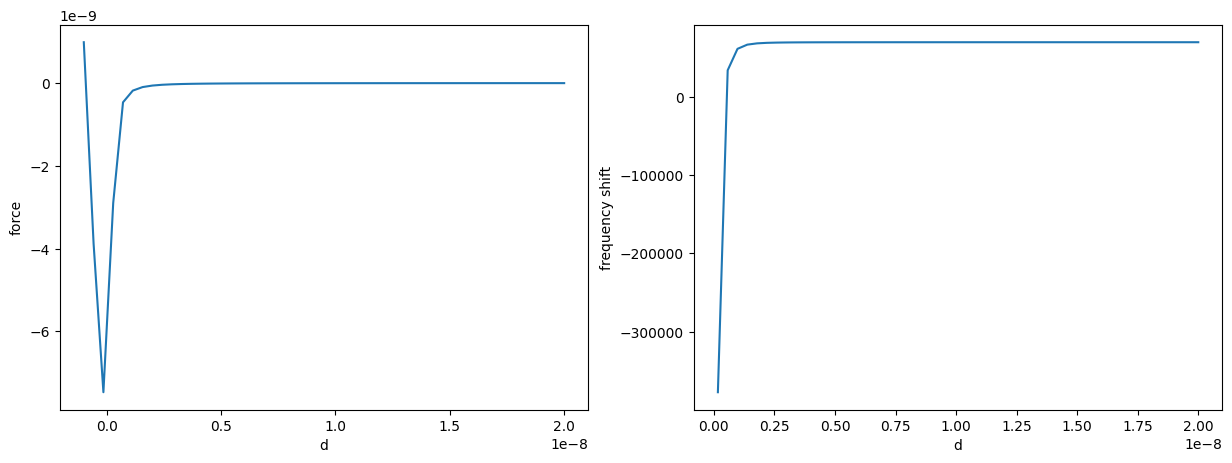

In [164]:

kc = 2 #cantilever spring constant (N/m)
fc = 70e3 #cantilever resonance frequency (Hz)
Qc = 130 #cantilever Q factor (free)
fd_ini = 68e3 #drive frequency (Hz)
F0 = 1.6e-10 #drive amplitude (m)

d0_far = 20e-9 #tip-sample rest distance, far (m)
d0_near = 10e-9 #tip-sample rest distance, near (m)
d0_pts = 50 #number of points for force-distance
d0_list = np.linspace(d0_far, d0_near, d0_pts) #[8e-9, 7e-9, 6e-9] #tip-sample distance, rest (m)
# d0_list = d0_far + (d0_near - d0_far) * (np.linspace(0, 1, d0_pts))**(1/4) # = np.logspace(np.log(d0_far)/np.log(3),np.log(d0_near)/np.log(3),d0_pts, base=3)

R = 20e-9 #tip radius (m)
H = 7.1e-20 #Hamaker constant (J)
Y = 35e-3 #surface energy of sample (mJ/m2)
# a0 = 1e-10 #intermolecular distance (m)
E_s = 1.2e9 #elastic modulus of sample (Pa)
nu_s = 0.3 #poisson ratio of sample
E_t = 130e9 #elastic modulus of tip (Pa)
nu_t = 0.3 #poisson ratio of tip
E = 1/(((1-nu_s**2)/E_s)+((1-nu_t**2)/E_t))

a0 = np.sqrt(H/(24*np.pi*Y)) #intermolecular distance (obtained by balancing vdW and  DMT adhesion)
wc = 2*np.pi*fc #angular resonance frequency of cantilever
mc = kc/(wc**2) #cantilever mass
wd_ini = 2*np.pi*fd_ini #angular drive frequency
gamma = wc/Qc #damping coefficient, b/m (dimensionless)
amp_res = F0/(mc*gamma*wc) #theoretical free amplitude at resonance (far away)
amp_ini = F0/(mc*np.sqrt((wc**2-wd_ini**2)**2+(gamma*wc)**2)) #theoretical free amplitude at fd_ini (far away)
phase_ini = np.arctan2(gamma*wd_ini, wc**2-wd_ini**2)*180/np.pi if wc != wd_ini else 90
# freq_res = 300 #frequency resolution (Hz)
# phase_res = 0.1 #phase resolution (deg)

#numerical method parameters
# t0 = 0 #readjust this!
# v0 = 0 #check readjustment!
# x0 = F0/(mc*gamma*wc) #theoretical free amplitude at resonance (far away)
fs = 500*fc #10*wc*np.pi/(phase_res*180)  # Sampling frequency in Hz
dt = 1/fs #1/fd/20
n_osci = 1000#int(fd/freq_res) #number of oscillations
ss_osci = 100#int(n_osci/3) #number of steady state osci at end
t_end = n_osci/fd_ini #0.006 #dt*n_samples
# phase_tol = 0.1 #tolerance for zero phase (deg)
fd_step = 10 #initial freq step size (Hz) to calculate bounds for wd in bisection section (PLL simulation)
fd_tol = 1 #tolerance for freq convergence
phase_zero = 0.1 #tolerance for zero phase (deg)
freq_window = 2*fd_ini/ss_osci #Hz for finding resonance peak
# print(freq_window)
#macro variables for faster numerical calculation
wc2 = wc**2
F02 = F0/mc
F_el0 = (4/3)*E*np.sqrt(R)
F_vdw_adh = -H*R/(6*(a0**2))
F_vdw0 = -H*R/6
# d_i = 0 

# def RungeKuttaCoupled(x, y, z, dx, dydx, dzdx):
    
#     k1 = dx*dydx(x, y, z)
#     h1 = dx*dzdx(x, y, z)
#     k2 = dx*dydx(x+dx/2., y+k1/2., z+h1/2.)
#     h2 = dx*dzdx(x+dx/2., y+k1/2., z+h1/2.)
#     k3 = dx*dydx(x+dx/2., y+k2/2., z+h2/2.)
#     h3 = dx*dzdx(x+dx/2., y+k2/2., z+h2/2.)
#     k4 = dx*dydx(x+dx, y+k3, z+h3)
#     h4 = dx*dzdx(x+dx, y+k3, z+h3)

#     y = y + 1./6.*(k1+2*k2+2*k3+k4)
#     z = z + 1./6.*(h1+2*h2+2*h3+h4)
#     x = x + dx
    
#     return x, y, z
#Runge-Kutta method for 2nd order differential equation, coupled as 2 first order differential eqs.
@njit
def RungeKuttaCoupled(x, y, z, dx, dydx, dzdx, d0, wd):#**kwargs):
    # Compute the Runge-Kutta steps
    k1 = dx * dydx(x, y, z, d0, wd)#**kwargs)
    h1 = dx * dzdx(x, y, z)
    k2 = dx * dydx(x + dx / 2., y + k1 / 2., z + h1 / 2., d0, wd)#**kwargs)
    h2 = dx * dzdx(x + dx / 2., y + k1 / 2., z + h1 / 2.)
    k3 = dx * dydx(x + dx / 2., y + k2 / 2., z + h2 / 2., d0, wd)#**kwargs)
    h3 = dx * dzdx(x + dx / 2., y + k2 / 2., z + h2 / 2.)
    k4 = dx * dydx(x + dx, y + k3, z + h3, d0, wd)#**kwargs)
    h4 = dx * dzdx(x + dx, y + k3, z + h3)

    # 4th order estimate
    y4 = y + 1. / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
    z4 = z + 1. / 6. * (h1 + 2 * h2 + 2 * h3 + h4)
    
    # Using additional coefficients for the 5th order estimate
    # b_star = [16 / 135, 0, 6656 / 12825, 28561 / 56430, -9 / 50, 2 / 55]
    # y5 = y + b_star[0] * k1 + b_star[2] * k2 + b_star[3] * k3 + b_star[4] * k4
    # z5 = z + b_star[0] * h1 + b_star[2] * h2 + b_star[3] * h3 + b_star[4] * h4

    # # Calculate the error
    # error_y = np.abs(y5 - y4)
    # error_z = np.abs(z5 - z4)

    # Update the new values for y and z using the 4th order estimate
    y = y4
    z = z4
    x = x + dx

    return x, y, z#, error_y, error_z

#tip-sample interaction force vs distance
@njit
def force_ts(d):
    if d >= a0:
        F_vdw = F_vdw0/(d**2)#-H*R/(6*(d**2))
        F_elas = 0
    else:
        F_vdw = F_vdw_adh #-H*R/(6*(a0**2)) #vdW adhesion
        F_elas = F_el0*(a0-d)**(3/2) #CHECK THIS
    return F_vdw + F_elas

@njit
def dvdt(t, v, x, d0, wd):#**kwargs):
    # d0 = kwargs['d0']
    # wd = kwargs['wd']
    # print(d0, wd)
    # global d0_i
    # global wd
    # d0 = d0_list[d0_i]
    d_t = d0 + x #instantaneous tip sample distance
    F_ts = force_ts(d_t)
    # if d_t >= a0:
    #     F_vdw = -H*R/(6*(d_t**2))
    #     F_elas = 0
    # else:
    #     F_vdw = -H*R/(6*(a0**2))
    #     F_elas = (4/3)*E*np.sqrt(R)*(a0-d_t)**(3/2) #CHECK THIS
    # F_ts = F_vdw + F_elas
    return -(wc2*x)-(gamma*v)+(F_ts/mc)+(F02*np.cos(wd*t))

# def dvdt_free(t, v, x):
#     global d0_i
#     d0 = d0_list[d0_i]
#     d_t = d0 + x #instantaneous tip sample distance
#     F_ts = force_ts(d_t)
#     # if d_t >= a0:
#     #     F_vdw = -H*R/(6*(d_t**2))
#     #     F_elas = 0
#     # else:
#     #     F_vdw = -H*R/(6*(a0**2))
#     #     F_elas = (4/3)*E*np.sqrt(R)*(a0-d_t)**(3/2) #CHECK THIS
#     # F_ts =  F_vdw + F_elas
#     return -(wc2*x)-(gamma*v)+(F_ts/mc)#+((F0/mc)*np.cos(wd*t))

@njit
def dxdt(t, v, x):
    return v

# @njit
# def get_fft(input_array):
#     fft_out = np.fft.fft(input_array)
#     return np.fft.fftshift(fft_out) 

# @njit
# def get_fft_freq(num_samples, delta_t):
#     freq_out = np.fft.fftfreq(num_samples, delta_t)
#     return np.fft.fftshift(freq_out) 

@njit
def main_computation(v, x, t0, t_end, dt, d0, wd):
    len_full = int(t_end/dt)
    t = t0
    t_list = np.zeros(len_full, dtype=np.float64)
    v_list = np.zeros(len_full, dtype=np.float64)
    x_list = np.zeros(len_full, dtype=np.float64)
    t_list[0] = t
    v_list[0] = v
    x_list[0] = x
    i = 1
    while t <= t_end + t0:
        t, v, x = RungeKuttaCoupled(t, v, x, dt, dvdt, dxdt, d0, wd)
        t_list[i] = t
        v_list[i] = v
        x_list[i] = x
        i += 1
    return t_list, v_list, x_list

#solve
# @njit
def solve_harmonic(v, x, t0, d0, wd):#**kwargs):
    # t = t0 #kwargs['t0']#t0
    # len_full = int(t_end/dt)
    # t_list = np.zeros(len_full, dtype=np.float64) #[t]
    # v_list = np.zeros(len_full, dtype=np.float64) #[v]
    # x_list = np.zeros(len_full, dtype=np.float64) #[x]
    # t_list[0] = t
    # v_list[0] = v
    # x_list[0] = x
    # # err_v_list = [0]
    # # err_x_list = [0]
    # print('start', d0, wd, t0, t_end)
    # i = 1
    # while t <= t_end+t0: #kwargs['t0']:
    #     t, v, x = RungeKuttaCoupled(t, v, x, dt, dvdt, dxdt, d0, wd)#**kwargs)  #, err_v, err_x     
    #     # t_list.append(t)
    #     # v_list.append(v)
    #     # x_list.append(x)
    #     t_list[i] = t
    #     v_list[i] = v
    #     x_list[i] = x
    #     i += 1
    #     # err_v_list.append(err_v)
    #     # err_x_list.append(err_x)
    # print('fin', d0, wd, t)
    # ss_osci = 100 #number of steady state osci at end
    # wd = kwargs['wd']
    # t_list = np.array(t_list)
    # v_list = np.array(v_list)
    # x_list = np.array(x_list)
    t_list, v_list, x_list = main_computation(v, x, t0, t_end, dt, d0, wd)
 
    fd = wd/(2*np.pi)
    ss_index = -int(ss_osci*fs/fd)
    ss_t_list = t_list[ss_index:]
    ss_x_list = x_list[ss_index:]
    n_samples = len(ss_t_list)
    
    # x_list = F0*np.cos(wd*np.array(t_list))
    # FT_omega = np.zeros(n_samples, dtype=np.float64) 
    # with objmode(FT_omega='float64[:]'): 
    FT_omega = np.fft.fftfreq(n_samples, ss_t_list[1] - ss_t_list[0])
    FT_omega = np.fft.fftshift(FT_omega)
    # FT = np.zeros(n_samples, dtype=np.complex128) 
    # with objmode(FT='complex128[:]'):        
    FT = np.fft.fft(ss_x_list)
    FT = np.fft.fftshift(FT)
    # FT_omega = get_fft_freq(n_samples, ss_t_list[1] - ss_t_list[0])
    # FT = get_fft(ss_x_list)
    
    FT_amplitude = np.abs(FT)*2/n_samples
    
    fpeak_range = (int(n_samples/2) + np.argmin(np.abs(FT_omega[int(n_samples/2):]-(fd-freq_window))),
                   int(n_samples/2) + np.argmin(np.abs(FT_omega[int(n_samples/2):]-(fd+freq_window))))
    # print(fpeak_range, n_samples/2)
    f_index = fpeak_range[0] + np.argmax(FT_amplitude[fpeak_range[0]: fpeak_range[1]])
    # f_index = int(n_samples/2) + np.argmax(FT_amplitude[int(n_samples/2):])
    amplitude = FT_amplitude[f_index]
    deflection = np.mean(ss_x_list)
    # print(FT_omega[f_index])

    x_drive = F0*np.cos(wd*np.array(ss_t_list))
    # FTdrive = np.zeros(n_samples, dtype=np.complex128) 
    # with objmode(FT_drive='complex128[:]'):
    FT_drive = np.fft.fft(x_drive)
    FT_drive = np.fft.fftshift(FT_drive)
    # FT_drive = get_fft(x_drive)
    phase = np.angle(FT_drive[f_index])-np.angle(FT[f_index])
    # phase = np.pi
    # Normalize phase to be within [0, 2π]
    phase = np.mod(phase, 2 * np.pi)    
    # Adjust phase to be within [0, π]
    if phase > np.pi:
        phase -= np.pi
    phase = phase*180/np.pi #in degrees
    #set initial conditions for next iteration
    # x = amplitude
    # v = 0
    # t_end += n_osci/fd #final time

    #plot simulated data
    # fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # ax[0].plot(t_list, x_list, color='blue')
    # ax[0].plot(ss_t_list, ss_x_list, color='yellow')
    # ax[0].plot(ss_t_list, x_drive, color='red')
    # ax[0].axhline(0, linestyle=':', color='k')
    # ax[1].plot(FT_omega, FT_amplitude, color='blue')
    # ax[1].plot(FT_omega[f_index], FT_amplitude[f_index], 'x', color='red')
    # ax[1].set_xlim(-5*fc, 5*fc)
    # ax[1].ticklabel_format(axis='x', style='sci', scilimits=(-4,4))
    # plt.show()
    
    return amplitude, phase, deflection, t_list, v_list, x_list#, err_v_list, err_x_list

print("Resonance amplitude:", amp_res)
print("Initial amplitude:", amp_ini)
print("Initial phase:", phase_ini)

d0_plotarray1 = np.linspace(-1e-9, d0_list[0], 50)
force_data = [force_ts(d0_plot_i) for d0_plot_i in d0_plotarray1]
d0_plotarray2 = np.linspace(a0, d0_list[0], 50)
dF_vdw = 2*H*R/(6*(d0_plotarray2**3))
delta_f = fc*(1-np.sqrt(1+(dF_vdw/kc))) #theoretical freq shift assuming linear harmonic osci

fig1, ax1 = plt.subplots(1, 2, figsize=(15,5))
ax1[0].plot(d0_plotarray1, force_data,  label='freq shift')
ax1[1].plot(d0_plotarray2, fc+delta_f, label='freq shift')
ax1[0].set_xlabel("d")
ax1[1].set_xlabel("d")
ax1[0].set_ylabel("force")
ax1[1].set_ylabel("frequency shift")
plt.show()

7.5466334499748e-10 1.50932668999496e-09 4.314308232578055e-09 8.030332154956643e-26


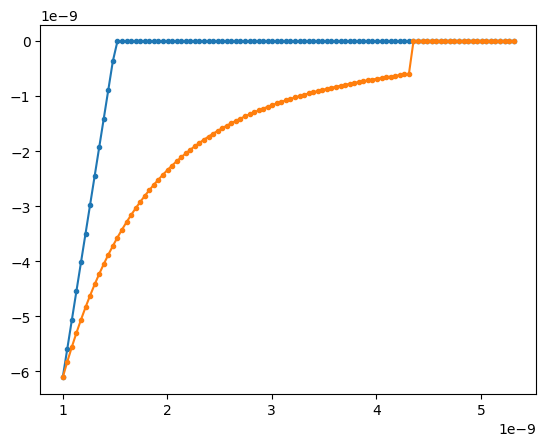

In [247]:
theta_s = 0 #contact angle with sample (deg)
theta_t = 0 #contact angle with tip (deg)
humid = 0.5 #humidity
T_temp = 298 #Temperature (K)
R_gas = 8.314 #Ideal gas constant (J/K⋅mol)
surf_ten = 72e-3 #surface tension (N/m)
dens = 1000 #density (kg/m3)
mol_wt = 18e-3 #molecular wt (kg/mol)

mol_vol = mol_wt/dens
kelv_len = (surf_ten*mol_vol)/(R_gas*T_temp)
rm_eq = -kelv_len/np.log(humid) #equilibrium meniscus radius (for constant pressure)
c_theta = 0.5*(np.cos(theta_s*np.pi/180)+np.cos(theta_t*np.pi/180))
# print(rm_eq)

d_near = 1e-9
d_jumpin = 2*c_theta*rm_eq
if d_near < d_jumpin: #liquid neck exists when closer than jumpin distance
    vol_near = np.pi*R*((4*(rm_eq*c_theta)**2)-(d_near**2))
    d_rupt = (1+(0.5*np.arccos(c_theta)))*(vol_near**(1/3))
else: #no liquid neck assumed
    vol_near = 0
    d_rupt = 3e-9

if d_rupt < d_jumpin: #no liquid neck assumed here
    d_jumpin = 0
    
d = np.linspace(d_near, d_rupt+1e-9, 100)


# print(vol_near)
# rm_cv = (1/(2*c_theta))*np.sqrt((vol_near/(np.pi*R))+(d**2)) #meniscus radius at d (for constant volume)

print(rm_eq, d_jumpin, d_rupt, vol_near)
# cos_beta = 1-(((2*rm_cv*c_theta)-d)/R)
# sin_beta = np.sqrt(1-(cos_beta**2))
# cos_theta_beta = (cos_beta*np.cos(theta_t*np.pi/180))-(sin_beta*np.sin(theta_t*np.pi/180))
# r_neck = (R*sin_beta) - (rm_cv*(1-cos_theta_beta))

F_cap_cp = -2*np.pi*surf_ten*R*((2*c_theta)-(d/rm_eq))
F_cap_cv = -4*np.pi*surf_ten*c_theta*R*(1-(d/np.sqrt((d**2)+(vol_near/(np.pi*R)))))

F_cap_cp[np.argwhere(d>d_jumpin)] = 0
F_cap_cv[np.argwhere(d>d_rupt)] = 0

plt.plot(d, F_cap_cp, '.-')
plt.plot(d, F_cap_cv, '.-')
plt.show()
# (vol_near/(2*np.pi*2e-9))**(1/2), r_neck

In [224]:
cos_beta = 1-(((2*rm_cv*c_theta)-d)/R)
sin_beta = np.sqrt(1-(cos_beta**2))
cos_theta_beta = (cos_beta*np.cos(theta_t*np.pi/180))-(sin_beta*np.sin(theta_t*np.pi/180))
r_neck = (R*sin_beta) - (rm_cv*(1-cos_theta_beta))
r_neck
# (2*rm_cv*c_theta)
# cos_beta
# rm_cv = (1/(2*c_theta))*np.sqrt((vol_near/(np.pi*R))+(d**2))
# rm_cv, vol_near


array([[12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],
       [77],
       [78],
       [79],
       [80],
       [81],
       [82],
       [83],
       [84],
       [85],
       [86],
       [87],
       [88],

#### Spectroscopy

finished


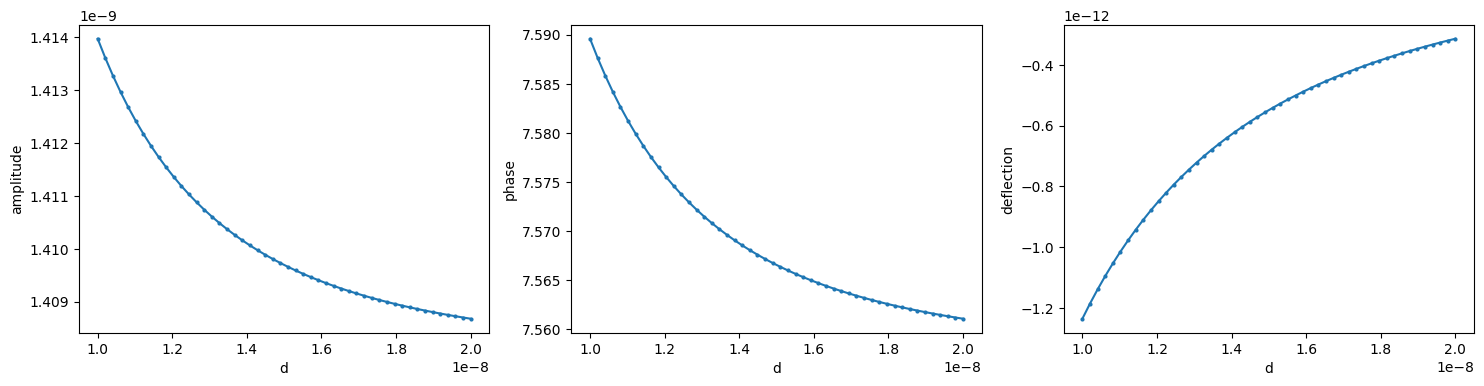

saved


In [165]:
# d0_far = 12e-9 #tip-sample rest distance, far (m)
# d0_near = 2.5e-9 #tip-sample rest distance, near (m)
# d0_pts = 20 #number of points for force-distance
# d0_list = np.linspace(d0_far, d0_near, d0_pts) #[8e-9, 7e-9, 6e-9] #tip-sample distance, rest (m)
# d0_list = d0_far + (d0_near - d0_far) * (np.linspace(0, 1, d0_pts))**(1/3) # = np.logspace(np.log(d0_far)/np.log(3),np.log(d0_near)/np.log(3),d0_pts, base=3)   

# t0 = (phase_ini*np.pi/180)/wd_ini #if abs(phase_ini) > phase_zero else 0 #readjust this!
# v0 = 0 #check readjustment!
# x0 = amp_ini  #F0/(mc*gamma*wc) #theoretical free amplitude at resonance (far away)

# t_list = [t0]
# v_list = [v0]
# x_list = [x0]

# err_v_list = [0]
# err_x_list = [0]
# v_free_list = [v0]
# x_free_list = [x0]

# t = t0
# v = v0
# x = x0

# t_free = t0
# v_free = v0
# x_free = x0

# while t <= t_end:
    
#     t, v, x = RungeKuttaCoupled(t, v, x, dt, dvdt, dxdt)
    
#     t_list.append(t)
#     v_list.append(v)
#     x_list.append(x)

# fs = 10*fd  # Sampling frequency in Hz (steady state osci)
# dt = 1/fs #time step
# ss_osci = 400 #number of steady state osci at end
# t_end += ss_osci/fd #final time
# colors = plt.cm.Wistia_r(np.linspace(0,1,len(d0_list)))
# fig1, ax1 = plt.subplots(2, 2, figsize=(12,12))
# @njit
def run_simulation(params):
    # print(x0, v0)
    # print(kc, fc, wd_ini)
    # get the start time
    # exec_time = time.time()
    # print('here')
    phase_tol = params['phase_tol']
    # global phase
    # phase = 90
    v = 0 #v0
    x = amp_ini #x0
    t = (phase_ini*np.pi/180)/wd_ini #t0
    wd = wd_ini
    simu_datadict = {'d': [], 'amplitude': [], 'phase': [], 'frequency': [], 'deflection': []}
    # simu_datadict = [[], [], [], [], []]

    # print('start')
    for d0_i in d0_list:
        # while t <= t_end:
        #     # t_free, v_free, x_free = RungeKuttaCoupled(t_free, v_free, x_free, dt, dvdt_free, dxdt)
        #     # v_free_list.append(v_free)
        #     # x_free_list.append(x_free)
    
        #     t, v, x, err_v, err_x = RungeKuttaCoupled(t, v, x, dt, dvdt, dxdt)        
        #     t_list.append(t)
        #     v_list.append(v)
        #     x_list.append(x)
        #     err_v_list.append(err_v)
        #     err_x_list.append(err_x)
        # # print('rk done')
        # print(x,v,t)
        amplitude, phase, deflection, t_list, v_list, x_list = solve_harmonic(v, x, t0=t, d0=d0_i, wd=wd) #, err_v_list, err_x_list
        # print('yo')
        # #set initial conditions for next iteration
        # x = amplitude
        # v = 0    
        # def func_harm(wd_x):
        #     global amplitude
        #     global phase
        #     amplitude, phase, t_list, v_list, x_list = solve_harmonic(v, x, d0=d0_i, wd=wd_x)
        #     print('brent', amplitude, phase, phase-90, (wd_x/(2*np.pi))-fc)
        #     return phase-90        
        wd_up = wd
        wd_low = wd-(2*np.pi*fd_step) if phase >=90 else wd+(2*np.pi*fd_step)
        # wd_up = wd+(2*np.pi*fd_step)
        # wd_low = wd-(2*np.pi*fd_step)

        # func_harm = lambda wd_x: solve_harmonic(v, x, d0=d0_i, wd=wd_x)
        # wd = brentq(func_harm, wd_up, wd_low, xtol=1)
        # print(d0_i, wd/(2*np.pi), wd_up/(2*np.pi), wd_low/(2*np.pi))
        #set initial conditions for next iteration
        # x = amplitude
        # v = 0  
        # # wd_low = wd-(2*np.pi*fd_step)
        phase_up = phase
        if abs(phase-90) >= phase_tol:
            # wd_low = wd+(2*np.pi*fd_step) if phase >=90 else wd-(2*np.pi*fd_step)
            # wd_low = wd+(2*np.pi*fd_step)
            # wd = wd_low
            harm_output = solve_harmonic(v, x, t0=t, d0=d0_i, wd=wd_low)
            # x = amplitude
            # v = 0
            phase_low = harm_output[1]
            print('ini', phase_low, phase_up, wd_low/(2*np.pi), wd_up/(2*np.pi))
        #iter_max = 5
        iter_i = 0
        reini_count = 1
        while abs(phase-90) >= phase_tol:
            print(phase_tol)
            iter_i += 1
            # print('bisection', amplitude, phase, phase-90, (wd/(2*np.pi))-fc, (wd_up/(2*np.pi))-fc, (wd_low/(2*np.pi))-fc)
            phase_opp_sign =  np.sign((phase_up-90)*(phase_low-90))
            
            # if iter_i > 5:
            if phase_opp_sign == 1:
                phasemin_check = np.array([[abs(phase_up-90), phase_up, wd_up], 
                                           [abs(phase_low-90), phase_low, wd_low]])
                phasemin_sort = phasemin_check[phasemin_check[:,0].argsort()]
                phase_up, wd_up = phasemin_sort[0][1], phasemin_sort[0][2]
                # wd_up = wd
                # phase_up = phase
                wd_low = wd_up-(2*np.pi*fd_step*(reini_count**2)) if phase_up >=90 else wd_up+(2*np.pi*fd_step*(reini_count**2))
                harm_output = solve_harmonic(v, x, t0=t, d0=d0_i, wd=wd_low)
                phase_low = harm_output[1]
                if abs(phase_low-90) < phase_tol:
                    amplitude, phase = harm_output[0], harm_output[1]
                    fd = wd/(2*np.pi) #update frequency value
                    simu_datadict['d'].append(d0_i)
                    simu_datadict['amplitude'].append(amplitude)
                    simu_datadict['phase'].append(phase)
                    simu_datadict['frequency'].append(fd)
                    simu_datadict['deflection'].append(deflection)
                    # exec_time_new = time.time()
                    # exec_time_diff = exec_time_new-exec_time
                    print('RESULT', d0_i, amplitude, phase, fc-fd, phase_tol)#, exec_time_diff)# freq_peak-FT_omega[f_index]) (max(ss_x_list)-min(ss_x_list))/2
                    # ax1[0][1].plot(t_list[-n_samples:], x_list[-n_samples:], label="cantilever", color=colors[d0_i])
                    # exec_time = exec_time_new
                    
                    #set initial conditions for next iteration
                    x = amplitude
                    v = 0  
                    break
                # wd, phase = wd_low, phase_low
                print('reinit', phase_up, phase_low, reini_count)
                reini_count += 1
                continue
            
            reini_count = 1
            wd_old = wd
            phase_old = phase
            wd = (wd_up + wd_low)/2 #bisection
            # iter_i = 0
            print('bisection', amplitude, phase, phase-90, (wd/(2*np.pi))-fc, (wd_up/(2*np.pi))-fc, (wd_low/(2*np.pi))-fc)
            # else:
            # # wd = wd-(2*np.pi*fd_step) if phase >=90 else wd+(2*np.pi*fd_step) #binary search
            #     wd = wd_low - (phase_low * (wd_low - wd_up) / (phase_low - phase_up)) #secant method
            #     print('secant', amplitude, phase, phase-90, (wd/(2*np.pi))-fc, (wd_up/(2*np.pi))-fc, (wd_low/(2*np.pi))-fc)
            amplitude, phase, deflection, t_list, v_list, x_list = solve_harmonic(v, x, t0=t, d0=d0_i, wd=wd) #err_v_list, err_x_list
            phase_step = abs(phase_old-phase)
            print('step', iter_i, phase_step, (wd_old/(2*np.pi))-fc, (wd/(2*np.pi))-fc, phase_up, phase_low)

            if abs(wd_old-wd) < fd_tol*2*np.pi:
                print('break')
                break
            # if phase >= 90:
            #     print('greater', phase)
            #     fd_step = 2*fd_step
            #     x = amplitude
            #     v = 0
            # else:
            #     print('lesser', phase)
            #     fd_step = fd_step/4
            #     wd = wd_old
            #     phase = phase_old            
                
            # wd_up, wd_low = wd_low, wd
            # phase_up, phase_low = phase_low-90, phase-90
            #if phase_step < phase_tol:
            # phase_opp_sign = (phase_old-90)*(phase-90) #find if first two phase steps are above and below 90 (for bisection method)
            # if iter_i == 1 and np.sign(phase_opp_sign) == 1:
            #     wd_up = wd
            #     wd_low = wd-(2*np.pi*fd_step) if phase >=90 else wd+(2*np.pi*fd_step)
            #     iter_i = 0
            #     continue
            # else:
            # if phase_step < phase_tol:
            
            # else:
            # if iter_i > 5: #bisection
            if phase >=90:
                wd_up = wd
                phase_up = phase
            else:
                wd_low = wd
                phase_low = phase
            # else: #secant
            #     if (phase_old < 90 and phase < 90 and phase < phase_old) or (phase_old > 90 and phase > 90 and phase > phase_old):
            #         print('reset')
            #         wd_up = wd
            #         phase_up = phase -90
            #         wd_low = wd-(2*np.pi*fd_step) if phase >=90 else wd+(2*np.pi*fd_step)
            #         harm_output = solve_harmonic(v, x, d0=d0_i, wd=wd_low)
            #         phase_low = harm_output[1] - 90
            #     else:
            #         wd_up, wd_low = wd_low, wd
            #         phase_up, phase_low = phase_low-90, phase-90
            # #set initial conditions for next iteration
            # x = amplitude
            # v = 0
        
        # t_end += n_osci/fd #final time
        # # t_free = t0
        # # v_free = v0
        # # x_free = x0
        # # v = 0
        
        # # ss_osci = 100 #number of steady state osci at end
        # ss_index = -int(ss_osci*fs/fd)
        # ss_t_list = t_list[ss_index:]
        # ss_x_list = x_list[ss_index:]
        # n_samples = len(ss_t_list)
        # # plt.plot(t_list, x_list, ':', label="steady", color="yellow")
        # # plt.xlabel("Time")
        # # plt.ylabel("Position")
        # # plt.legend(loc="best")
        # # plt.show()
        
        # # x_list = F0*np.cos(wd*np.array(t_list))
        # FT_omega = np.fft.fftfreq(n_samples, ss_t_list[1] - ss_t_list[0])
        # FT = np.fft.fft(ss_x_list)
        # FT_omega = np.fft.fftshift(FT_omega)
        # FT = np.fft.fftshift(FT)
        # FT_amplitude = np.abs(FT)*2/n_samples
        # # plt.subplot(1,1,1)
        # ax1[0][0].plot(FT_omega, FT_amplitude, '.-', color=colors[d0_i])
        # # plt.plot(FT_omega[peak_ind], FT_amplitude[peak_ind], "x")
        # # plt.grid(True)
        # # ax2[0].set_xlim(0,2*fc)
        # ax1[0][0].set_xlim(fc-3000, fc+3000)#(fc-freq_window,fc+freq_window)
        # # plt.title('Fourier Transform')
        # # plt.tight_layout()
        # # plt.show()
        
        # # index, = np.where(np.isclose(FT_omega, fd, atol=100))
        # f_index = int(n_samples/2) + np.argmax(FT_amplitude[int(n_samples/2):]) #np.argmin(abs(FT_omega-fd))
        # # print(f_index, FT_omega[f_index], n_samples) #FT_omega[index[0]],
        # ax1[0][0].plot(FT_omega[f_index], FT_amplitude[f_index], "x", color=colors[d0_i])
        # amplitude = FT_amplitude[f_index] #np.abs(FT[f_index])*2/n_samples
    
        # x_drive = F0*np.cos(wd*np.array(ss_t_list))
        # FT_drive = np.fft.fft(x_drive)
        # FT_drive = np.fft.fftshift(FT_drive)
        # phase = (np.angle(FT_drive[f_index])-np.angle(FT[f_index]))*180/np.pi
        # fd_old = fd
        fd = wd/(2*np.pi) #update frequency value
        # fd_step = 10*abs(fd_old-fd) #dynamically update frequency step for faster convergence
        # n_samples = int(fs*n_osci/fd)
        # FT_omega_free = np.fft.fftfreq(n_samples, t_list[1] - t_list[0])
        # FT_free = np.fft.fft(x_free_list[-n_samples:]-np.mean(x_free_list[-n_samples:]))
        # FT_omega_free = np.fft.fftshift(FT_omega_free)
        # FT_free = np.fft.fftshift(FT_free)
        # # plt.plot(t_list[-n_samples:], x_free_list[-n_samples:], label="cantilever", color="blue")
        # # plt.show()
        # f_index_free = np.argmin(abs(FT_omega_free-fc))
        # fwindow_ind = int(freq_window/(FT_omega_free[1]-FT_omega_free[0]))
        # FT_amplitude_free = np.abs(FT_free)*2/n_samples
        # peak_ind, _ = find_peaks(FT_amplitude_free[f_index_free-fwindow_ind:f_index_free+fwindow_ind])#, prominence=F0)#, width=20)
        # peak_ind = peak_ind + f_index_free-fwindow_ind
        # # plt.subplot(1,2,1)
        # ax1[0].plot(FT_omega_free, FT_amplitude_free, '.-', color=colors[d0_i])
        # ax1[0].plot(FT_omega_free[peak_ind], FT_amplitude_free[peak_ind], "x", color=colors[d0_i])
        # ax1[0].grid(True)
        # # ax1[0].set_xlim(0,2*fc)
        # ax1[0].set_xlim(fc-freq_window,fc+freq_window)
    
        # ax1[1].plot(t_list[-n_samples:], x_free_list[-n_samples:], label=d0_i, color=colors[d0_i])
        # plt.title('Fourier Transform')
        # plt.tight_layout()
        # plt.show()
        # print(peak_ind)
        # freq_peak = FT_omega_free[peak_ind[-1]]
        # print((max(ss_x_list)-min(ss_x_list))/2, fc-freq_peak, 2*Qc/wc)
        simu_datadict['d'].append(d0_i)
        simu_datadict['amplitude'].append(amplitude)
        simu_datadict['phase'].append(phase)
        simu_datadict['frequency'].append(fd)
        simu_datadict['deflection'].append(deflection)
        # simu_datadict[0].append(d0_i)
        # simu_datadict[1].append(amplitude)
        # simu_datadict[2].append(phase)
        # simu_datadict[3].append(fd)
        # simu_datadict[4].append(deflection)
        # exec_time_new = time.time()
        # exec_time_diff = exec_time_new-exec_time
        # print('RESULT', d0_i, amplitude, phase, fc-fd, deflection)#, exec_time_diff)# freq_peak-FT_omega[f_index]) (max(ss_x_list)-min(ss_x_list))/2
        # ax1[0][1].plot(t_list[-n_samples:], x_list[-n_samples:], label="cantilever", color=colors[d0_i])
        # exec_time = exec_time_new
        
        #set initial conditions for next iteration
        x = deflection + amplitude if (d0_i+deflection-a0) > amplitude else (d0_i+deflection-a0)
        v = 0
        t = (phase*np.pi/180)/wd #if abs(phase) > phase_zero else 0
    return simu_datadict

# results = run_simulation(params=1e6)
if __name__ == "__main__":
    params = [
        # {'phase_tol': 1},
        {'phase_tol': 1e6},
        # (1e6)
        ]

    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(run_simulation, params)

print('finished')
simu_results = results
spectro_datadf = pd.DataFrame(simu_results[0]) 

# plt.legend(loc="best")
# xdrive_list = F0*np.cos(wd*np.array(t_list))
# ax1[0][1].plot(t_list, xdrive_list, label="drive", color="red")

# ax1[1][0].plot(err_v_list)
# ax1[1][1].plot(err_x_list)
# # ax2[0].set_xlim(fc-1000, fc+1000)
# plt.show()
# plt.subplot(1,1,1)
# plt.title("Cantilever oscillation")
# plt.plot(t_list, x_list, label="cantilever", color="blue")
# plt.plot(t_list, xdrive_list, label="drive", color="red")
# plt.show()
fig2, ax2 = plt.subplots(1, 3, figsize=(18,4))
sns.lineplot(data=spectro_datadf, x='d', y='amplitude', ax=ax2[0], marker='.', markeredgewidth=0)
sns.lineplot(data=spectro_datadf, x='d', y='phase', ax=ax2[1], marker='.', markeredgewidth=0)
sns.lineplot(data=spectro_datadf, x='d', y='deflection', ax=ax2[2], marker='.', markeredgewidth=0)
plt.show()

# timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
# spectro_datadf.to_csv(f'data/cantisimu_spectro_datadf_fd_{fd_ini:1.0e}_kc_{kc}_d0pts_{d0_pts}_{timestamp}.csv')
# fig2.savefig(f'data/cantisimu_spectro_fd_{fd_ini:1.0e}_kc_{kc}_d0pts_{d0_pts}_{timestamp}.png', dpi=300, bbox_inches='tight')
# print('saved')

In [76]:
# timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
# spectro_datadf.to_csv(f'data/cantisimu_spectro_datadf_fd_{fd_ini:1.0e}_kc_{kc}_d0pts_{d0_pts}_{timestamp}.csv')
# print('saved')
# !pip show numba

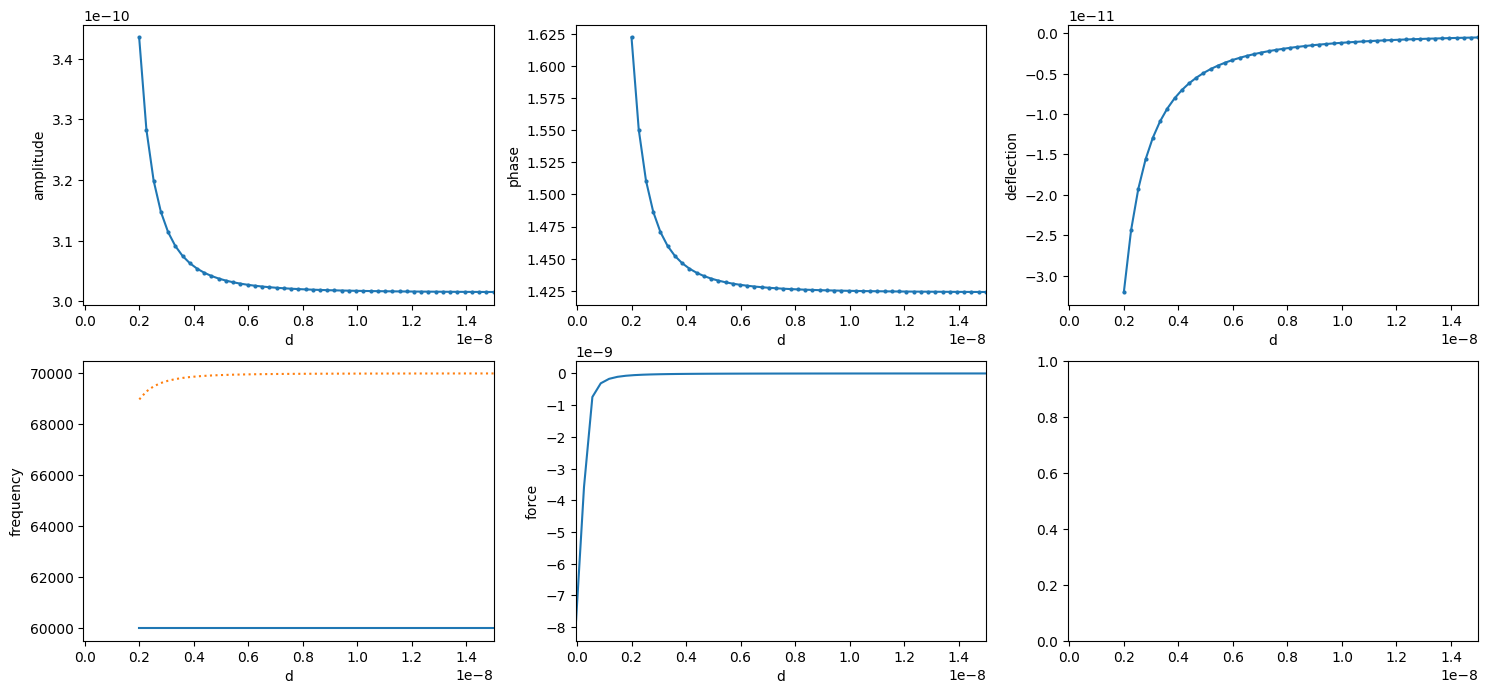

In [8]:
spectro_datadict = simu_results[0]
fig2, ax2 = plt.subplots(2, 3, figsize=(18,8))
sns.lineplot(data=spectro_datadict, x='d', y='amplitude', ax=ax2[0][0], marker='.', markeredgewidth=0)
# plt.show()
sns.lineplot(data=spectro_datadict, x='d', y='phase', ax=ax2[0][1], marker='.', markeredgewidth=0)
# plt.show()
sns.lineplot(data=spectro_datadict, x='d', y='deflection', ax=ax2[0][2], marker='.', markeredgewidth=0)

sns.lineplot(data=spectro_datadict, x='d', y='frequency', ax=ax2[1][0])
dF_vdw = 2*H*R/(6*(np.array(spectro_datadict['d'])**3))
delta_f = fc*(1-np.sqrt(1+(dF_vdw/kc))) #theoretical freq shift assuming linear harmonic osci
ax2[1][0].plot(spectro_datadict['d'], fc+delta_f, ':', label='fit')
# plt.legend()
# plt.show()
force_list = []
d1_range = -0.05e-9, max(spectro_datadict['d'])
spectro_datadict['d1'] = np.linspace(d1_range[0],d1_range[1],50)
for d_t in spectro_datadict['d1']:
    if d_t >= a0:
        F_vdw = -H*R/(6*(d_t**2))
        F_elas = 0
    else:
        F_vdw = -H*R/(6*(a0**2))
        F_elas = (4/3)*E*np.sqrt(R)*(a0-d_t)**(3/2) #CHECK THIS
    F_ts = F_vdw + F_elas
    force_list.append(F_ts)

# F_vdw = -H*R/(6*(np.array(spectro_datadict['d'])**2))
ax2[1][1].plot(spectro_datadict['d1'], force_list)
ax2[1][1].set_xlabel("d")
ax2[1][1].set_ylabel("force")
for ax_i in ax2.flatten():
    ax_i.set_xlim(*d1_range)
plt.show()

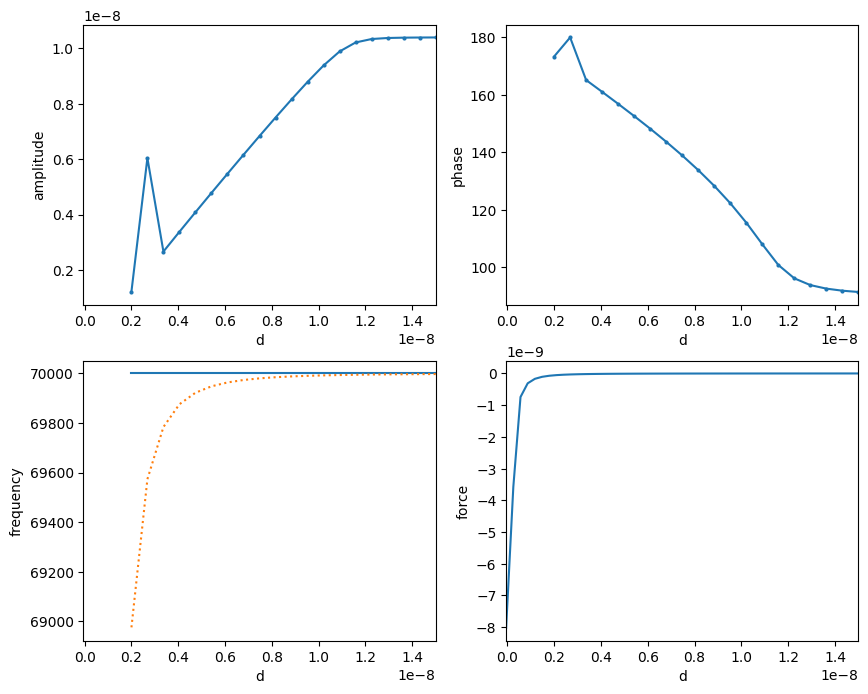

In [59]:
spectro_datadict = simu_results[0]
fig2, ax2 = plt.subplots(2, 2, figsize=(10,8))
sns.lineplot(data=spectro_datadict, x='d', y='amplitude', ax=ax2[0][0], marker='.', markeredgewidth=0)
# plt.show()
sns.lineplot(data=spectro_datadict, x='d', y='phase', ax=ax2[0][1], marker='.', markeredgewidth=0)
# plt.show()
sns.lineplot(data=spectro_datadict, x='d', y='frequency', ax=ax2[1][0])
dF_vdw = 2*H*R/(6*(np.array(spectro_datadict['d'])**3))
delta_f = fc*(1-np.sqrt(1+(dF_vdw/kc))) #theoretical freq shift assuming linear harmonic osci
ax2[1][0].plot(spectro_datadict['d'], fc+delta_f, ':', label='fit')
# plt.legend()
# plt.show()
force_list = []
d1_range = -0.05e-9, max(spectro_datadict['d'])
spectro_datadict['d1'] = np.linspace(d1_range[0],d1_range[1],50)
for d_t in spectro_datadict['d1']:
    if d_t >= a0:
        F_vdw = -H*R/(6*(d_t**2))
        F_elas = 0
    else:
        F_vdw = -H*R/(6*(a0**2))
        F_elas = (4/3)*E*np.sqrt(R)*(a0-d_t)**(3/2) #CHECK THIS
    F_ts = F_vdw + F_elas
    force_list.append(F_ts)

# F_vdw = -H*R/(6*(np.array(spectro_datadict['d'])**2))
ax2[1][1].plot(spectro_datadict['d1'], force_list)
ax2[1][1].set_xlabel("d")
ax2[1][1].set_ylabel("force")
for ax_i in ax2.flatten():
    ax_i.set_xlim(*d1_range)
plt.show()

In [77]:
# spectro_datadf = pd.DataFrame(simu_results[0])
# spectro_datadf['d']
# spectro_datadf[spectro_datadf['d'] == d0_list[1]]['amplitude'].iloc[0]
len(np.array(['Forward']*(fd_pts-1) + ['Backward']*fd_pts))

599

#### Frequency Response

finished
[2.00000000e-08 1.97959184e-08 1.95918367e-08 1.93877551e-08
 1.91836735e-08 1.89795918e-08 1.87755102e-08 1.85714286e-08
 1.83673469e-08 1.81632653e-08 1.79591837e-08 1.77551020e-08
 1.75510204e-08 1.73469388e-08 1.71428571e-08 1.69387755e-08
 1.67346939e-08 1.65306122e-08 1.63265306e-08 1.61224490e-08
 1.59183673e-08 1.57142857e-08 1.55102041e-08 1.53061224e-08
 1.51020408e-08 1.48979592e-08 1.46938776e-08 1.44897959e-08
 1.42857143e-08 1.40816327e-08 1.38775510e-08 1.36734694e-08
 1.34693878e-08 1.32653061e-08 1.30612245e-08 1.28571429e-08
 1.26530612e-08 1.24489796e-08 1.22448980e-08 1.20408163e-08
 1.18367347e-08 1.16326531e-08 1.14285714e-08 1.12244898e-08
 1.10204082e-08 1.08163265e-08 1.06122449e-08 1.04081633e-08
 1.02040816e-08 1.00000000e-08]


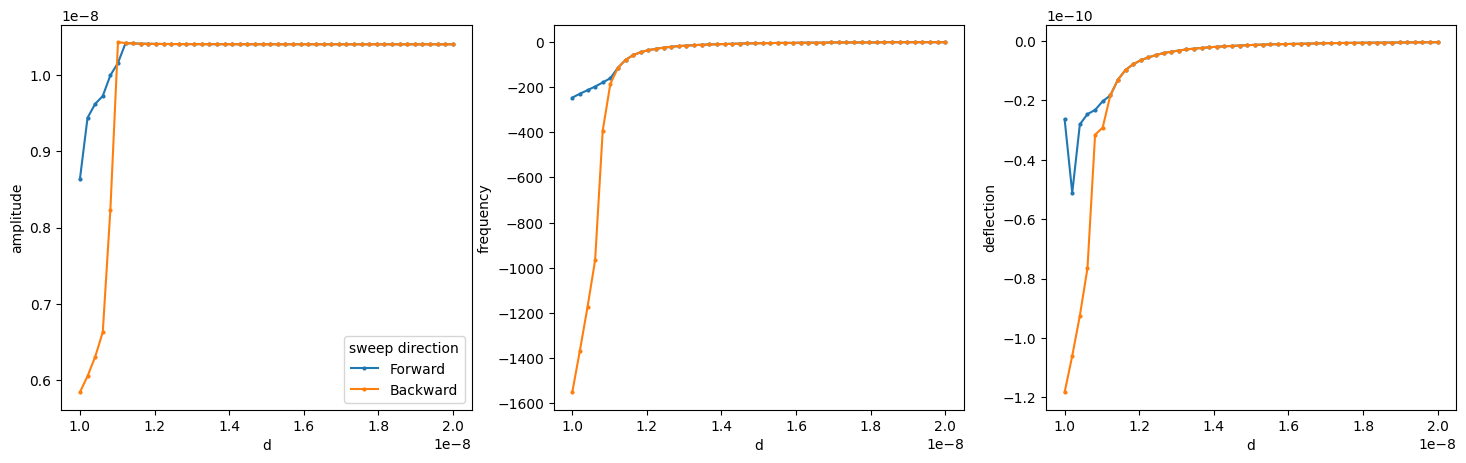

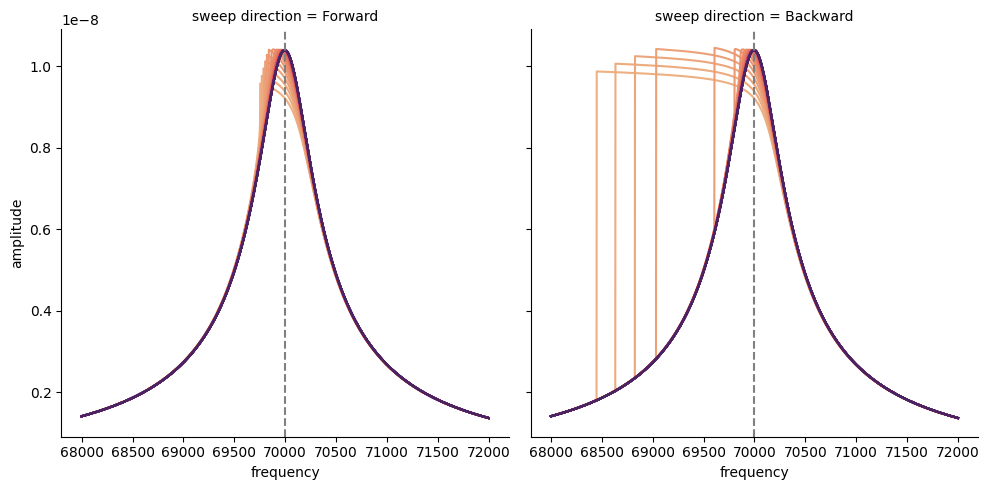

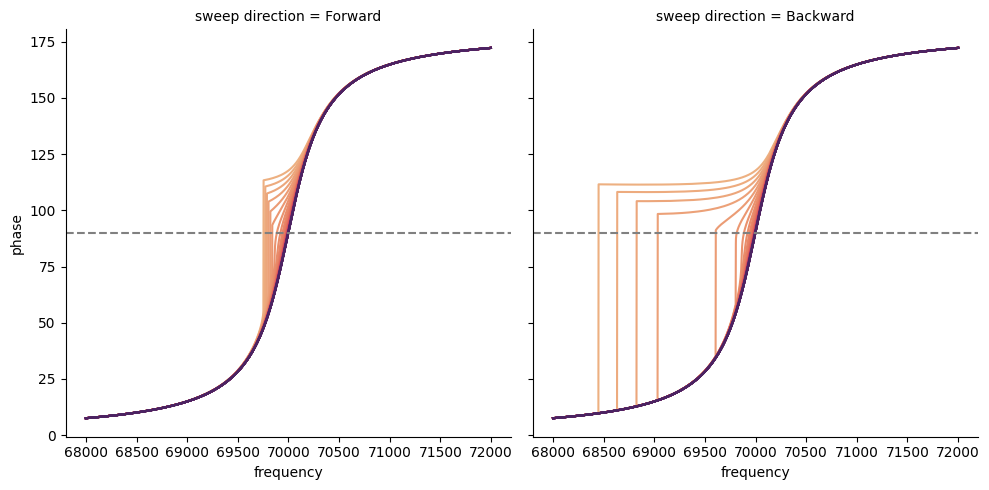

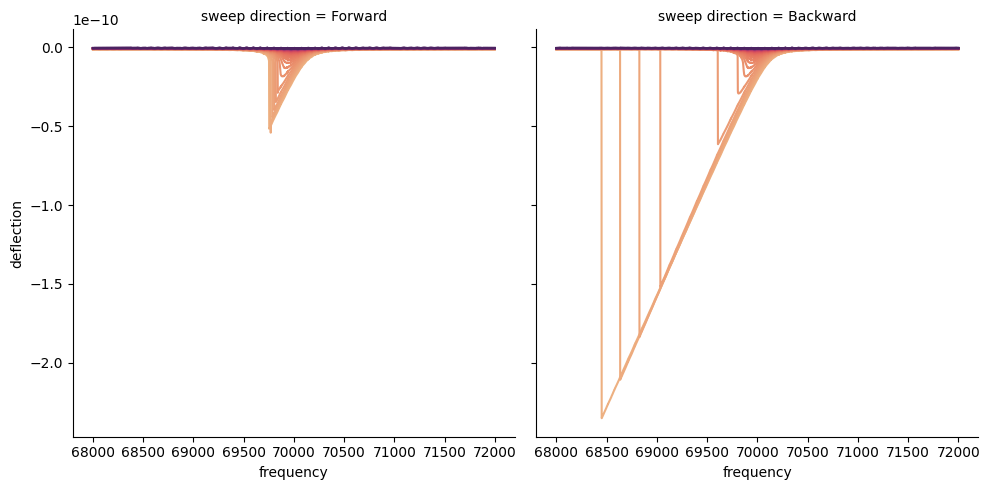

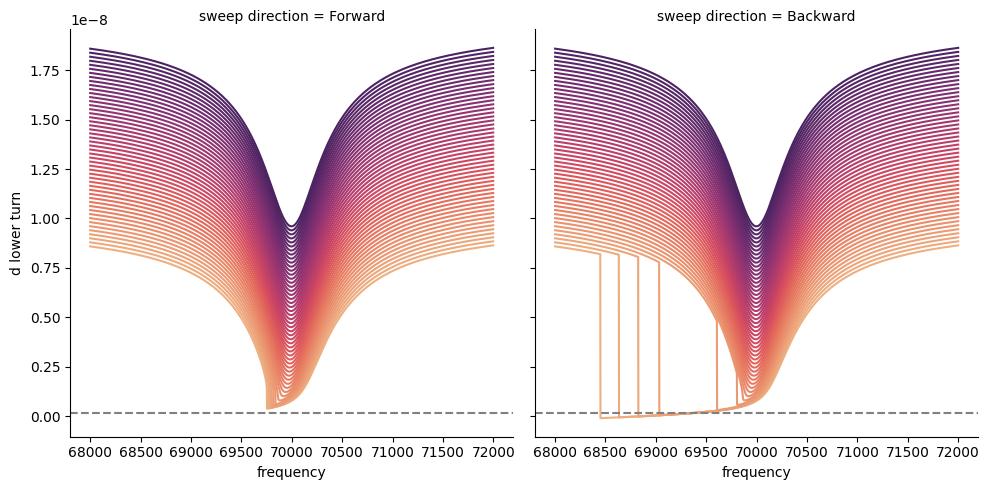

saved


In [166]:

# kc = 40 #cantilever spring constant (N/m)
# fc = 350e3 #cantilever resonance frequency (Hz)
# Qc = 400 #cantilever Q factor (free)
# d0_far = 12e-9 #tip-sample rest distance, far (m)
# d0_near = 2.5e-9 #tip-sample rest distance, near (m)
# d0_pts = 10 #number of points for force-distance
# d0_list = np.linspace(d0_far, d0_near, d0_pts) #[8e-9, 7e-9, 6e-9] #tip-sample distance, rest (m)
# # d0_list = d0_far + (d0_near - d0_far) * (np.linspace(0, 1, d0_pts))**(1/3) # = np.logspace(np.log(d0_far)/np.log(3),np.log(d0_near)/np.log(3),d0_pts, base=3)
# fd_ini = 70e3 #drive frequency (Hz)
fd_low, fd_up = fd_ini, fd_ini + 2*(fc-fd_ini)
fd_pts = 4000
fd_list = np.concatenate((np.linspace(fd_low, fd_up, fd_pts-1, endpoint=False),
                          np.linspace(fd_up, fd_low, fd_pts)), axis=None)
sweep_list = np.array(['Forward']*(fd_pts-1) + ['Backward']*fd_pts) #frequency sweep direction
# fd_list = np.linspace(fd_low, fd_up, fd_pts)
# fd_list = [fd_low, 68105.31026903474]
# fd_list = np.logspace(np.log(fd_low)/np.log(10), np.log(fd_up)/np.log(10), fd_pts) 
# F0 = 10e-10 #drive amplitude (m)
# d0_far = 10e-9 #tip-sample rest distance, far (m)
# d0_near = 7e-9 #tip-sample rest distance, near (m)
# d0_pts = 40 #number of points for force-distance
# d0_list = np.linspace(d0_far, d0_near, d0_pts) #[8e-9, 7e-9, 6e-9] #tip-sample distance, rest (m)
# # d0_list = d0_far + (d0_near - d0_far) * (np.linspace(0, 1, d0_pts))**(2) #np.logspace(np.log(d0_far)/np.log(3),np.log(d0_near)/np.log(3),d0_pts, base=3)
# R = 20e-9 #tip radius (m)
# H = 7.1e-20 #Hamaker constant (J)
# Y = 35e-3 #surface energy of sample (mJ/m2)
# # a0 = 1e-10 #intermolecular distance (m)
# E_s = 1.2e9 #elastic modulus of sample (Pa)
# nu_s = 0.3 #poisson ratio of sample
# E_t = 130e9 #elastic modulus of tip (Pa)
# nu_t = 0.3 #poisson ratio of tip
# E = 1/(((1-nu_s**2)/E_s)+((1-nu_t**2)/E_t))

# a0 = np.sqrt(H/(24*np.pi*Y)) #intermolecular distance (obtained by balancing vdW and  DMT adhesion)
# wc = 2*np.pi*fc #angular resonance frequency of cantilever
# mc = kc/(wc**2) #cantilever mass
# # wd_ini = 2*np.pi*fd_ini #angular drive frequency
# gamma = wc/Qc #damping coefficient, b/m (dimensionless)

# # freq_res = 300 #frequency resolution (Hz)
# # phase_res = 0.1 #phase resolution (deg)

# #numerical method parameters
# t0 = 0 #readjust this!
# t0 = -wd_ini/(phase_ini*np.pi/180) if abs(phase_ini) > phase_zero else 0 #readjust this!
# v0 = 0 #check readjustment!
# x0 = amp_ini  #F0/(mc*gamma*wc) #theoretical free amplitude at resonance (far away)
# x0 = 0 #F0/(mc*gamma*wc) #theoretical free amplitude at resonance (far away)
# fs = 500*fc #10*wc*np.pi/(phase_res*180)  # Sampling frequency in Hz
# dt = 1/fs #1/fd/20
# n_osci = 1000#int(fd/freq_res) #number of oscillations
# ss_osci = 100#int(n_osci/3) #number of steady state osci at end
# t_end = n_osci/fd_ini #0.006 #dt*n_samples

# fd_step = 10 #initial freq step size (Hz) to calculate bounds for wd in bisection section (PLL simulation)

# # freq_window = 10000 #Hz for finding resonance peak

# #macro variables for faster numerical calculation
# wc2 = wc**2
# F02 = F0/mc
# F_el0 = (4/3)*E*np.sqrt(R)
# F_vdw_adh = -H*R/(6*(a0**2))
# F_vdw0 = -H*R/6
# d_i = 0 

# #Runge-Kutta method for 2nd order differential equation, coupled as 2 first order differential eqs.
# def RungeKuttaCoupled(x, y, z, dx, dydx, dzdx, **kwargs):
#     # Compute the Runge-Kutta steps
#     k1 = dx * dydx(x, y, z, **kwargs)
#     h1 = dx * dzdx(x, y, z)
#     k2 = dx * dydx(x + dx / 2., y + k1 / 2., z + h1 / 2., **kwargs)
#     h2 = dx * dzdx(x + dx / 2., y + k1 / 2., z + h1 / 2.)
#     k3 = dx * dydx(x + dx / 2., y + k2 / 2., z + h2 / 2., **kwargs)
#     h3 = dx * dzdx(x + dx / 2., y + k2 / 2., z + h2 / 2.)
#     k4 = dx * dydx(x + dx, y + k3, z + h3, **kwargs)
#     h4 = dx * dzdx(x + dx, y + k3, z + h3)

#     # 4th order estimate
#     y4 = y + 1. / 6. * (k1 + 2 * k2 + 2 * k3 + k4)
#     z4 = z + 1. / 6. * (h1 + 2 * h2 + 2 * h3 + h4)
    
#     # Using additional coefficients for the 5th order estimate
#     # b_star = [16 / 135, 0, 6656 / 12825, 28561 / 56430, -9 / 50, 2 / 55]
#     # y5 = y + b_star[0] * k1 + b_star[2] * k2 + b_star[3] * k3 + b_star[4] * k4
#     # z5 = z + b_star[0] * h1 + b_star[2] * h2 + b_star[3] * h3 + b_star[4] * h4

#     # # Calculate the error
#     # error_y = np.abs(y5 - y4)
#     # error_z = np.abs(z5 - z4)

#     # Update the new values for y and z using the 4th order estimate
#     y = y4
#     z = z4
#     x = x + dx

#     return x, y, z#, error_y, error_z

# #tip-sample interaction force vs distance
# def force_ts(d):
#     if d >= a0:
#         F_vdw = F_vdw0/(d**2)#-H*R/(6*(d**2))
#         F_elas = 0
#     else:
#         F_vdw = F_vdw_adh #-H*R/(6*(a0**2)) #vdW adhesion
#         F_elas = F_el0*(a0-d)**(3/2) #CHECK THIS
#     return F_vdw + F_elas

# def dvdt(t, v, x, **kwargs):
#     d0 = kwargs['d0']
#     wd = kwargs['wd']
#     d_t = d0 + x #instantaneous tip sample distance
#     F_ts = force_ts(d_t)

#     return -(wc2*x)-(gamma*v)+(F_ts/mc)+(F02*np.cos(wd*t))

    
# def dxdt(t, v, x):
#     return v

# #solve 
# def solve_harmonic(v, x, **kwargs):
#     t = t0    
#     t_list = [t]
#     v_list = [v]
#     x_list = [x]
#     # err_v_list = [0]
#     # err_x_list = [0]
    
#     while t <= t_end:
#         t, v, x = RungeKuttaCoupled(t, v, x, dt, dvdt, dxdt, **kwargs)  #, err_v, err_x     
#         t_list.append(t)
#         v_list.append(v)
#         x_list.append(x)
#         # err_v_list.append(err_v)
#         # err_x_list.append(err_x)
    
#     # ss_osci = 100 #number of steady state osci at end
#     wd = kwargs['wd']
#     fd = wd/(2*np.pi)
#     ss_index = -int(ss_osci*fs/fd)
#     ss_t_list = t_list[ss_index:]
#     ss_x_list = x_list[ss_index:]
#     n_samples = len(ss_t_list)
    
#     # x_list = F0*np.cos(wd*np.array(t_list))
#     FT_omega = np.fft.fftfreq(n_samples, ss_t_list[1] - ss_t_list[0])
#     FT = np.fft.fft(ss_x_list)
#     FT_omega = np.fft.fftshift(FT_omega)
#     FT = np.fft.fftshift(FT)
#     FT_amplitude = np.abs(FT)*2/n_samples

#     f_index = int(n_samples/2) + np.argmax(FT_amplitude[int(n_samples/2):])
#     amplitude = FT_amplitude[f_index]

#     x_drive = F0*np.cos(wd*np.array(ss_t_list))
#     FT_drive = np.fft.fft(x_drive)
#     FT_drive = np.fft.fftshift(FT_drive)
#     phase = np.angle(FT_drive[f_index])-np.angle(FT[f_index])
#     # Normalize phase to be within [0, 2π]
#     phase = np.mod(phase, 2 * np.pi)    
#     # Adjust phase to be within [0, π]
#     if phase > np.pi:
#         phase -= np.pi
#     phase = phase*180/np.pi #in degrees
#     #set initial conditions for next iteration
#     # x = amplitude
#     # v = 0
#     # t_end += n_osci/fd #final time

#     return amplitude, phase, t_list, v_list, x_list#, err_v_list, err_x_list
    
def run_simulation(params):
    # print(x0, v0)
    # print(kc, fc, wd_ini)
    # get the start time
    exec_time = time.time()
    # phase_tol = params['phase_tol']
    # global phase
    # phase = 90
    d0_i = params['d0']
    
    #get initial condition from spectroscopy simulation earlier. RUN THAT FIRST!
    # x = amp_res if (d0_i-a0) > amp_res else (d0_i-a0)
    
    amp_i = spectro_datadf[spectro_datadf['d'] == d0_i]['amplitude'].iloc[0]
    phase_i = spectro_datadf[spectro_datadf['d'] == d0_i]['phase'].iloc[0]
    defl_i = spectro_datadf[spectro_datadf['d'] == d0_i]['deflection'].iloc[0]
    # print(amp_i, defl_i, amp_i+defl_i, phase_i)
    x =  defl_i + amp_i#x0 #if d0_i >= x0 else d0_i
    t = (phase_i*np.pi/180)/wd_ini #if abs(phase_i) > phase_zero else 0
    v = 0 #v0
    # wd = wd_ini
    simu_datadict = {'d': [], 'amplitude': [], 'phase': [], 'frequency': [], 
                     'deflection': [], 'sweep direction': []}
    osci_dict = {'d': [], 't':[], 'x': [], 'v': []}
    # print('start')
    for j, fd_j in enumerate(fd_list):
        wd = 2*np.pi*fd_j
        x_old = x
        # print('guess', x, t, v)
        amplitude, phase, deflection, t_list, v_list, x_list = solve_harmonic(v, x, t0=t, d0=d0_i, wd=wd) #, err_v_list, err_x_list
        #set initial conditions for next iteration
        # x = amp_res if (d0_i-a0) > amp_res else (d0_i-a0)
        x = deflection + amplitude + (amplitude-x_old)**2 if (d0_i+deflection-a0) > amplitude else (d0_i+deflection-a0)
        v = 0
        t = (phase*np.pi/180)/wd #if abs(phase) > phase_zero else 0

        sweep_j = sweep_list[j]
        simu_datadict['d'].append(d0_i)
        simu_datadict['amplitude'].append(amplitude)
        simu_datadict['phase'].append(phase)
        simu_datadict['frequency'].append(fd_j)
        simu_datadict['deflection'].append(deflection)
        simu_datadict['sweep direction'].append(sweep_j)
        # osci_dict['d'] = osci_dict['d'] + [d0_i]*len(t_list)
        # osci_dict['t'] = osci_dict['t'] + t_list
        # osci_dict['x'] = osci_dict['x'] + x_list
        # osci_dict['v'] = osci_dict['v'] + v_list
        
        exec_time_new = time.time()
        exec_time_diff = exec_time_new-exec_time
        # print('RESULT', d0_i, amplitude, phase, fc-fd_j, exec_time_diff)# freq_peak-FT_omega[f_index]) (max(ss_x_list)-min(ss_x_list))/2
        # ax1[0][1].plot(t_list[-n_samples:], x_list[-n_samples:], label="cantilever", color=colors[d0_i])
        exec_time = exec_time_new
        # print('RESULT', d0_i, fd_j, t, amplitude, phase, deflection, d0_i+deflection-amplitude)
    return simu_datadict, osci_dict

if __name__ == "__main__":
    d0_list_simu = d0_list[:] #[d0_list[-10]] #d0_list[-10:] #[d0_list[-5]]
    params = [{'d0': d0_i} for d0_i in d0_list_simu]
    # params = [
    #     {'d0': 0.1,},
    #     # {'phase_tol': 1e6},
    #     ]

    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(run_simulation, params)

print('finished')
print(d0_list_simu)

freqresp_fulldf = pd.concat([pd.DataFrame(results_i[0]) for results_i in results])
freqresp_fulldf.reset_index(drop=True, inplace=True)

osci_datadict = pd.concat([pd.DataFrame(results_i[1]) for results_i in results])

#tip sample distance at lower turning point of oscilation
freqresp_fulldf['d lower turn'] = freqresp_fulldf['d'] + freqresp_fulldf['deflection'] - freqresp_fulldf['amplitude']

freqresp_spectro = {'d': [], 'amplitude': [], 'frequency': [], 'deflection': [], 'sweep direction': []}
for d0_i in d0_list_simu:
    temp1 = freqresp_fulldf[freqresp_fulldf['d']== d0_i]
    for sweep_i in temp1['sweep direction'].unique():
        temp2 = temp1[temp1['sweep direction']== sweep_i]
        temp2['phasecross'] = np.sign((temp2['phase']-90)*(temp2['phase']-90).shift(-1))
        cross_ind = temp2['phasecross'].loc[lambda x: x==-1].index
        # print(cross_ind)
        if len(cross_ind) > 0:
            cross_ind1 = cross_ind[0]
            freq_i = np.mean([temp2['frequency'].loc[cross_ind1], temp2['frequency'].loc[cross_ind1+1]])
            amp_i = np.mean([temp2['amplitude'].loc[cross_ind1], temp2['amplitude'].loc[cross_ind1+1]])
            defl_i = np.mean([temp2['deflection'].loc[cross_ind1], temp2['deflection'].loc[cross_ind1+1]])
        else:
            freq_i = temp2['frequency'].iloc[-1]
            amp_i = temp2['amplitude'].iloc[-1]
            defl_i = temp2['deflection'].iloc[-1]
        freqresp_spectro['d'].append(d0_i)
        freqresp_spectro['amplitude'].append(amp_i)
        freqresp_spectro['frequency'].append(freq_i-fc)
        freqresp_spectro['deflection'].append(defl_i)
        freqresp_spectro['sweep direction'].append(sweep_i)
freqresp_spectro_df = pd.DataFrame(freqresp_spectro)

fig4, ax4 = plt.subplots(1, 3, figsize=(18,5))
sns.lineplot(data=freqresp_spectro_df, x='d', y='amplitude', hue='sweep direction', 
             legend='auto', ax=ax4[0], marker='.', markeredgewidth=0)
sns.lineplot(data=freqresp_spectro_df, x='d', y='frequency', hue='sweep direction',
             legend=False, ax=ax4[1], marker='.', markeredgewidth=0)
sns.lineplot(data=freqresp_spectro_df, x='d', y='deflection', hue='sweep direction',
             legend=False, ax=ax4[2], marker='.', markeredgewidth=0)
plt.show()


# fig3, ax3 = plt.subplots(2, 2, figsize=(12,10))
# sns.lineplot(data=freqresp_datadict, x='frequency', y='amplitude', hue='d', palette='flare', 
#              sort=False, estimator=None, legend=False, ax=ax3[0][0], marker='.', markeredgewidth=0)
# sns.lineplot(data=freqresp_datadict, x='frequency', y='phase', hue='d', palette='flare', 
#              sort=False, estimator=None, legend=False, ax=ax3[0][1], marker='.', markeredgewidth=0)
# sns.lineplot(data=freqresp_datadict, x='frequency', y='deflection', hue='d', palette='flare', 
#              sort=False, estimator=None, legend=False, ax=ax3[1][0], marker='.', markeredgewidth=0)
# sns.lineplot(data=freqresp_datadict, x='frequency', y='d lower turn', hue='d', palette='flare', 
#              sort=False, estimator=None, legend=False, ax=ax3[1][1], marker='.', markeredgewidth=0)
g1 = sns.relplot(data=freqresp_fulldf, x='frequency', y='amplitude', col='sweep direction', hue='d', palette='flare', 
             kind='line', sort=False, estimator=None, legend=False)#, marker='.', markeredgewidth=0)
for ax_i in g1.axes.flatten():
    ax_i.axvline(fc, linestyle='--', color='gray')
g2 = sns.relplot(data=freqresp_fulldf, x='frequency', y='phase', col='sweep direction', hue='d',palette='flare', 
                kind='line', sort=False, estimator=None, legend=False)#, ax=ax3[1])#, marker='.', markeredgewidth=0)
for ax_i in g2.axes.flatten():
    ax_i.axhline(90, linestyle='--', color='gray')
g3 = sns.relplot(data=freqresp_fulldf, x='frequency', y='deflection', col='sweep direction', hue='d',palette='flare', 
                 kind='line', sort=False, estimator=None, legend=False)#, ax=ax3[2])#, marker='.', markeredgewidth=0)
g4 = sns.relplot(data=freqresp_fulldf, x='frequency', y='d lower turn', col='sweep direction', hue='d',palette='flare', 
                 kind='line', sort=False, estimator=None, legend=False)#, ax=ax3[3])#, marker='.', markeredgewidth=0)
for ax_i in g4.axes.flatten():
    ax_i.axhline(a0, linestyle='--', color='gray')
# ax3[0][1].axhline(90, linestyle='--', color='k')
# ax3[1][1].axhline(a0, linestyle='--', color='k')
# handles, labels = ax3[0].get_legend_handles_labels()
# new_labels = [f"{float(label):.2e}" for label in labels]
# ax3[0].legend(handles, new_labels, title = 'd')
# sns.move_legend(ax3[0], "upper left", bbox_to_anchor=(2.3, 1))
plt.show()

# sns.lineplot(data=osci_datadict, x='t', y='x')
# plt.show()

# timestamp = datetime.datetime.now().strftime('%y%m%d-%H%M%S')
# freqresp_fulldf.to_csv(f'data/cantisimu_freqresp_fulldf_kc_{kc}_fdpts_{fd_pts}_{timestamp}.csv')
# freqresp_spectro_df.to_csv(f'data/cantisimu_freqresp_spectro_kc_{kc}_fdpts_{fd_pts}_{timestamp}.csv')
# fig4.savefig(f'data/cantisimu_freqresp_spectro_kc_{kc}_fdpts_{fd_pts}_{timestamp}.png', dpi=300, bbox_inches='tight')
# g1.figure.savefig(f'data/cantisimu_freqresp_amp_kc_{kc}_fdpts_{fd_pts}_{timestamp}.png', dpi=300, bbox_inches='tight')
# g2.figure.savefig(f'data/cantisimu_freqresp_phase_kc_{kc}_fdpts_{fd_pts}_{timestamp}.png', dpi=300, bbox_inches='tight')
# g3.figure.savefig(f'data/cantisimu_freqresp_defl_kc_{kc}_fdpts_{fd_pts}_{timestamp}.png', dpi=300, bbox_inches='tight')
# g4.figure.savefig(f'data/cantisimu_freqresp_dlow_kc_{kc}_fdpts_{fd_pts}_{timestamp}.png', dpi=300, bbox_inches='tight')
# print('saved')

9.959183673469387e-09 50


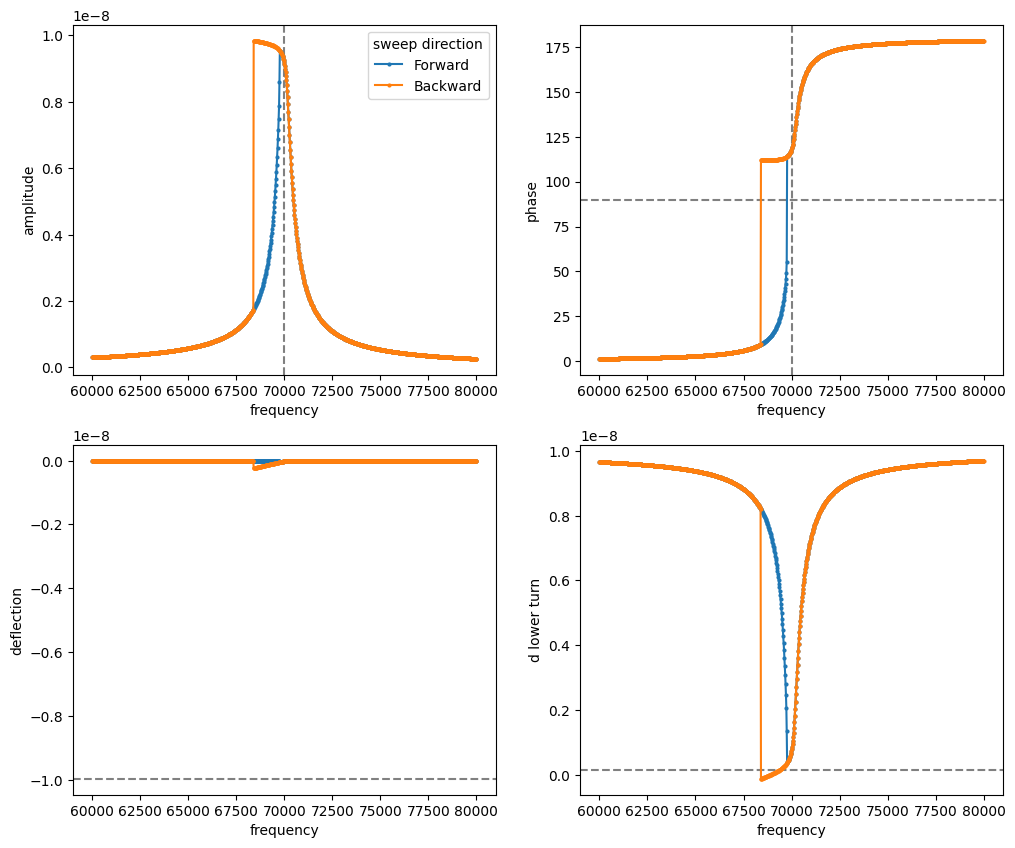

In [156]:
# freqresp_datadict = simu_results
d0_unique = freqresp_fulldf['d'].unique()
d0_select = d0_unique[19] #[d0_unique[36]] d0_unique
print(d0_select, len(d0_unique))
d0_selectind = freqresp_fulldf['d'].isin([d0_select])
freqresp_df_filt = freqresp_fulldf[d0_selectind]

fig3, ax3 = plt.subplots(2, 2, figsize=(12,10))
ax3[0][0].axvline(fc, linestyle='--', color='gray')
ax3[0][1].axvline(fc, linestyle='--', color='gray')
ax3[0][1].axhline(90, linestyle='--', color='gray')
ax3[1][0].axhline(-d0_select, linestyle='--', color='gray')
ax3[1][1].axhline(a0, linestyle='--', color='gray')
sns.lineplot(data=freqresp_df_filt, x='frequency', y='amplitude', hue='sweep direction',# hue='d', palette='flare', 
             sort=False, estimator=None, legend='auto', ax=ax3[0][0], marker='.', markeredgewidth=0)
sns.lineplot(data=freqresp_df_filt, x='frequency', y='phase', hue='sweep direction',# hue='d',palette='flare', 
             sort=False, estimator=None, legend=False, ax=ax3[0][1], marker='.', markeredgewidth=0)
sns.lineplot(data=freqresp_df_filt, x='frequency', y='deflection', hue='sweep direction',# hue='d',palette='flare', 
             sort=False, estimator=None, legend=False, ax=ax3[1][0], marker='.', markeredgewidth=0)
sns.lineplot(data=freqresp_df_filt, x='frequency', y='d lower turn', hue='sweep direction',# hue='d',palette='flare', 
             sort=False, estimator=None, legend=False, ax=ax3[1][1], marker='.', markeredgewidth=0)
# handles, labels = ax3[0].get_legend_handles_labels()
# new_labels = [f"{float(label):.2e}" for label in labels]
# ax3[0].legend(handles, new_labels, title = 'd')
# sns.move_legend(ax3[0], "upper left", bbox_to_anchor=(2.3, 1))
plt.show()

# fig4, ax4 = plt.subplots(1, 3, figsize=(18,5))
# sns.lineplot(data=freqresp_spectro_df, x='d', y='amplitude', hue='sweep direction', 
#              legend='auto', ax=ax4[0], marker='.', markeredgewidth=0)
# sns.lineplot(data=freqresp_spectro_df, x='d', y='frequency', hue='sweep direction',
#              legend=False, ax=ax4[1], marker='.', markeredgewidth=0)
# sns.lineplot(data=freqresp_spectro_df, x='d', y='deflection', hue='sweep direction',
#              legend=False, ax=ax4[2], marker='.', markeredgewidth=0)
# plt.show()

In [147]:
freqresp_spectro_df

d     amplitude    frequency    deflection sweep direction
0   1.500000e-08  1.038979e-08     0.000000 -1.424588e-12         Forward
1   1.500000e-08  1.038978e-08     0.000000 -1.435776e-12        Backward
2   1.473469e-08  1.038909e-08     0.000000 -1.551530e-12         Forward
3   1.473469e-08  1.038908e-08     0.000000 -1.562702e-12        Backward
4   1.446939e-08  1.038818e-08     0.000000 -1.698930e-12         Forward
..           ...           ...          ...           ...             ...
95  2.530612e-09  1.067316e-09 -3163.163163 -1.526154e-09        Backward
96  2.265306e-09  9.212177e-10 -3563.563564 -1.419159e-09         Forward
97  2.265306e-09  9.189956e-10 -3443.443443 -1.417374e-09        Backward
98  2.000000e-09  7.715583e-10 -4044.044044 -1.311114e-09         Forward
99  2.000000e-09  7.749571e-10 -4264.264264 -1.313863e-09        Backward

[100 rows x 5 columns]

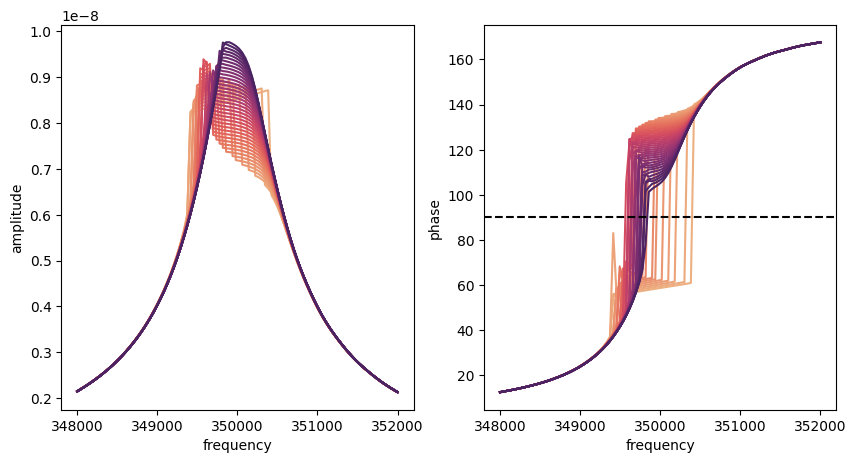

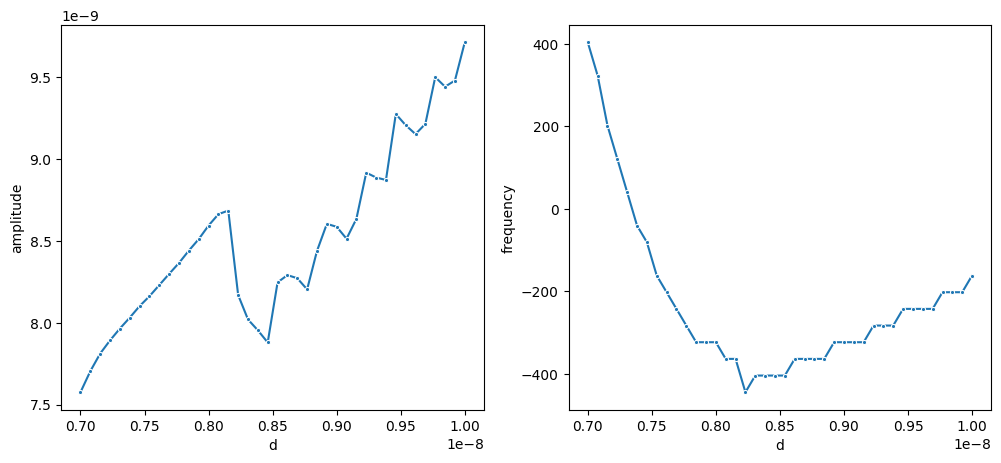

In [16]:
# freqresp_datadict = simu_results
fig3, ax3 = plt.subplots(1, 2, figsize=(10,5))
sns.lineplot(data=freqresp_datadict, x='frequency', y='amplitude', hue='d', palette='flare', legend=False, ax=ax3[0]) # marker='.', markeredgewidth=0,
sns.lineplot(data=freqresp_datadict, x='frequency', y='phase', hue='d', palette='flare', legend=False, ax=ax3[1])  #marker='.', markeredgewidth=0,
ax3[1].axhline(90, linestyle='--', color='k')
# handles, labels = ax3[0].get_legend_handles_labels()
# new_labels = [f"{float(label):.2e}" for label in labels]
# ax3[0].legend(handles, new_labels, title = 'd')
# sns.move_legend(ax3[0], "upper left", bbox_to_anchor=(2.3, 1))
plt.show()

fig4, ax4 = plt.subplots(1, 2, figsize=(12,5))
sns.lineplot(data=freqresp_spectro, x='d', y='amplitude', legend=False, ax=ax4[0], marker='.')
sns.lineplot(data=freqresp_spectro, x='d', y='frequency', legend=False, ax=ax4[1], marker='.')
plt.show()

In [23]:
freqresp_datadict.to_csv(f'cantisimu_freqresp_datadict_pts{fd_pts}.csv')
freqresp_spectro_df.to_csv(f'cantisimu_freqresp_spectro_pts{fd_pts}.csv')

In [24]:
# plt.close('all')
# X_lockin = np.array(x_list)*np.cos(wd*np.array(t_list))
# Y_lockin = np.array(x_list)*np.sin(wd*np.array(t_list))
# amp_lockin = np.sqrt(np.square(X_lockin) + np.square(Y_lockin))
# phase_lockin = np.arctan2(X_lockin, Y_lockin)*180/np.pi
# amp_lockin_rms = np.sqrt(np.mean(amp_lockin**2))
# plt.plot(t_list[ss_index-200:ss_index+6000], x_list[ss_index-200:ss_index+6000], '.-', label="cantilever", color="blue")
# plt.plot(t_list[ss_index-200:ss_index+6000], xdrive_list[ss_index-200:ss_index+6000], label="drive", color="red")
# # plt.plot(t_list, phase_lockin, label="amp lockin", color="red")
# # plt.axhline(amp_lockin_rms)
# plt.show()
# F0/(mc*gamma*wc)
# d_delta = d0_list[1]-d0_list[0]
# 1/(1+(d_delta/d0_list[1]))**4
# np.logspace(np.log(12e-9)/np.log(3),np.log(2.5e-9)/np.log(3),200, base=3)
# np.log(0.5)/np.log(10)
np.logspace(np.log(d0_far)/np.log(3),np.log(d0_near)/np.log(3),d0_pts, base=10), np.logspace(np.log(d0_far)/np.log(10),np.log(d0_near)/np.log(10),d0_pts, base=10)

(array([1.70912492e-17, 1.67667621e-17, 1.64484356e-17, 1.61361527e-17,
        1.58297987e-17, 1.55292610e-17, 1.52344292e-17, 1.49451949e-17,
        1.46614519e-17, 1.43830959e-17, 1.41100247e-17, 1.38421379e-17,
        1.35793370e-17, 1.33215256e-17, 1.30686089e-17, 1.28204939e-17,
        1.25770896e-17, 1.23383064e-17, 1.21040567e-17, 1.18742543e-17,
        1.16488148e-17, 1.14276555e-17, 1.12106949e-17, 1.09978535e-17,
        1.07890531e-17, 1.05842168e-17, 1.03832694e-17, 1.01861371e-17,
        9.99274755e-18, 9.80302957e-18, 9.61691349e-18, 9.43433093e-18,
        9.25521481e-18, 9.07949931e-18, 8.90711986e-18, 8.73801314e-18,
        8.57211700e-18, 8.40937050e-18, 8.24971383e-18, 8.09308833e-18]),
 array([1.00000000e-08, 9.90896182e-09, 9.81875243e-09, 9.72936429e-09,
        9.64078992e-09, 9.55302192e-09, 9.46605295e-09, 9.37987572e-09,
        9.29448303e-09, 9.20986775e-09, 9.12602278e-09, 9.04294113e-09,
        8.96061584e-09, 8.87904002e-09, 8.79820685e-09, 8.7181

In [52]:
# linear_space = np.linspace(0, 1, d0_pts)
    
    # Apply the power law transformation
d0_far + (d0_near - d0_far) * (np.linspace(0, 1, d0_pts))**(1/3)

array([1.20000000e-08, 1.01262191e-08, 9.63918402e-09, 9.29754033e-09,
       9.02555825e-09, 8.79587976e-09, 8.59511417e-09, 8.41558612e-09,
       8.25243823e-09, 8.10237870e-09, 7.96306146e-09, 7.83274862e-09,
       7.71011267e-09, 7.59411401e-09, 7.48392150e-09, 7.37885896e-09,
       7.27836804e-09, 7.18198171e-09, 7.08930487e-09, 7.00000000e-09])

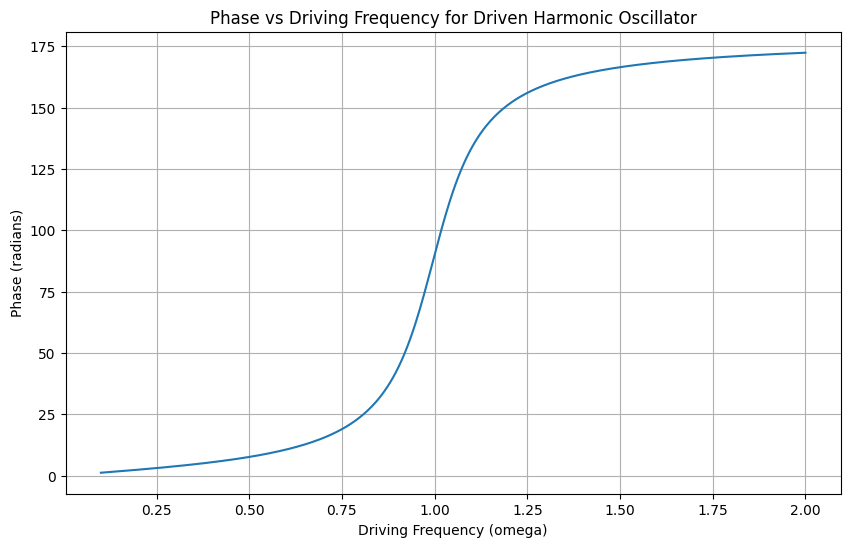

In [67]:
# Parameters
gamma = 0.1
omega_0 = 1.0
F_0 = 1.0
omega_range = np.linspace(0.1, 2.0, 500)

# Arrays to hold phase values
phases = []

# Calculate phase for each driving frequency
for omega in omega_range:
    phi = np.arctan2(2 * gamma * omega, omega_0**2 - omega**2)
    phases.append(phi*180/np.pi)

# Convert list to array for plotting
phases = np.array(phases)

# Plotting phase vs driving frequency
plt.figure(figsize=(10, 6))
plt.plot(omega_range, phases)
plt.title('Phase vs Driving Frequency for Driven Harmonic Oscillator')
plt.xlabel('Driving Frequency (omega)')
plt.ylabel('Phase (radians)')
plt.grid(True)
plt.show()


Amplitude at 50 Hz: 1.0000000000000004
Phase angle at 50 Hz: 4.474936315605433e-15 radians


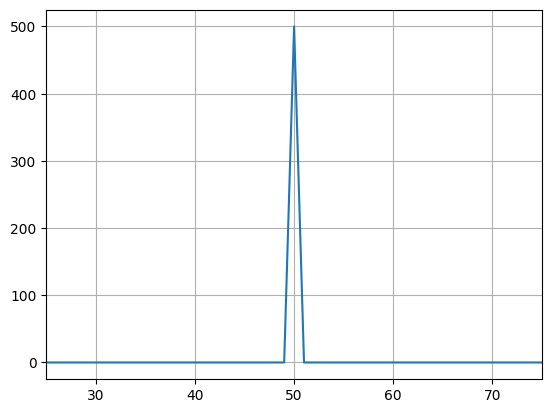

In [325]:
# Parameters
fs = 1000  # Sampling frequency in Hz
t = np.arange(0, 1, 1/fs)  # Time vector from 0 to 1 second
f_signal = 50  # Signal frequency in Hz

# Generate a cosine wave
cosine_wave = np.cos(2 * np.pi * f_signal * t)

# Compute the FFT
N = len(cosine_wave)
X = np.fft.fft(cosine_wave)

# Define the frequency of interest
f = f_signal  # Frequency at which to find amplitude and phase

# Calculate the index corresponding to the frequency
index = int(f * N / fs)

# Extract the FFT coefficient at the specified frequency
fft_coefficient = X[index]

# Calculate amplitude and phase angle
amplitude = np.abs(fft_coefficient) *2 / N
phase_angle = np.angle(fft_coefficient)

print(f"Amplitude at {f} Hz: {amplitude}")
print(f"Phase angle at {f} Hz: {phase_angle} radians")


omega = np.fft.fftfreq(N, t[1] - t[0])
omega = np.fft.fftshift(omega)
X = np.fft.fftshift(X)
plt.plot(omega, X, '-')
plt.gca().set_xlim(25, 75)
plt.grid(True)
plt.show()

In [104]:
(phase_shift + np.pi)*2

-1.2566370614359181